In [1]:
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
import os
import glob
from datetime import datetime
from datetime import timedelta
from matplotlib import pyplot as plt
import matplotlib.dates as md
import warnings
from scipy.interpolate import interp2d
warnings.filterwarnings('ignore')
#import datetime
import scipy.ndimage as ndimage
from matplotlib import cm
import geopy.distance
#import matplotlib as mpl

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import leafmap
import plotly.express as px
from mpl_toolkits.basemap import Basemap

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import pysplit as pys
import matplotlib.transforms as mtransforms
from scipy.optimize import curve_fit

In [2]:
def simple_read(path):
    with open(path) as f:
        first_line = f.readline()
        header_line = int(first_line[0:-2].split(",")[0])-1
        #all_lines = f.readlines()
    data = pd.read_csv(path, sep=',', skiprows=header_line)
    data.columns = [i.strip() for i in data.columns]
    #date = all_lines[5][0:10].split(',')
    #dt = datetime(int(date[0]), int(date[1]), int(date[2]))

    acc = 0
    boo = False
    for letter in path:
        if letter == '2':
            boo = True
        elif boo and letter == '0':
            acc -= 1
            break
        acc += 1
    #print(path[:acc+4], path[acc+4:acc+6], path[acc+6:acc+8])
    dt = datetime(int(path[acc:acc+4]), int(path[acc+4:acc+6]), int(path[acc+6:acc+8]))
    
    for column in data.keys():
        if 'Time' in column:
            data[column] = dt + pd.to_timedelta(data[column], unit='seconds')
    return data.replace(-999999, np.NaN)

In [3]:
def add_sum(data, s):
    data = pd.merge_asof(data, s, left_index=True, right_index=True)
    return data

In [4]:
LAS22 = simple_read('C:/Users/taiwoajayi/Documents/Aeronet/bermuda/activate-mrg1_hu25_20220602_RA_L1_20230131T122324.ict')
start_index = np.where(LAS22["Time_Start"] == pd.to_datetime("2022-06-02 12:58:55"))
stop_index = np.where(LAS22["Time_Start"] == pd.to_datetime("2022-06-02 13:10:00"))


LAS22_subset = LAS22[start_index[0][0]:stop_index[0][0]]
LAS22_subset

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,nLAS_AmmSO4_ZIEMBA,sLAS_AmmSO4_ZIEMBA,vLAS_AmmSO4_ZIEMBA,LAS_Bin01_ZIEMBA,LAS_Bin02_ZIEMBA,LAS_Bin03_ZIEMBA,LAS_Bin04_ZIEMBA,...,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA,stdPT_ZIEMBA
5981,2022-06-02 12:58:55,2022-06-02 12:58:56,115.705,293.02,55.75,6.81,240.32,331.92,375.49,508.39,...,0.00,17.30,17.32,25.96,0.0,0.00,10.39,0.00,0.0,1.103
5982,2022-06-02 12:58:56,2022-06-02 12:58:57,115.605,298.92,81.83,21.50,288.96,399.60,522.31,448.96,...,0.00,0.00,17.35,13.00,0.0,10.40,0.00,0.00,10.4,1.103
5983,2022-06-02 12:58:57,2022-06-02 12:58:58,114.775,281.59,78.28,14.64,239.79,430.79,312.07,536.89,...,25.87,0.00,17.27,0.00,0.0,20.71,20.72,0.00,0.0,1.104
5984,2022-06-02 12:58:58,2022-06-02 12:58:59,113.025,236.74,53.54,10.40,431.36,298.06,332.64,387.90,...,0.00,34.51,0.00,12.94,0.0,0.00,0.00,10.35,0.0,1.103
5985,2022-06-02 12:58:59,2022-06-02 12:59:00,110.485,232.14,30.10,1.36,262.30,164.74,434.09,267.06,...,0.00,0.00,17.19,0.00,0.0,0.00,0.00,0.00,0.0,1.103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6641,2022-06-02 13:09:55,2022-06-02 13:09:56,3810.860,213.92,14.12,0.42,986.18,1129.56,626.76,538.28,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,1.589
6642,2022-06-02 13:09:56,2022-06-02 13:09:57,3811.410,163.86,10.53,0.32,792.83,730.67,625.60,447.97,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,1.589
6643,2022-06-02 13:09:57,2022-06-02 13:09:58,3812.340,206.88,13.70,0.42,1273.67,963.25,479.53,507.70,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,1.589
6644,2022-06-02 13:09:58,2022-06-02 13:09:59,3813.680,183.10,12.73,0.43,1130.71,698.68,543.42,209.43,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,1.589


In [5]:
# Columns to remove
columns_to_remove = ['Time_Start', 'Time_Stop', 'GPS_Altitude_THORNHILL', 'nLAS_AmmSO4_ZIEMBA', 'sLAS_AmmSO4_ZIEMBA', 'vLAS_AmmSO4_ZIEMBA', 'stdPT_ZIEMBA']

# Remove the specified columns in-place
LAS22_subset.drop(columns=columns_to_remove, inplace=True)

In [6]:
SMPS22 = simple_read('C:/Users/taiwoajayi/Documents/Aeronet/bermuda/activate-mrg1_hu25_20220602_RA_L1_20230131T122818.ict')
start_index = np.where(SMPS22["Time_Start"]==pd.to_datetime("2022-06-02 13:48:00"))
stop_index = np.where(SMPS22["Time_Start"]==pd.to_datetime("2022-06-02 14:10:00"))
    
SMPS22_subset = SMPS22[start_index[0][0]:stop_index[0][0]]
SMPS22_subset

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,...,SMPS_Bin22_ZIEMBA,SMPS_Bin23_ZIEMBA,SMPS_Bin24_ZIEMBA,SMPS_Bin25_ZIEMBA,SMPS_Bin26_ZIEMBA,SMPS_Bin27_ZIEMBA,SMPS_Bin28_ZIEMBA,SMPS_Bin29_ZIEMBA,SMPS_Bin30_ZIEMBA,stdPT_ZIEMBA
8926,2022-06-02 13:48:00,2022-06-02 13:48:01,1896.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8927,2022-06-02 13:48:01,2022-06-02 13:48:02,1897.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8928,2022-06-02 13:48:02,2022-06-02 13:48:03,1898.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8929,2022-06-02 13:48:03,2022-06-02 13:48:04,1898.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8930,2022-06-02 13:48:04,2022-06-02 13:48:05,1899.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10241,2022-06-02 14:09:55,2022-06-02 14:09:56,2855.32,260.88,2.47,0.03,NaN,NaN,0.0,0.0,...,492.73,104.88,724.82,578.55,373.19,500.37,416.87,390.16,445.65,1.439
10242,2022-06-02 14:09:56,2022-06-02 14:09:57,2861.28,260.88,2.47,0.03,NaN,NaN,0.0,0.0,...,492.73,104.88,724.82,578.55,373.19,500.37,416.87,390.16,445.65,1.439
10243,2022-06-02 14:09:57,2022-06-02 14:09:58,2867.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10244,2022-06-02 14:09:58,2022-06-02 14:09:59,2872.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Columns to remove
columns_to_remove = ['nSMPS_ZIEMBA', 'sSMPS_ZIEMBA', 'vSMPS_ZIEMBA', 'stdPT_ZIEMBA']

# Remove the specified columns in-place
SMPS22_subset.drop(columns=columns_to_remove, inplace=True)

In [8]:
data = add_sum(SMPS22_subset, LAS22_subset)

In [9]:
list(data)

['Time_Start',
 'Time_Stop',
 'GPS_Altitude_THORNHILL',
 'SMPS_Bin01_ZIEMBA',
 'SMPS_Bin02_ZIEMBA',
 'SMPS_Bin03_ZIEMBA',
 'SMPS_Bin04_ZIEMBA',
 'SMPS_Bin05_ZIEMBA',
 'SMPS_Bin06_ZIEMBA',
 'SMPS_Bin07_ZIEMBA',
 'SMPS_Bin08_ZIEMBA',
 'SMPS_Bin09_ZIEMBA',
 'SMPS_Bin10_ZIEMBA',
 'SMPS_Bin11_ZIEMBA',
 'SMPS_Bin12_ZIEMBA',
 'SMPS_Bin13_ZIEMBA',
 'SMPS_Bin14_ZIEMBA',
 'SMPS_Bin15_ZIEMBA',
 'SMPS_Bin16_ZIEMBA',
 'SMPS_Bin17_ZIEMBA',
 'SMPS_Bin18_ZIEMBA',
 'SMPS_Bin19_ZIEMBA',
 'SMPS_Bin20_ZIEMBA',
 'SMPS_Bin21_ZIEMBA',
 'SMPS_Bin22_ZIEMBA',
 'SMPS_Bin23_ZIEMBA',
 'SMPS_Bin24_ZIEMBA',
 'SMPS_Bin25_ZIEMBA',
 'SMPS_Bin26_ZIEMBA',
 'SMPS_Bin27_ZIEMBA',
 'SMPS_Bin28_ZIEMBA',
 'SMPS_Bin29_ZIEMBA',
 'SMPS_Bin30_ZIEMBA',
 'LAS_Bin01_ZIEMBA',
 'LAS_Bin02_ZIEMBA',
 'LAS_Bin03_ZIEMBA',
 'LAS_Bin04_ZIEMBA',
 'LAS_Bin05_ZIEMBA',
 'LAS_Bin06_ZIEMBA',
 'LAS_Bin07_ZIEMBA',
 'LAS_Bin08_ZIEMBA',
 'LAS_Bin09_ZIEMBA',
 'LAS_Bin10_ZIEMBA',
 'LAS_Bin11_ZIEMBA',
 'LAS_Bin12_ZIEMBA',
 'LAS_Bin13_ZIEMBA',
 'LAS_Bin14

In [10]:
data

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,SMPS_Bin05_ZIEMBA,SMPS_Bin06_ZIEMBA,SMPS_Bin07_ZIEMBA,...,LAS_Bin17_ZIEMBA,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA
8926,2022-06-02 13:48:00,2022-06-02 13:48:01,1896.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8927,2022-06-02 13:48:01,2022-06-02 13:48:02,1897.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8928,2022-06-02 13:48:02,2022-06-02 13:48:03,1898.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8929,2022-06-02 13:48:03,2022-06-02 13:48:04,1898.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8930,2022-06-02 13:48:04,2022-06-02 13:48:05,1899.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10241,2022-06-02 14:09:55,2022-06-02 14:09:56,2855.32,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10242,2022-06-02 14:09:56,2022-06-02 14:09:57,2861.28,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10243,2022-06-02 14:09:57,2022-06-02 14:09:58,2867.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10244,2022-06-02 14:09:58,2022-06-02 14:09:59,2872.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(data.GPS_Altitude_THORNHILL.min(), data.GPS_Altitude_THORNHILL.max(), nbins+1)
data['Bins'] = pd.cut(data['GPS_Altitude_THORNHILL'], bins_1000)
data_1000 = data.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(data_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(data_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_1000a = data_1000[start_index:stop_index]
DAY1000_subset_1000a


,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,SMPS_Bin05_ZIEMBA,SMPS_Bin06_ZIEMBA,SMPS_Bin07_ZIEMBA,...,LAS_Bin17_ZIEMBA,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA
Bins,,,,,,,,,,,,,,,,,,,,,
"(106.28, 134.006]",2022-06-02 13:58:08.000,2022-06-02 13:58:09.000,122.4800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(134.006, 161.732]",2022-06-02 13:58:49.000,2022-06-02 13:58:50.000,149.2400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(161.732, 189.459]",2022-06-02 13:59:02.000,2022-06-02 13:59:03.000,174.5650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(189.459, 217.185]",2022-06-02 13:57:08.000,2022-06-02 13:57:09.000,202.3350,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(217.185, 244.911]",2022-06-02 13:57:01.500,2022-06-02 13:57:02.500,231.2250,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(244.911, 272.637]",2022-06-02 13:58:08.000,2022-06-02 13:58:09.000,260.1525,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(272.637, 300.363]",2022-06-02 13:59:28.000,2022-06-02 13:59:29.000,282.5850,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(300.363, 328.09]",2022-06-02 13:56:41.500,2022-06-02 13:56:42.500,312.9625,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(328.09, 355.816]",2022-06-02 13:56:33.500,2022-06-02 13:56:34.500,339.6750,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
DAY1000_subset_1000a = DAY1000_subset_1000a.reset_index(drop=True)

In [13]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(data_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(data_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3000_subset_3000a = data_1000[start_index:stop_index]
DAY3000_subset_3000a

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,SMPS_Bin05_ZIEMBA,SMPS_Bin06_ZIEMBA,SMPS_Bin07_ZIEMBA,...,LAS_Bin17_ZIEMBA,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA
Bins,,,,,,,,,,,,,,,,,,,,,
"(993.518, 1021.245]",2022-06-02 14:02:19.500,2022-06-02 14:02:20.500,1005.710,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(1021.245, 1048.971]",2022-06-02 14:02:24.500,2022-06-02 14:02:25.500,1036.645,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(1048.971, 1076.697]",2022-06-02 14:02:31.500,2022-06-02 14:02:32.500,1060.535,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(1076.697, 1104.423]",2022-06-02 14:02:37.500,2022-06-02 14:02:38.500,1089.530,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(1104.423, 1132.149]",2022-06-02 14:02:43.000,2022-06-02 14:02:44.000,1119.480,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(2712.543, 2740.269]",2022-06-02 14:09:22.000,2022-06-02 14:09:23.000,2729.930,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(2740.269, 2767.995]",2022-06-02 14:09:30.500,2022-06-02 14:09:31.500,2751.515,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(2767.995, 2795.721]",2022-06-02 14:09:38.000,2022-06-02 14:09:39.000,2784.750,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
DAY3000_subset_3000a = DAY3000_subset_3000a.reset_index(drop=True)

In [15]:
DAY3000_subset_3000a

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,SMPS_Bin05_ZIEMBA,SMPS_Bin06_ZIEMBA,SMPS_Bin07_ZIEMBA,...,LAS_Bin17_ZIEMBA,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA
0,2022-06-02 14:02:19.500,2022-06-02 14:02:20.500,1005.710,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-06-02 14:02:24.500,2022-06-02 14:02:25.500,1036.645,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-06-02 14:02:31.500,2022-06-02 14:02:32.500,1060.535,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-06-02 14:02:37.500,2022-06-02 14:02:38.500,1089.530,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-06-02 14:02:43.000,2022-06-02 14:02:44.000,1119.480,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,2022-06-02 14:09:22.000,2022-06-02 14:09:23.000,2729.930,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63,2022-06-02 14:09:30.500,2022-06-02 14:09:31.500,2751.515,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64,2022-06-02 14:09:38.000,2022-06-02 14:09:39.000,2784.750,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65,2022-06-02 14:09:46.000,2022-06-02 14:09:47.000,2805.610,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
'''nbins = 5
bins = np.linspace(DAY3000_subset_3000a.GPS_Altitude_THORNHILL.min(), DAY3000_subset_3000a.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY3000_subset_3000a['Bins'] = pd.cut(DAY3000_subset_3000a['GPS_Altitude_THORNHILL'], bins)
DAY3000_subset_3000a_median = DAY3000_subset_3000a.groupby('Bins').median()
DAY3000_subset_3000a_median
DAY3000_subset_3000a_25 = DAY3000_subset_3000a_median - DAY3000_subset_3000a.groupby('Bins').quantile(.25)
DAY3000_subset_3000a_25
DAY3000_subset_3000a_75 = DAY3000_subset_3000a.groupby('Bins').quantile(.75) - DAY3000_subset_3000a_median
DAY3000_subset_3000a_75'''

"nbins = 5\nbins = np.linspace(DAY3000_subset_3000a.GPS_Altitude_THORNHILL.min(), DAY3000_subset_3000a.GPS_Altitude_THORNHILL.max(), nbins+1)\nDAY3000_subset_3000a['Bins'] = pd.cut(DAY3000_subset_3000a['GPS_Altitude_THORNHILL'], bins)\nDAY3000_subset_3000a_median = DAY3000_subset_3000a.groupby('Bins').median()\nDAY3000_subset_3000a_median\nDAY3000_subset_3000a_25 = DAY3000_subset_3000a_median - DAY3000_subset_3000a.groupby('Bins').quantile(.25)\nDAY3000_subset_3000a_25\nDAY3000_subset_3000a_75 = DAY3000_subset_3000a.groupby('Bins').quantile(.75) - DAY3000_subset_3000a_median\nDAY3000_subset_3000a_75"

In [17]:
'''DAY3000_subset_3000a_median
    
value22a = []
uevalue = []
levalue = []

for key in DAY3000_subset_3000a_median.keys():
    if 'Bin' in key:
        value22a.append(DAY3000_subset_3000a_median[key].T)
        uevalue.append(DAY3000_subset_3000a_75[key].T)
        levalue.append(DAY3000_subset_3000a_25[key].T)
value22a = np.array(value22a)
uevalue = np.array(uevalue)
levalue = np.array(levalue)
value22a[value22a==0] = 1
uevalue[uevalue==0] = 1
levalue[levalue==0] = 1
    
LAS_mid = [100.0, 112.2, 125.9, 141.3, 158.5, 177.8, 199.5, 223.9, 251.2, 281.8, 316.2, 354.8, 398.1, 446.7, 501.2, 562.3, 631.0, 707.9, 794.3, 891.3, 1000.0, 1258.9, 1584.9, 1995.3, 2511.9, 3162.3]
SMPS_mid = [3.16, 3.55, 3.98, 4.47, 5.01, 5.62, 6.31, 7.08, 7.94, 8.91, 10.0, 11.2, 12.6, 14.1, 15.8, 17.8, 20.0, 22.4, 25.1, 28.2, 31.6, 35.5, 39.8, 44.7, 50.1, 56.2, 63.1, 70.8, 79.4, 89.1]
all_mid = LAS_mid + SMPS_mid'''

"DAY3000_subset_3000a_median\n    \nvalue22a = []\nuevalue = []\nlevalue = []\n\nfor key in DAY3000_subset_3000a_median.keys():\n    if 'Bin' in key:\n        value22a.append(DAY3000_subset_3000a_median[key].T)\n        uevalue.append(DAY3000_subset_3000a_75[key].T)\n        levalue.append(DAY3000_subset_3000a_25[key].T)\nvalue22a = np.array(value22a)\nuevalue = np.array(uevalue)\nlevalue = np.array(levalue)\nvalue22a[value22a==0] = 1\nuevalue[uevalue==0] = 1\nlevalue[levalue==0] = 1\n    \nLAS_mid = [100.0, 112.2, 125.9, 141.3, 158.5, 177.8, 199.5, 223.9, 251.2, 281.8, 316.2, 354.8, 398.1, 446.7, 501.2, 562.3, 631.0, 707.9, 794.3, 891.3, 1000.0, 1258.9, 1584.9, 1995.3, 2511.9, 3162.3]\nSMPS_mid = [3.16, 3.55, 3.98, 4.47, 5.01, 5.62, 6.31, 7.08, 7.94, 8.91, 10.0, 11.2, 12.6, 14.1, 15.8, 17.8, 20.0, 22.4, 25.1, 28.2, 31.6, 35.5, 39.8, 44.7, 50.1, 56.2, 63.1, 70.8, 79.4, 89.1]\nall_mid = LAS_mid + SMPS_mid"

In [18]:
'''data_75

uevalue = []
for key in data_75.keys():
    if 'Bin' in key:
        uevalue.append(data_75[key].T)
uevalue = np.array(uevalue)
uevalue[uevalue==0] = 1


'''


"data_75\n\nuevalue = []\nfor key in data_75.keys():\n    if 'Bin' in key:\n        uevalue.append(data_75[key].T)\nuevalue = np.array(uevalue)\nuevalue[uevalue==0] = 1\n\n\n"

In [19]:
'''data_25

levalue = []
for key in data_25.keys():
    if 'Bin' in key:
        levalue.append(data_25[key].T)
levalue = np.array(levalue)
levalue[levalue==0] = 1'''





"data_25\n\nlevalue = []\nfor key in data_25.keys():\n    if 'Bin' in key:\n        levalue.append(data_25[key].T)\nlevalue = np.array(levalue)\nlevalue[levalue==0] = 1"

In [20]:
'''data_median
    
value22a = []

for key in data_median.keys():
    if 'Bin' in key:
        value22a.append(data_median[key].T)
value22a = np.array(value22a)
value22a[value22a==0] = 1'''

"data_median\n    \nvalue22a = []\n\nfor key in data_median.keys():\n    if 'Bin' in key:\n        value22a.append(data_median[key].T)\nvalue22a = np.array(value22a)\nvalue22a[value22a==0] = 1"

In [21]:
'''data_median
    
value22a = []
uevalue = []
levalue = []

for key in data_median.keys():
    if 'Bin' in key:
        value22a.append(data_median[key].T)
        uevalue.append(data_75[key].T)
        levalue.append(data_25[key].T)
value22a = np.array(value22a)
uevalue = np.array(uevalue)
levalue = np.array(levalue)
value22a[value22a==0] = 1
#uevalue[uevalue==0] = 1
#levalue[levalue==0] = 1'''
    
LAS_mid = [100.0, 112.2, 125.9, 141.3, 158.5, 177.8, 199.5, 223.9, 251.2, 281.8, 316.2, 354.8, 398.1, 446.7, 501.2, 562.3, 631.0, 707.9, 794.3, 891.3, 1000.0, 1258.9, 1584.9, 1995.3, 2511.9, 3162.3]
SMPS_mid = [3.16, 3.55, 3.98, 4.47, 5.01, 5.62, 6.31, 7.08, 7.94, 8.91, 10.0, 11.2, 12.6, 14.1, 15.8, 17.8, 20.0, 22.4, 25.1, 28.2, 31.6, 35.5, 39.8, 44.7, 50.1, 56.2, 63.1, 70.8, 79.4, 89.1]
all_mid =  SMPS_mid + LAS_mid

In [22]:
all_mid_val = pd.DataFrame(all_mid, columns=['value'])
all_mid_val

,value
0,3.16
1,3.55
2,3.98
3,4.47
4,5.01
5,5.62
6,6.31
7,7.08
8,7.94
9,8.91


In [23]:
'''fig, ax = plt.subplots()
plt.rcParams['font.size'] = '10'
ax.errorbar(all_mid, value22a, xerr=[levalue, uevalue], marker='o', linestyle='-', capsize=4, alpha=.6, color="darkorange")
ax.set_ylabel('Altitude (m)', labelpad=11)
ax.set_xscale('log')
ax.legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='medium')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)
fig.text(0.02, 0.98, '06/02_12:58:13:10 UTC', ha='left', va='top', fontsize=10)
# Set the title
fig.suptitle('number concentration', fontsize=16)

plt.show()'''


'fig, ax = plt.subplots()\nplt.rcParams[\'font.size\'] = \'10\'\nax.errorbar(all_mid, value22a, xerr=[levalue, uevalue], marker=\'o\', linestyle=\'-\', capsize=4, alpha=.6, color="darkorange")\nax.set_ylabel(\'Altitude (m)\', labelpad=11)\nax.set_xscale(\'log\')\nax.legend(bbox_to_anchor=(1.15, 1), loc = \'right\', fontsize=\'medium\')\n\n# Adjust the spacing between subplots\nplt.subplots_adjust(wspace=0.3)\nfig.text(0.02, 0.98, \'06/02_12:58:13:10 UTC\', ha=\'left\', va=\'top\', fontsize=10)\n# Set the title\nfig.suptitle(\'number concentration\', fontsize=16)\n\nplt.show()'

In [24]:
LAS = simple_read('C:/Users/taiwoajayi/Documents/Aeronet/bermuda/activate-mrg1_hu25_20220602_RA_L1_20230131T122324.ict')
start_index = np.where(LAS["Time_Start"]==pd.to_datetime("2022-06-02 13:48:00"))
stop_index = np.where(LAS["Time_Start"]==pd.to_datetime("2022-06-02 14:10:00"))
    
LAS_subset = LAS[start_index[0][0]:stop_index[0][0]]
LAS_subset

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,nLAS_AmmSO4_ZIEMBA,sLAS_AmmSO4_ZIEMBA,vLAS_AmmSO4_ZIEMBA,LAS_Bin01_ZIEMBA,LAS_Bin02_ZIEMBA,LAS_Bin03_ZIEMBA,LAS_Bin04_ZIEMBA,...,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA,stdPT_ZIEMBA
8926,2022-06-02 13:48:00,2022-06-02 13:48:01,1896.68,125.18,16.58,1.07,360.53,232.87,208.88,299.46,...,0.00,0.00,34.65,0.00,0.0,0.0,0.0,0.0,0.0,1.301
8927,2022-06-02 13:48:01,2022-06-02 13:48:02,1897.28,105.98,13.16,0.63,144.19,332.14,208.62,89.50,...,25.94,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,1.301
8928,2022-06-02 13:48:02,2022-06-02 13:48:03,1898.01,108.47,11.92,0.69,408.32,232.86,229.87,149.47,...,0.00,0.00,0.00,12.97,0.0,0.0,0.0,0.0,0.0,1.301
8929,2022-06-02 13:48:03,2022-06-02 13:48:04,1898.83,127.25,14.64,0.71,504.51,232.03,208.89,239.23,...,0.00,17.29,0.00,0.00,0.0,0.0,0.0,0.0,0.0,1.302
8930,2022-06-02 13:48:04,2022-06-02 13:48:05,1899.75,133.17,12.27,0.41,384.68,332.31,292.10,268.94,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,1.302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10241,2022-06-02 14:09:55,2022-06-02 14:09:56,2855.32,152.94,14.05,0.52,696.81,398.76,292.34,448.58,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,1.445
10242,2022-06-02 14:09:56,2022-06-02 14:09:57,2861.28,150.62,11.90,0.41,865.52,431.41,396.28,328.90,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,1.446
10243,2022-06-02 14:09:57,2022-06-02 14:09:58,2867.15,164.86,15.26,0.60,697.16,531.94,520.54,299.09,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,1.447
10244,2022-06-02 14:09:58,2022-06-02 14:09:59,2872.99,194.08,15.05,0.50,818.04,731.78,585.09,328.91,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,1.448


In [25]:
SMPS = simple_read('C:/Users/taiwoajayi/Documents/Aeronet/bermuda/activate-mrg1_hu25_20220602_RA_L1_20230131T122818.ict')
start_index = np.where(SMPS["Time_Start"]==pd.to_datetime("2022-06-02 13:48:00"))
stop_index = np.where(SMPS["Time_Start"]==pd.to_datetime("2022-06-02 14:10:00"))
    
SMPS_subset = SMPS[start_index[0][0]:stop_index[0][0]]
SMPS_subset

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,...,SMPS_Bin22_ZIEMBA,SMPS_Bin23_ZIEMBA,SMPS_Bin24_ZIEMBA,SMPS_Bin25_ZIEMBA,SMPS_Bin26_ZIEMBA,SMPS_Bin27_ZIEMBA,SMPS_Bin28_ZIEMBA,SMPS_Bin29_ZIEMBA,SMPS_Bin30_ZIEMBA,stdPT_ZIEMBA
8926,2022-06-02 13:48:00,2022-06-02 13:48:01,1896.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8927,2022-06-02 13:48:01,2022-06-02 13:48:02,1897.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8928,2022-06-02 13:48:02,2022-06-02 13:48:03,1898.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8929,2022-06-02 13:48:03,2022-06-02 13:48:04,1898.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8930,2022-06-02 13:48:04,2022-06-02 13:48:05,1899.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10241,2022-06-02 14:09:55,2022-06-02 14:09:56,2855.32,260.88,2.47,0.03,NaN,NaN,0.0,0.0,...,492.73,104.88,724.82,578.55,373.19,500.37,416.87,390.16,445.65,1.439
10242,2022-06-02 14:09:56,2022-06-02 14:09:57,2861.28,260.88,2.47,0.03,NaN,NaN,0.0,0.0,...,492.73,104.88,724.82,578.55,373.19,500.37,416.87,390.16,445.65,1.439
10243,2022-06-02 14:09:57,2022-06-02 14:09:58,2867.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10244,2022-06-02 14:09:58,2022-06-02 14:09:59,2872.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# Columns to remove
columns_to_remove = ['Time_Start', 'Time_Stop', 'GPS_Altitude_THORNHILL', 'nLAS_AmmSO4_ZIEMBA', 'sLAS_AmmSO4_ZIEMBA', 'vLAS_AmmSO4_ZIEMBA', 'stdPT_ZIEMBA']

# Remove the specified columns in-place
LAS_subset.drop(columns=columns_to_remove, inplace=True)

In [27]:
# Columns to remove
columns_to_remove = ['nSMPS_ZIEMBA', 'sSMPS_ZIEMBA', 'vSMPS_ZIEMBA', 'stdPT_ZIEMBA']

# Remove the specified columns in-place
SMPS_subset.drop(columns=columns_to_remove, inplace=True)

In [28]:
data2 = add_sum(SMPS_subset, LAS_subset)

In [29]:
#binning data2 into groups
nbins = 100
bins_1000 = np.linspace(data2.GPS_Altitude_THORNHILL.min(), data2.GPS_Altitude_THORNHILL.max(), nbins+1)
data2['Bins'] = pd.cut(data2['GPS_Altitude_THORNHILL'], bins_1000)
data2_1000 = data2.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(data2_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(data2_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_1000b = data2_1000[start_index:stop_index]
DAY1000_subset_1000b


,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,SMPS_Bin05_ZIEMBA,SMPS_Bin06_ZIEMBA,SMPS_Bin07_ZIEMBA,...,LAS_Bin17_ZIEMBA,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA
Bins,,,,,,,,,,,,,,,,,,,,,
"(106.28, 134.006]",2022-06-02 13:58:08.000,2022-06-02 13:58:09.000,122.4800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0
"(134.006, 161.732]",2022-06-02 13:58:49.000,2022-06-02 13:58:50.000,149.2400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0
"(161.732, 189.459]",2022-06-02 13:59:02.000,2022-06-02 13:59:03.000,174.5650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0
"(189.459, 217.185]",2022-06-02 13:57:08.000,2022-06-02 13:57:09.000,202.3350,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000,0.000,17.300,0.0,0.0,0.0,0.0,0.0,0.0
"(217.185, 244.911]",2022-06-02 13:57:01.500,2022-06-02 13:57:02.500,231.2250,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0
"(244.911, 272.637]",2022-06-02 13:58:08.000,2022-06-02 13:58:09.000,260.1525,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0
"(272.637, 300.363]",2022-06-02 13:59:28.000,2022-06-02 13:59:29.000,282.5850,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0
"(300.363, 328.09]",2022-06-02 13:56:41.500,2022-06-02 13:56:42.500,312.9625,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000,0.000,8.640,0.0,0.0,0.0,0.0,0.0,0.0
"(328.09, 355.816]",2022-06-02 13:56:33.500,2022-06-02 13:56:34.500,339.6750,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000,0.000,8.640,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
DAY1000_subset_1000b = DAY1000_subset_1000b.reset_index(drop=True)

In [31]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(data2_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(data2_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3000_subset_3000b = data2_1000[start_index:stop_index]
DAY3000_subset_3000b

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,SMPS_Bin05_ZIEMBA,SMPS_Bin06_ZIEMBA,SMPS_Bin07_ZIEMBA,...,LAS_Bin17_ZIEMBA,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA
Bins,,,,,,,,,,,,,,,,,,,,,
"(993.518, 1021.245]",2022-06-02 14:02:19.500,2022-06-02 14:02:20.500,1005.710,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(1021.245, 1048.971]",2022-06-02 14:02:24.500,2022-06-02 14:02:25.500,1036.645,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(1048.971, 1076.697]",2022-06-02 14:02:31.500,2022-06-02 14:02:32.500,1060.535,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(1076.697, 1104.423]",2022-06-02 14:02:37.500,2022-06-02 14:02:38.500,1089.530,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(1104.423, 1132.149]",2022-06-02 14:02:43.000,2022-06-02 14:02:44.000,1119.480,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(2712.543, 2740.269]",2022-06-02 14:09:22.000,2022-06-02 14:09:23.000,2729.930,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(2740.269, 2767.995]",2022-06-02 14:09:30.500,2022-06-02 14:09:31.500,2751.515,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(2767.995, 2795.721]",2022-06-02 14:09:38.000,2022-06-02 14:09:39.000,2784.750,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
LAS2b = simple_read('C:/Users/taiwoajayi/Documents/Aeronet/bermuda/activate-mrg1_hu25_20220602_RA_L2_20230131T122324.ict')
start_index = np.where(LAS2b["Time_Start"]==pd.to_datetime("2022-06-02 18:36:00"))
stop_index = np.where(LAS2b["Time_Start"]==pd.to_datetime("2022-06-02 18:53:00"))
    
LAS2b_subset = LAS2b[start_index[0][0]:stop_index[0][0]]
LAS2b_subset

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,nLAS_AmmSO4_ZIEMBA,sLAS_AmmSO4_ZIEMBA,vLAS_AmmSO4_ZIEMBA,LAS_Bin01_ZIEMBA,LAS_Bin02_ZIEMBA,LAS_Bin03_ZIEMBA,LAS_Bin04_ZIEMBA,...,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA,stdPT_ZIEMBA
9180,2022-06-02 18:36:00,2022-06-02 18:36:01,191.225,220.35,28.35,1.19,119.93,166.08,375.02,358.28,...,0.0,17.27,0.00,0.00,0.00,0.00,0.0,0.0,0.00,1.110
9181,2022-06-02 18:36:01,2022-06-02 18:36:02,193.480,248.28,35.68,1.86,215.95,232.26,250.41,477.42,...,0.0,0.00,17.29,12.96,0.00,0.00,0.0,0.0,0.00,1.110
9182,2022-06-02 18:36:02,2022-06-02 18:36:03,195.600,245.18,65.75,18.65,337.39,166.13,460.06,419.15,...,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,10.41,1.110
9183,2022-06-02 18:36:03,2022-06-02 18:36:04,197.010,269.44,51.18,5.11,167.38,264.14,415.64,327.20,...,25.8,0.00,0.00,12.92,10.33,10.33,0.0,0.0,0.00,1.111
9184,2022-06-02 18:36:04,2022-06-02 18:36:05,197.440,255.98,32.04,1.20,96.52,400.72,356.44,390.39,...,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,1.111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10195,2022-06-02 18:52:55,2022-06-02 18:52:56,3678.610,290.88,14.77,0.38,2140.67,1429.70,941.74,658.44,...,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,1.571
10196,2022-06-02 18:52:56,2022-06-02 18:52:57,3684.900,287.82,16.20,0.46,2044.58,1329.33,981.41,508.76,...,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,1.572
10197,2022-06-02 18:52:57,2022-06-02 18:52:58,3691.340,299.42,16.67,0.46,1969.50,1560.97,834.51,567.92,...,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,1.574
10198,2022-06-02 18:52:58,2022-06-02 18:52:59,3697.790,306.24,16.67,0.44,1875.74,1694.55,982.46,627.50,...,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,1.576


In [33]:
SMPS2b = simple_read('C:/Users/taiwoajayi/Documents/Aeronet/bermuda/activate-mrg1_hu25_20220602_RA_L2_20230131T122818.ict')
start_index = np.where(SMPS2b["Time_Start"]==pd.to_datetime("2022-06-02 18:36:00"))
stop_index = np.where(SMPS2b["Time_Start"]==pd.to_datetime("2022-06-02 18:53:00"))
    
SMPS2b_subset = SMPS2b[start_index[0][0]:stop_index[0][0]]
SMPS2b_subset

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,...,SMPS_Bin22_ZIEMBA,SMPS_Bin23_ZIEMBA,SMPS_Bin24_ZIEMBA,SMPS_Bin25_ZIEMBA,SMPS_Bin26_ZIEMBA,SMPS_Bin27_ZIEMBA,SMPS_Bin28_ZIEMBA,SMPS_Bin29_ZIEMBA,SMPS_Bin30_ZIEMBA,stdPT_ZIEMBA
9180,2022-06-02 18:36:00,2022-06-02 18:36:01,191.225,342.66,3.17,0.03,0.0,0.0,0.0,0.0,...,442.45,836.26,728.92,603.14,659.68,799.43,334.17,797.47,291.89,1.113
9181,2022-06-02 18:36:01,2022-06-02 18:36:02,193.480,342.66,3.17,0.03,0.0,0.0,0.0,0.0,...,442.45,836.26,728.92,603.14,659.68,799.43,334.17,797.47,291.89,1.113
9182,2022-06-02 18:36:02,2022-06-02 18:36:03,195.600,342.66,3.17,0.03,0.0,0.0,0.0,0.0,...,442.45,836.26,728.92,603.14,659.68,799.43,334.17,797.47,291.89,1.113
9183,2022-06-02 18:36:03,2022-06-02 18:36:04,197.010,342.66,3.17,0.03,0.0,0.0,0.0,0.0,...,442.45,836.26,728.92,603.14,659.68,799.43,334.17,797.47,291.89,1.113
9184,2022-06-02 18:36:04,2022-06-02 18:36:05,197.440,342.66,3.17,0.03,0.0,0.0,0.0,0.0,...,442.45,836.26,728.92,603.14,659.68,799.43,334.17,797.47,291.89,1.113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10195,2022-06-02 18:52:55,2022-06-02 18:52:56,3678.610,1590.40,7.05,0.07,NaN,NaN,0.0,0.0,...,930.60,1062.13,2239.70,1562.11,1466.99,1065.20,1175.79,941.18,723.94,1.567
10196,2022-06-02 18:52:56,2022-06-02 18:52:57,3684.900,1590.40,7.05,0.07,NaN,NaN,0.0,0.0,...,930.60,1062.13,2239.70,1562.11,1466.99,1065.20,1175.79,941.18,723.94,1.567
10197,2022-06-02 18:52:57,2022-06-02 18:52:58,3691.340,1590.40,7.05,0.07,NaN,NaN,0.0,0.0,...,930.60,1062.13,2239.70,1562.11,1466.99,1065.20,1175.79,941.18,723.94,1.567
10198,2022-06-02 18:52:58,2022-06-02 18:52:59,3697.790,1590.40,7.05,0.07,NaN,NaN,0.0,0.0,...,930.60,1062.13,2239.70,1562.11,1466.99,1065.20,1175.79,941.18,723.94,1.567


In [34]:
# Columns to remove
columns_to_remove = ['Time_Start', 'Time_Stop', 'GPS_Altitude_THORNHILL', 'nLAS_AmmSO4_ZIEMBA', 'sLAS_AmmSO4_ZIEMBA', 'vLAS_AmmSO4_ZIEMBA', 'stdPT_ZIEMBA']

# Remove the specified columns in-place
LAS2b_subset.drop(columns=columns_to_remove, inplace=True)

In [35]:
# Columns to remove
columns_to_remove = ['nSMPS_ZIEMBA', 'sSMPS_ZIEMBA', 'vSMPS_ZIEMBA', 'stdPT_ZIEMBA']

# Remove the specified columns in-place
SMPS2b_subset.drop(columns=columns_to_remove, inplace=True)

In [36]:
data2b = add_sum(SMPS2b_subset, LAS2b_subset)

In [37]:
#binning data2b into groups
nbins = 100
bins_1000 = np.linspace(data2b.GPS_Altitude_THORNHILL.min(), data2b.GPS_Altitude_THORNHILL.max(), nbins+1)
data2b['Bins'] = pd.cut(data2b['GPS_Altitude_THORNHILL'], bins_1000)
data2b_1000 = data2b.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(data2b_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(data2b_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_10002b = data2b_1000[start_index:stop_index]
DAY1000_subset_10002b


,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,SMPS_Bin05_ZIEMBA,SMPS_Bin06_ZIEMBA,SMPS_Bin07_ZIEMBA,...,LAS_Bin17_ZIEMBA,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA
Bins,,,,,,,,,,,,,,,,,,,,,
"(132.5, 168.217]",2022-06-02 18:36:33.500,2022-06-02 18:36:34.500,151.3675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0
"(168.217, 203.933]",2022-06-02 18:36:12.000,2022-06-02 18:36:13.000,186.7200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0
"(203.933, 239.65]",2022-06-02 18:37:02.000,2022-06-02 18:37:03.000,214.3750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0
"(239.65, 275.366]",2022-06-02 18:37:13.000,2022-06-02 18:37:14.000,260.1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0
"(275.366, 311.083]",2022-06-02 18:37:24.000,2022-06-02 18:37:25.000,289.4500,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0
"(311.083, 346.8]",2022-06-02 18:37:38.000,2022-06-02 18:37:39.000,332.1600,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0
"(346.8, 382.516]",2022-06-02 18:37:53.000,2022-06-02 18:37:54.000,362.9050,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0
"(382.516, 418.233]",2022-06-02 18:38:07.000,2022-06-02 18:38:08.000,399.5450,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0
"(418.233, 453.949]",2022-06-02 18:38:19.000,2022-06-02 18:38:20.000,432.9000,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(data2b_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(data2b_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3000_subset_30002b = data2b_1000[start_index:stop_index]
DAY3000_subset_30002b

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,SMPS_Bin05_ZIEMBA,SMPS_Bin06_ZIEMBA,SMPS_Bin07_ZIEMBA,...,LAS_Bin17_ZIEMBA,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA
Bins,,,,,,,,,,,,,,,,,,,,,
"(989.698, 1025.415]",2022-06-02 18:41:23.000,2022-06-02 18:41:24.000,1010.300,NaN,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(1025.415, 1061.132]",2022-06-02 18:41:31.500,2022-06-02 18:41:32.500,1046.060,NaN,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(1061.132, 1096.848]",2022-06-02 18:41:40.500,2022-06-02 18:41:41.500,1080.155,NaN,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(1096.848, 1132.565]",2022-06-02 18:41:52.500,2022-06-02 18:41:53.500,1111.995,NaN,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(1132.565, 1168.281]",2022-06-02 18:42:04.500,2022-06-02 18:42:05.500,1150.090,NaN,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3275.561, 3311.277]",2022-06-02 18:51:48.500,2022-06-02 18:51:49.500,3293.650,NaN,NaN,0.0,0.0,1308.94,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(3311.277, 3346.994]",2022-06-02 18:51:54.000,2022-06-02 18:51:55.000,3329.670,NaN,NaN,0.0,0.0,1308.94,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(3346.994, 3382.711]",2022-06-02 18:51:59.000,2022-06-02 18:52:00.000,3366.390,NaN,NaN,0.0,0.0,1308.94,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
DAY1000_subset_10002b = DAY1000_subset_10002b.reset_index(drop=True)
DAY3000_subset_30002b = DAY3000_subset_30002b.reset_index(drop=True)

In [40]:
LAS7 = simple_read('C:/Users/taiwoajayi/Documents/Aeronet/bermuda/activate-mrg1_hu25_20220607_RA_L1_20230131T122325.ict')
start_index = np.where(LAS7["Time_Start"]==pd.to_datetime("2022-06-07 14:32:00"))
stop_index = np.where(LAS7["Time_Start"]==pd.to_datetime("2022-06-07 14:47:00"))
    
LAS7_subset = LAS7[start_index[0][0]:stop_index[0][0]]
LAS7_subset

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,nLAS_AmmSO4_ZIEMBA,sLAS_AmmSO4_ZIEMBA,vLAS_AmmSO4_ZIEMBA,LAS_Bin01_ZIEMBA,LAS_Bin02_ZIEMBA,LAS_Bin03_ZIEMBA,LAS_Bin04_ZIEMBA,...,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA,stdPT_ZIEMBA
10397,2022-06-07 14:32:00,2022-06-07 14:32:01,127.595,665.22,51.40,1.67,2279.85,2224.35,2480.28,1373.68,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,1.088
10398,2022-06-07 14:32:01,2022-06-07 14:32:02,126.585,705.23,58.10,2.47,2544.73,2488.52,2312.98,1941.12,...,0.00,0.00,34.57,0.00,0.00,0.00,0.00,0.0,0.0,1.088
10399,2022-06-07 14:32:02,2022-06-07 14:32:03,125.870,680.19,87.40,11.73,2046.82,2496.76,1902.85,2126.88,...,77.97,17.33,17.34,13.01,0.00,0.00,20.81,0.0,0.0,1.088
10400,2022-06-07 14:32:03,2022-06-07 14:32:04,125.955,604.75,68.55,8.24,2024.90,2132.99,1905.74,1768.90,...,0.00,0.00,17.37,0.00,0.00,10.41,10.42,0.0,0.0,1.088
10401,2022-06-07 14:32:04,2022-06-07 14:32:05,126.990,602.24,64.47,5.38,1725.31,2020.77,1746.92,1610.05,...,25.89,17.25,17.26,0.00,10.35,10.35,0.00,0.0,0.0,1.087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11292,2022-06-07 14:46:55,2022-06-07 14:46:56,2800.660,198.96,10.79,0.27,1248.75,962.58,626.07,477.55,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,1.431
11293,2022-06-07 14:46:56,2022-06-07 14:46:57,2805.770,206.00,11.95,0.31,1154.89,965.32,689.43,538.90,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,1.432
11294,2022-06-07 14:46:57,2022-06-07 14:46:58,2810.920,239.42,13.36,0.35,1923.92,764.03,670.17,537.95,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,1.433
11295,2022-06-07 14:46:58,2022-06-07 14:46:59,2816.140,196.67,10.42,0.26,1273.93,830.54,876.47,418.17,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,1.434


In [41]:
SMPS7 = simple_read('C:/Users/taiwoajayi/Documents/Aeronet/bermuda/activate-mrg1_hu25_20220607_RA_L1_20230131T122819.ict')
start_index = np.where(SMPS7["Time_Start"]==pd.to_datetime("2022-06-07 14:32:00"))
stop_index = np.where(SMPS7["Time_Start"]==pd.to_datetime("2022-06-07 14:47:00"))
    
SMPS7_subset = SMPS7[start_index[0][0]:stop_index[0][0]]
SMPS7_subset

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,...,SMPS_Bin22_ZIEMBA,SMPS_Bin23_ZIEMBA,SMPS_Bin24_ZIEMBA,SMPS_Bin25_ZIEMBA,SMPS_Bin26_ZIEMBA,SMPS_Bin27_ZIEMBA,SMPS_Bin28_ZIEMBA,SMPS_Bin29_ZIEMBA,SMPS_Bin30_ZIEMBA,stdPT_ZIEMBA
10397,2022-06-07 14:32:00,2022-06-07 14:32:01,127.595,835.74,9.46,0.11,0.0,0.0,0.0,0.0,...,1054.51,1371.55,1616.39,1793.3,1074.02,1993.01,1998.35,1970.72,1742.82,1.089
10398,2022-06-07 14:32:01,2022-06-07 14:32:02,126.585,835.74,9.46,0.11,0.0,0.0,0.0,0.0,...,1054.51,1371.55,1616.39,1793.3,1074.02,1993.01,1998.35,1970.72,1742.82,1.089
10399,2022-06-07 14:32:02,2022-06-07 14:32:03,125.870,835.74,9.46,0.11,0.0,0.0,0.0,0.0,...,1054.51,1371.55,1616.39,1793.3,1074.02,1993.01,1998.35,1970.72,1742.82,1.089
10400,2022-06-07 14:32:03,2022-06-07 14:32:04,125.955,835.74,9.46,0.11,0.0,0.0,0.0,0.0,...,1054.51,1371.55,1616.39,1793.3,1074.02,1993.01,1998.35,1970.72,1742.82,1.089
10401,2022-06-07 14:32:04,2022-06-07 14:32:05,126.990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11292,2022-06-07 14:46:55,2022-06-07 14:46:56,2800.660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.426
11293,2022-06-07 14:46:56,2022-06-07 14:46:57,2805.770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.426
11294,2022-06-07 14:46:57,2022-06-07 14:46:58,2810.920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.426
11295,2022-06-07 14:46:58,2022-06-07 14:46:59,2816.140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.426


In [42]:
# Columns to remove
columns_to_remove = ['Time_Start', 'Time_Stop', 'GPS_Altitude_THORNHILL', 'nLAS_AmmSO4_ZIEMBA', 'sLAS_AmmSO4_ZIEMBA', 'vLAS_AmmSO4_ZIEMBA', 'stdPT_ZIEMBA']

# Remove the specified columns in-place
LAS7_subset.drop(columns=columns_to_remove, inplace=True)
# Columns to remove
columns_to_remove = ['nSMPS_ZIEMBA', 'sSMPS_ZIEMBA', 'vSMPS_ZIEMBA', 'stdPT_ZIEMBA']

# Remove the specified columns in-place
SMPS7_subset.drop(columns=columns_to_remove, inplace=True)

In [43]:
data7 = add_sum(SMPS7_subset, LAS7_subset)

In [44]:
#binning data7 into groups
nbins = 100
bins_1000 = np.linspace(data7.GPS_Altitude_THORNHILL.min(), data7.GPS_Altitude_THORNHILL.max(), nbins+1)
data7['Bins'] = pd.cut(data7['GPS_Altitude_THORNHILL'], bins_1000)
data7_1000 = data7.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(data7_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(data7_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_10007 = data7_1000[start_index:stop_index]
DAY1000_subset_10007


,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,SMPS_Bin05_ZIEMBA,SMPS_Bin06_ZIEMBA,SMPS_Bin07_ZIEMBA,...,LAS_Bin17_ZIEMBA,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA
Bins,,,,,,,,,,,,,,,,,,,,,
"(125.87, 152.826]",2022-06-07 14:32:05.500,2022-06-07 14:32:06.500,130.6300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.635,0.000,8.625,17.330,0.000,0.0,10.355,0.000,0.0,0.0
"(152.826, 179.781]",2022-06-07 14:32:14.000,2022-06-07 14:32:15.000,172.0250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,25.850,0.000,17.290,0.000,0.0,0.000,0.000,0.0,0.0
"(179.781, 206.737]",2022-06-07 14:32:27.500,2022-06-07 14:32:28.500,188.3900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,8.630,25.865,0.000,0.0,0.000,0.000,0.0,0.0
"(206.737, 233.692]",2022-06-07 14:32:40.000,2022-06-07 14:32:41.000,219.6400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17.260,0.000,34.520,17.340,12.990,0.0,0.000,0.000,0.0,0.0
"(233.692, 260.648]",2022-06-07 14:32:48.000,2022-06-07 14:32:49.000,250.9800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.0
"(260.648, 287.604]",2022-06-07 14:33:01.000,2022-06-07 14:33:02.000,261.7850,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,17.320,0.000,0.0,0.000,0.000,0.0,0.0
"(287.604, 314.559]",2022-06-07 14:33:13.500,2022-06-07 14:33:14.500,305.6750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,17.285,17.345,6.485,0.0,0.000,0.000,0.0,0.0
"(314.559, 341.515]",2022-06-07 14:33:26.000,2022-06-07 14:33:27.000,326.2850,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,17.270,17.250,0.000,0.0,0.000,0.000,0.0,0.0
"(341.515, 368.47]",2022-06-07 14:33:38.000,2022-06-07 14:33:39.000,353.5650,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,17.290,0.000,0.000,0.0,0.000,10.360,0.0,0.0


In [45]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(data7_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(data7_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3000_subset_30007 = data7_1000[start_index:stop_index]
DAY3000_subset_30007

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,SMPS_Bin05_ZIEMBA,SMPS_Bin06_ZIEMBA,SMPS_Bin07_ZIEMBA,...,LAS_Bin17_ZIEMBA,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA
Bins,,,,,,,,,,,,,,,,,,,,,
"(1015.405, 1042.36]",2022-06-07 14:38:12.000,2022-06-07 14:38:13.000,1030.120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.00,17.250,0.0,0.0,0.0,0.0,0.0,0.0
"(1042.36, 1069.316]",2022-06-07 14:38:21.000,2022-06-07 14:38:22.000,1055.940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.00,0.000,0.0,0.0,0.0,0.0,0.0,0.0
"(1069.316, 1096.272]",2022-06-07 14:38:32.000,2022-06-07 14:38:33.000,1084.140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.00,17.300,0.0,0.0,0.0,0.0,0.0,0.0
"(1096.272, 1123.227]",2022-06-07 14:38:42.500,2022-06-07 14:38:43.500,1107.855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,17.28,17.295,0.0,0.0,0.0,0.0,0.0,0.0
"(1123.227, 1150.183]",2022-06-07 14:38:52.000,2022-06-07 14:38:53.000,1136.620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.00,17.310,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(2659.696, 2686.652]",2022-06-07 14:46:31.000,2022-06-07 14:46:32.000,2672.740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.00,0.000,0.0,0.0,0.0,0.0,0.0,0.0
"(2686.652, 2713.608]",2022-06-07 14:46:36.000,2022-06-07 14:46:37.000,2699.640,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.00,0.000,0.0,0.0,0.0,0.0,0.0,0.0
"(2713.608, 2740.563]",2022-06-07 14:46:41.000,2022-06-07 14:46:42.000,2726.120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.00,0.000,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
LAS7b = simple_read('C:/Users/taiwoajayi/Documents/Aeronet/bermuda/activate-mrg1_hu25_20220607_RA_L2_20230131T122325.ict')
start_index = np.where(LAS7b["Time_Start"]==pd.to_datetime("2022-06-07 19:08:00"))
stop_index = np.where(LAS7b["Time_Start"]==pd.to_datetime("2022-06-07 19:23:00"))
    
LAS7b_subset = LAS7b[start_index[0][0]:stop_index[0][0]]
LAS7b_subset

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,nLAS_AmmSO4_ZIEMBA,sLAS_AmmSO4_ZIEMBA,vLAS_AmmSO4_ZIEMBA,LAS_Bin01_ZIEMBA,LAS_Bin02_ZIEMBA,LAS_Bin03_ZIEMBA,LAS_Bin04_ZIEMBA,...,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA,stdPT_ZIEMBA
10420,2022-06-07 19:08:00,2022-06-07 19:08:01,133.320,328.68,64.26,14.72,1198.03,1259.03,1122.71,954.00,...,0.0,51.79,17.27,0.0,0.0,0.00,10.35,10.35,0.0,1.087
10421,2022-06-07 19:08:01,2022-06-07 19:08:02,133.120,302.80,44.46,7.49,1033.58,1163.43,1064.34,1106.61,...,0.0,0.00,17.32,0.0,0.0,10.38,10.39,0.00,0.0,1.087
10422,2022-06-07 19:08:02,2022-06-07 19:08:03,132.930,312.22,49.98,8.21,987.21,1298.72,1065.12,1018.70,...,0.0,34.68,34.70,0.0,0.0,10.41,10.41,0.00,0.0,1.087
10423,2022-06-07 19:08:03,2022-06-07 19:08:04,132.720,320.26,38.30,5.31,1005.87,1192.24,977.17,923.42,...,0.0,17.23,0.00,0.0,0.0,0.00,10.35,0.00,0.0,1.087
10424,2022-06-07 19:08:04,2022-06-07 19:08:05,132.595,265.97,31.34,4.87,791.47,1192.98,915.60,894.76,...,0.0,0.00,0.00,0.0,0.0,0.00,10.37,0.00,0.0,1.088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11315,2022-06-07 19:22:55,2022-06-07 19:22:56,3518.030,366.87,20.48,0.54,2164.07,1794.33,1358.18,897.29,...,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,1.541
11316,2022-06-07 19:22:56,2022-06-07 19:22:57,3524.890,408.88,23.49,0.63,2786.04,1791.97,1085.19,746.66,...,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,1.542
11317,2022-06-07 19:22:57,2022-06-07 19:22:58,3531.840,376.98,20.60,0.51,2717.05,1363.33,1169.40,957.54,...,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,1.542
11318,2022-06-07 19:22:58,2022-06-07 19:22:59,3538.850,372.76,20.13,0.51,2499.50,1828.34,1230.71,657.79,...,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,1.544


In [47]:
DAY1000_subset_10007 = DAY1000_subset_10007.reset_index(drop=True)
DAY3000_subset_30007 = DAY3000_subset_30007.reset_index(drop=True)

In [48]:
SMPS7b = simple_read('C:/Users/taiwoajayi/Documents/Aeronet/bermuda/activate-mrg1_hu25_20220607_RA_L2_20230131T122819.ict')
start_index = np.where(SMPS7b["Time_Start"]==pd.to_datetime("2022-06-07 19:08:00"))
stop_index = np.where(SMPS7b["Time_Start"]==pd.to_datetime("2022-06-07 19:23:00"))
    
SMPS7b_subset = SMPS7b[start_index[0][0]:stop_index[0][0]]
SMPS7b_subset

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,...,SMPS_Bin22_ZIEMBA,SMPS_Bin23_ZIEMBA,SMPS_Bin24_ZIEMBA,SMPS_Bin25_ZIEMBA,SMPS_Bin26_ZIEMBA,SMPS_Bin27_ZIEMBA,SMPS_Bin28_ZIEMBA,SMPS_Bin29_ZIEMBA,SMPS_Bin30_ZIEMBA,stdPT_ZIEMBA
10420,2022-06-07 19:08:00,2022-06-07 19:08:01,133.320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10421,2022-06-07 19:08:01,2022-06-07 19:08:02,133.120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10422,2022-06-07 19:08:02,2022-06-07 19:08:03,132.930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10423,2022-06-07 19:08:03,2022-06-07 19:08:04,132.720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10424,2022-06-07 19:08:04,2022-06-07 19:08:05,132.595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11315,2022-06-07 19:22:55,2022-06-07 19:22:56,3518.030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11316,2022-06-07 19:22:56,2022-06-07 19:22:57,3524.890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11317,2022-06-07 19:22:57,2022-06-07 19:22:58,3531.840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11318,2022-06-07 19:22:58,2022-06-07 19:22:59,3538.850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
# Columns to remove
columns_to_remove = ['Time_Start', 'Time_Stop', 'GPS_Altitude_THORNHILL', 'nLAS_AmmSO4_ZIEMBA', 'sLAS_AmmSO4_ZIEMBA', 'vLAS_AmmSO4_ZIEMBA', 'stdPT_ZIEMBA']

# Remove the specified columns in-place
LAS7b_subset.drop(columns=columns_to_remove, inplace=True)
# Columns to remove
columns_to_remove = ['nSMPS_ZIEMBA', 'sSMPS_ZIEMBA', 'vSMPS_ZIEMBA', 'stdPT_ZIEMBA']

# Remove the specified columns in-place
SMPS7b_subset.drop(columns=columns_to_remove, inplace=True)


In [50]:
data7b = add_sum(SMPS7b_subset, LAS7b_subset)

In [51]:
#binning data7b into groups
nbins = 100
bins_1000 = np.linspace(data7b.GPS_Altitude_THORNHILL.min(), data7b.GPS_Altitude_THORNHILL.max(), nbins+1)
data7b['Bins'] = pd.cut(data7b['GPS_Altitude_THORNHILL'], bins_1000)
data7b_1000 = data7b.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(data7b_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(data7b_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_10007b = data7b_1000[start_index:stop_index]
DAY1000_subset_10007b


,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,SMPS_Bin05_ZIEMBA,SMPS_Bin06_ZIEMBA,SMPS_Bin07_ZIEMBA,...,LAS_Bin17_ZIEMBA,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA
Bins,,,,,,,,,,,,,,,,,,,,,
"(132.595, 166.728]",2022-06-07 19:08:09.000,2022-06-07 19:08:10.000,138.9650,0.0,0.0,0.0,0.0,0.00,1394.24,0.00,...,0.0,0.00,17.270,17.280,0.000,0.0,0.00,0.000,0.0,0.0
"(166.728, 200.861]",2022-06-07 19:08:21.500,2022-06-07 19:08:22.500,183.5400,0.0,0.0,0.0,0.0,0.00,1394.24,0.00,...,0.0,0.00,17.330,17.245,6.465,0.0,0.00,0.000,0.0,0.0
"(200.861, 234.994]",2022-06-07 19:08:31.500,2022-06-07 19:08:32.500,217.5125,0.0,0.0,0.0,0.0,0.00,1394.24,0.00,...,0.0,0.00,8.630,0.000,0.000,0.0,0.00,10.370,0.0,0.0
"(234.994, 269.127]",2022-06-07 19:08:42.500,2022-06-07 19:08:43.500,251.5325,0.0,0.0,0.0,0.0,0.00,1394.24,0.00,...,0.0,12.93,17.235,8.610,12.975,0.0,0.00,0.000,0.0,0.0
"(269.127, 303.26]",2022-06-07 19:08:51.500,2022-06-07 19:08:52.500,286.8050,0.0,0.0,0.0,0.0,0.00,1394.24,0.00,...,0.0,0.00,17.295,8.670,0.000,0.0,0.00,0.000,0.0,0.0
"(303.26, 337.393]",2022-06-07 19:09:01.500,2022-06-07 19:09:02.500,318.2300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.00,0.000,0.000,6.485,0.0,0.00,5.175,0.0,0.0
"(337.393, 371.526]",2022-06-07 19:09:12.000,2022-06-07 19:09:13.000,354.8600,NaN,0.0,0.0,0.0,0.00,0.00,0.00,...,0.0,0.00,0.000,0.000,12.920,0.0,0.00,0.000,0.0,0.0
"(371.526, 405.659]",2022-06-07 19:09:23.500,2022-06-07 19:09:24.500,389.4000,NaN,0.0,0.0,0.0,0.00,0.00,0.00,...,0.0,0.00,17.250,0.000,0.000,0.0,0.00,0.000,0.0,0.0
"(405.659, 439.792]",2022-06-07 19:09:35.000,2022-06-07 19:09:36.000,421.5550,NaN,0.0,0.0,0.0,0.00,0.00,0.00,...,0.0,0.00,0.000,17.310,0.000,0.0,0.00,0.000,0.0,0.0


In [52]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(data7b_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(data7b_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3000_subset_30007b = data7b_1000[start_index:stop_index]
DAY3000_subset_30007b

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,SMPS_Bin05_ZIEMBA,SMPS_Bin06_ZIEMBA,SMPS_Bin07_ZIEMBA,...,LAS_Bin17_ZIEMBA,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA
Bins,,,,,,,,,,,,,,,,,,,,,
"(985.921, 1020.054]",2022-06-07 19:12:28.500,2022-06-07 19:12:29.500,1003.240,NaN,0.0,0.0,0.0,2031.32,1630.99,1625.91,...,0.0,0.0,17.285,8.630,0.0,0.0,0.00,0.0,0.0,0.0
"(1020.054, 1054.187]",2022-06-07 19:12:38.500,2022-06-07 19:12:39.500,1036.910,NaN,0.0,0.0,0.0,2031.32,1630.99,1625.91,...,0.0,0.0,17.300,17.315,0.0,0.0,5.19,0.0,0.0,0.0
"(1054.187, 1088.32]",2022-06-07 19:12:48.000,2022-06-07 19:12:49.000,1072.330,NaN,0.0,0.0,0.0,2031.32,1630.99,1625.91,...,0.0,0.0,17.260,17.290,0.0,0.0,0.00,0.0,0.0,0.0
"(1088.32, 1122.453]",2022-06-07 19:12:58.500,2022-06-07 19:12:59.500,1104.765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,8.660,0.000,0.0,0.0,0.00,0.0,0.0,0.0
"(1122.453, 1156.586]",2022-06-07 19:13:10.500,2022-06-07 19:13:11.500,1140.005,NaN,0.0,0.0,0.0,4230.50,0.00,1854.75,...,0.0,0.0,17.250,17.250,0.0,0.0,0.00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3306.969, 3341.102]",2022-06-07 19:22:24.000,2022-06-07 19:22:25.000,3325.470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.000,0.000,0.0,0.0,0.00,0.0,0.0,0.0
"(3341.102, 3375.235]",2022-06-07 19:22:29.500,2022-06-07 19:22:30.500,3359.530,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.000,0.000,0.0,0.0,0.00,0.0,0.0,0.0
"(3375.235, 3409.368]",2022-06-07 19:22:35.000,2022-06-07 19:22:36.000,3393.950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.000,0.000,0.0,0.0,0.00,0.0,0.0,0.0


In [53]:
DAY1000_subset_10007b = DAY1000_subset_10007b.reset_index(drop=True)
DAY3000_subset_30007b = DAY3000_subset_30007b.reset_index(drop=True)

In [54]:
LAS8 = simple_read('C:/Users/taiwoajayi/Documents/Aeronet/bermuda/activate-mrg1_hu25_20220608_RA_L2_20230131T122327.ict')
start_index = np.where(LAS8["Time_Start"]==pd.to_datetime("2022-06-08 20:30:00"))
stop_index = np.where(LAS8["Time_Start"]==pd.to_datetime("2022-06-08 20:45:00"))
    
LAS8_subset = LAS8[start_index[0][0]:stop_index[0][0]]
LAS8_subset

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,nLAS_AmmSO4_ZIEMBA,sLAS_AmmSO4_ZIEMBA,vLAS_AmmSO4_ZIEMBA,LAS_Bin01_ZIEMBA,LAS_Bin02_ZIEMBA,LAS_Bin03_ZIEMBA,LAS_Bin04_ZIEMBA,...,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA,stdPT_ZIEMBA
10668,2022-06-08 20:30:00,2022-06-08 20:30:01,152.725,296.23,76.67,22.79,311.02,662.20,705.20,1279.39,...,0.00,0.00,17.23,12.92,0.0,20.67,0.00,0.0,10.34,1.091
10669,2022-06-08 20:30:01,2022-06-08 20:30:02,153.350,334.25,62.58,18.32,409.05,532.74,1084.41,1078.12,...,0.00,17.33,0.00,0.00,0.0,0.00,0.00,0.0,10.40,1.090
10670,2022-06-08 20:30:02,2022-06-08 20:30:03,153.870,346.35,26.73,0.75,407.92,696.54,937.32,1134.82,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,1.091
10671,2022-06-08 20:30:03,2022-06-08 20:30:04,154.255,344.48,37.84,3.30,384.66,532.45,960.06,1406.49,...,0.00,0.00,17.33,0.00,0.0,10.39,0.00,0.0,0.00,1.091
10672,2022-06-08 20:30:04,2022-06-08 20:30:05,154.510,327.79,41.96,5.56,552.87,531.67,959.65,1105.80,...,0.00,34.62,0.00,0.00,0.0,0.00,10.39,0.0,0.00,1.090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11563,2022-06-08 20:44:55,2022-06-08 20:44:56,3838.620,424.27,22.33,0.69,3218.05,2025.71,1356.02,836.31,...,25.91,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,1.588
11564,2022-06-08 20:44:56,2022-06-08 20:44:57,3847.170,402.98,20.35,0.49,3029.46,1894.65,1357.58,658.19,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,1.589
11565,2022-06-08 20:44:57,2022-06-08 20:44:58,3855.660,430.89,22.17,0.55,3050.43,1925.83,1397.16,985.28,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,1.590
11566,2022-06-08 20:44:58,2022-06-08 20:44:59,3864.100,451.64,20.76,0.45,3175.28,2559.83,1589.13,987.43,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,1.592


In [55]:
SMPS8 = simple_read('C:/Users/taiwoajayi/Documents/Aeronet/bermuda/activate-mrg1_hu25_20220608_RA_L2_20230131T122820.ict')
start_index = np.where(SMPS8["Time_Start"]==pd.to_datetime("2022-06-08 20:30:00"))
stop_index = np.where(SMPS8["Time_Start"]==pd.to_datetime("2022-06-08 20:45:00"))
    
SMPS8_subset = SMPS8[start_index[0][0]:stop_index[0][0]]
SMPS8_subset

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,...,SMPS_Bin22_ZIEMBA,SMPS_Bin23_ZIEMBA,SMPS_Bin24_ZIEMBA,SMPS_Bin25_ZIEMBA,SMPS_Bin26_ZIEMBA,SMPS_Bin27_ZIEMBA,SMPS_Bin28_ZIEMBA,SMPS_Bin29_ZIEMBA,SMPS_Bin30_ZIEMBA,stdPT_ZIEMBA
10668,2022-06-08 20:30:00,2022-06-08 20:30:01,152.725,544.29,4.05,0.04,0.0,0.0,0.0,0.0,...,1160.3,1555.18,1663.99,1218.46,939.85,670.09,489.84,270.3,473.68,1.091
10669,2022-06-08 20:30:01,2022-06-08 20:30:02,153.350,544.29,4.05,0.04,0.0,0.0,0.0,0.0,...,1160.3,1555.18,1663.99,1218.46,939.85,670.09,489.84,270.3,473.68,1.091
10670,2022-06-08 20:30:02,2022-06-08 20:30:03,153.870,544.29,4.05,0.04,0.0,0.0,0.0,0.0,...,1160.3,1555.18,1663.99,1218.46,939.85,670.09,489.84,270.3,473.68,1.091
10671,2022-06-08 20:30:03,2022-06-08 20:30:04,154.255,544.29,4.05,0.04,0.0,0.0,0.0,0.0,...,1160.3,1555.18,1663.99,1218.46,939.85,670.09,489.84,270.3,473.68,1.091
10672,2022-06-08 20:30:04,2022-06-08 20:30:05,154.510,544.29,4.05,0.04,0.0,0.0,0.0,0.0,...,1160.3,1555.18,1663.99,1218.46,939.85,670.09,489.84,270.3,473.68,1.091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11563,2022-06-08 20:44:55,2022-06-08 20:44:56,3838.620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.625
11564,2022-06-08 20:44:56,2022-06-08 20:44:57,3847.170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.625
11565,2022-06-08 20:44:57,2022-06-08 20:44:58,3855.660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.625
11566,2022-06-08 20:44:58,2022-06-08 20:44:59,3864.100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.625


In [56]:
# Columns to remove
columns_to_remove = ['Time_Start', 'Time_Stop', 'GPS_Altitude_THORNHILL', 'nLAS_AmmSO4_ZIEMBA', 'sLAS_AmmSO4_ZIEMBA', 'vLAS_AmmSO4_ZIEMBA', 'stdPT_ZIEMBA']

# Remove the specified columns in-place
LAS8_subset.drop(columns=columns_to_remove, inplace=True)

In [57]:
# Columns to remove
columns_to_remove = ['nSMPS_ZIEMBA', 'sSMPS_ZIEMBA', 'vSMPS_ZIEMBA', 'stdPT_ZIEMBA']

# Remove the specified columns in-place
SMPS8_subset.drop(columns=columns_to_remove, inplace=True)

In [58]:
data8 = add_sum(SMPS8_subset, LAS8_subset)

In [59]:
#binning data8 into groups
nbins = 100
bins_1000 = np.linspace(data8.GPS_Altitude_THORNHILL.min(), data8.GPS_Altitude_THORNHILL.max(), nbins+1)
data8['Bins'] = pd.cut(data8['GPS_Altitude_THORNHILL'], bins_1000)
data8_1000 = data8.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(data8_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(data8_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_10008 = data8_1000[start_index:stop_index]
DAY1000_subset_10008

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,SMPS_Bin05_ZIEMBA,SMPS_Bin06_ZIEMBA,SMPS_Bin07_ZIEMBA,...,LAS_Bin17_ZIEMBA,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA
Bins,,,,,,,,,,,,,,,,,,,,,
"(147.455, 184.705]",2022-06-08 20:30:28.000,2022-06-08 20:30:29.000,154.5400,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.000,0.000,0.00,0.0,0.0,0.00,0.0,0.0
"(184.705, 221.955]",2022-06-08 20:31:07.000,2022-06-08 20:31:08.000,198.9850,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.000,17.280,0.00,0.0,0.0,0.00,0.0,0.0
"(221.955, 259.205]",2022-06-08 20:31:21.500,2022-06-08 20:31:22.500,242.1600,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,17.300,8.625,0.00,0.0,0.0,0.00,0.0,0.0
"(259.205, 296.455]",2022-06-08 20:31:32.500,2022-06-08 20:31:33.500,278.0025,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,17.300,0.000,0.00,0.0,0.0,5.17,0.0,0.0
"(296.455, 333.705]",2022-06-08 20:31:44.000,2022-06-08 20:31:45.000,314.4600,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.000,17.270,0.00,0.0,0.0,10.35,0.0,0.0
"(333.705, 370.955]",2022-06-08 20:31:54.500,2022-06-08 20:31:55.500,352.5375,NaN,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.000,8.630,0.00,0.0,0.0,5.17,0.0,0.0
"(370.955, 408.205]",2022-06-08 20:32:04.500,2022-06-08 20:32:05.500,389.1225,NaN,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,17.285,8.650,0.00,0.0,0.0,0.00,0.0,0.0
"(408.205, 445.455]",2022-06-08 20:32:15.500,2022-06-08 20:32:16.500,425.9075,NaN,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.000,8.645,0.00,0.0,0.0,5.19,0.0,0.0
"(445.455, 482.705]",2022-06-08 20:32:27.000,2022-06-08 20:32:28.000,462.3600,NaN,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.000,17.240,0.00,0.0,0.0,0.00,0.0,0.0


In [60]:
DAY1000_subset_10008 = DAY1000_subset_10008.reset_index(drop=True)

In [61]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(data8_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(data8_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3000_subset_30008 = data8_1000[start_index:stop_index]
DAY3000_subset_30008

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,SMPS_Bin05_ZIEMBA,SMPS_Bin06_ZIEMBA,SMPS_Bin07_ZIEMBA,...,LAS_Bin17_ZIEMBA,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA
Bins,,,,,,,,,,,,,,,,,,,,,
"(1004.206, 1041.456]",2022-06-08 20:35:22.000,2022-06-08 20:35:23.000,1020.120,NaN,0.0,0.0,0.0,0.0,0.0,1171.39,...,51.96,155.45,69.260,121.060,25.970,0.0,10.39,0.0,0.0,0.0
"(1041.456, 1078.706]",2022-06-08 20:35:35.000,2022-06-08 20:35:36.000,1060.190,NaN,0.0,0.0,0.0,0.0,0.0,1171.39,...,17.31,25.97,17.350,34.570,12.960,0.0,0.00,0.0,0.0,0.0
"(1078.706, 1115.956]",2022-06-08 20:35:48.500,2022-06-08 20:35:49.500,1096.685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,17.300,25.895,12.905,0.0,0.00,0.0,0.0,0.0
"(1115.956, 1153.206]",2022-06-08 20:36:00.500,2022-06-08 20:36:01.500,1134.755,NaN,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.00,17.255,17.330,0.000,0.0,0.00,0.0,0.0,0.0
"(1153.206, 1190.456]",2022-06-08 20:36:12.500,2022-06-08 20:36:13.500,1173.080,NaN,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.00,0.000,0.000,0.000,0.0,0.00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3276.459, 3313.709]",2022-06-08 20:43:51.000,2022-06-08 20:43:52.000,3293.800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,0.000,0.000,0.000,0.0,0.00,0.0,0.0,0.0
"(3313.709, 3350.959]",2022-06-08 20:43:55.500,2022-06-08 20:43:56.500,3332.045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,0.000,0.000,0.000,0.0,0.00,0.0,0.0,0.0
"(3350.959, 3388.209]",2022-06-08 20:44:00.000,2022-06-08 20:44:01.000,3370.540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,0.000,0.000,0.000,0.0,0.00,0.0,0.0,0.0


In [62]:
DAY3000_subset_30008 = DAY3000_subset_30008.reset_index(drop=True)

In [63]:
LAS10 = simple_read('C:/Users/taiwoajayi/Documents/Aeronet/bermuda/activate-mrg1_hu25_20220610_RA_L1_20230131T122328.ict')
start_index = np.where(LAS10["Time_Start"]==pd.to_datetime("2022-06-10 15:17:00"))
stop_index = np.where(LAS10["Time_Start"]==pd.to_datetime("2022-06-10 15:25:00"))
    
LAS10_subset = LAS10[start_index[0][0]:stop_index[0][0]]
LAS10_subset

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,nLAS_AmmSO4_ZIEMBA,sLAS_AmmSO4_ZIEMBA,vLAS_AmmSO4_ZIEMBA,LAS_Bin01_ZIEMBA,LAS_Bin02_ZIEMBA,LAS_Bin03_ZIEMBA,LAS_Bin04_ZIEMBA,...,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA,stdPT_ZIEMBA
10616,2022-06-10 15:17:00,2022-06-10 15:17:01,122.040,188.02,25.75,1.32,95.98,132.51,229.16,656.42,...,0.00,0.00,0.0,12.96,0.00,0.0,0.00,0.0,0.00,1.095
10617,2022-06-10 15:17:01,2022-06-10 15:17:02,122.105,152.75,24.45,1.74,216.28,166.18,208.19,358.72,...,0.00,34.62,0.0,25.96,0.00,0.0,0.00,0.0,0.00,1.095
10618,2022-06-10 15:17:02,2022-06-10 15:17:03,122.170,123.10,38.54,6.92,144.34,132.63,187.32,179.37,...,0.00,0.00,52.0,0.00,10.39,0.0,10.39,0.0,0.00,1.095
10619,2022-06-10 15:17:03,2022-06-10 15:17:04,122.240,157.26,31.50,2.87,216.67,66.75,271.75,449.25,...,51.96,17.33,0.0,13.01,10.41,0.0,0.00,0.0,0.00,1.095
10620,2022-06-10 15:17:04,2022-06-10 15:17:05,122.315,182.92,71.07,20.52,241.08,266.84,293.02,300.11,...,0.00,52.10,69.5,13.02,0.00,0.0,0.00,0.0,10.42,1.095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11091,2022-06-10 15:24:55,2022-06-10 15:24:56,3540.260,196.78,12.13,0.40,1417.75,863.18,542.18,298.95,...,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,1.549
11092,2022-06-10 15:24:56,2022-06-10 15:24:57,3546.970,204.61,10.58,0.26,1274.86,963.97,792.94,538.26,...,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,1.550
11093,2022-06-10 15:24:57,2022-06-10 15:24:58,3553.620,236.45,12.84,0.35,1853.48,1163.62,669.05,419.49,...,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,1.551
11094,2022-06-10 15:24:58,2022-06-10 15:24:59,3560.200,189.53,11.63,0.48,1417.25,763.43,688.77,328.62,...,0.00,17.30,0.0,0.00,0.00,0.0,0.00,0.0,0.00,1.552


In [64]:
SMPS10 = simple_read('C:/Users/taiwoajayi/Documents/Aeronet/bermuda/activate-mrg1_hu25_20220610_RA_L1_20230131T122821.ict')
start_index = np.where(SMPS10["Time_Start"]==pd.to_datetime("2022-06-10 15:17:00"))
stop_index = np.where(SMPS10["Time_Start"]==pd.to_datetime("2022-06-10 15:25:00"))
    
SMPS10_subset = SMPS10[start_index[0][0]:stop_index[0][0]]
SMPS10_subset

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,...,SMPS_Bin22_ZIEMBA,SMPS_Bin23_ZIEMBA,SMPS_Bin24_ZIEMBA,SMPS_Bin25_ZIEMBA,SMPS_Bin26_ZIEMBA,SMPS_Bin27_ZIEMBA,SMPS_Bin28_ZIEMBA,SMPS_Bin29_ZIEMBA,SMPS_Bin30_ZIEMBA,stdPT_ZIEMBA
10616,2022-06-10 15:17:00,2022-06-10 15:17:01,122.040,266.94,1.9,0.02,0.0,0.0,0.0,0.0,...,306.29,440.89,322.11,614.07,812.49,519.63,197.71,53.83,211.18,1.095
10617,2022-06-10 15:17:01,2022-06-10 15:17:02,122.105,266.94,1.9,0.02,0.0,0.0,0.0,0.0,...,306.29,440.89,322.11,614.07,812.49,519.63,197.71,53.83,211.18,1.095
10618,2022-06-10 15:17:02,2022-06-10 15:17:03,122.170,266.94,1.9,0.02,0.0,0.0,0.0,0.0,...,306.29,440.89,322.11,614.07,812.49,519.63,197.71,53.83,211.18,1.095
10619,2022-06-10 15:17:03,2022-06-10 15:17:04,122.240,266.94,1.9,0.02,0.0,0.0,0.0,0.0,...,306.29,440.89,322.11,614.07,812.49,519.63,197.71,53.83,211.18,1.095
10620,2022-06-10 15:17:04,2022-06-10 15:17:05,122.315,266.94,1.9,0.02,0.0,0.0,0.0,0.0,...,306.29,440.89,322.11,614.07,812.49,519.63,197.71,53.83,211.18,1.095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11091,2022-06-10 15:24:55,2022-06-10 15:24:56,3540.260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.566
11092,2022-06-10 15:24:56,2022-06-10 15:24:57,3546.970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.566
11093,2022-06-10 15:24:57,2022-06-10 15:24:58,3553.620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.566
11094,2022-06-10 15:24:58,2022-06-10 15:24:59,3560.200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.566


In [65]:
# Columns to remove
columns_to_remove = ['Time_Start', 'Time_Stop', 'GPS_Altitude_THORNHILL', 'nLAS_AmmSO4_ZIEMBA', 'sLAS_AmmSO4_ZIEMBA', 'vLAS_AmmSO4_ZIEMBA', 'stdPT_ZIEMBA']

# Remove the specified columns in-place
LAS10_subset.drop(columns=columns_to_remove, inplace=True)

In [66]:
# Columns to remove
columns_to_remove = ['nSMPS_ZIEMBA', 'sSMPS_ZIEMBA', 'vSMPS_ZIEMBA', 'stdPT_ZIEMBA']

# Remove the specified columns in-place
SMPS10_subset.drop(columns=columns_to_remove, inplace=True)

In [67]:
data10 = add_sum(SMPS10_subset, LAS10_subset)

In [68]:
#binning data10 into groups
nbins = 100
bins_1000 = np.linspace(data10.GPS_Altitude_THORNHILL.min(), data10.GPS_Altitude_THORNHILL.max(), nbins+1)
data10['Bins'] = pd.cut(data10['GPS_Altitude_THORNHILL'], bins_1000)
data10_1000 = data10.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(data10_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(data10_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_100010 = data10_1000[start_index:stop_index]
DAY1000_subset_100010


,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,SMPS_Bin05_ZIEMBA,SMPS_Bin06_ZIEMBA,SMPS_Bin07_ZIEMBA,...,LAS_Bin17_ZIEMBA,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA
Bins,,,,,,,,,,,,,,,,,,,,,
"(122.04, 156.487]",2022-06-10 15:17:25.000,2022-06-10 15:17:26.000,123.7050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,17.250,17.360,0.000,0.000,0.000,0.000,0.0,0.0
"(156.487, 190.934]",2022-06-10 15:17:52.500,2022-06-10 15:17:53.500,173.7850,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.620,25.895,8.620,34.600,0.000,0.000,0.000,0.000,0.0,0.0
"(190.934, 225.381]",2022-06-10 15:17:58.000,2022-06-10 15:17:59.000,209.2900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,25.920,17.370,34.410,25.880,0.000,0.000,0.000,0.0,0.0
"(225.381, 259.828]",2022-06-10 15:18:03.000,2022-06-10 15:18:04.000,244.1150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,25.940,17.280,34.570,0.000,0.000,10.380,0.000,0.0,0.0
"(259.828, 294.274]",2022-06-10 15:18:07.500,2022-06-10 15:18:08.500,277.9725,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.655,25.825,8.655,0.000,6.460,0.000,0.000,5.205,0.0,0.0
"(294.274, 328.721]",2022-06-10 15:18:12.000,2022-06-10 15:18:13.000,312.6600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,25.990,0.000,17.290,13.010,0.000,0.000,10.370,0.0,0.0
"(328.721, 363.168]",2022-06-10 15:18:16.500,2022-06-10 15:18:17.500,349.4500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.640,0.000,25.970,17.295,0.000,0.000,5.180,0.000,0.0,0.0
"(363.168, 397.615]",2022-06-10 15:18:20.500,2022-06-10 15:18:21.500,383.6350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17.235,0.000,0.000,17.280,6.460,5.165,5.165,0.000,0.0,0.0
"(397.615, 432.062]",2022-06-10 15:18:24.500,2022-06-10 15:18:25.500,417.9100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.665,0.000,8.630,17.340,6.470,5.175,0.000,0.000,0.0,0.0


In [69]:
DAY1000_subset_100010 = DAY1000_subset_100010.reset_index(drop=True)

In [70]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(data10_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(data10_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3000_subset_300010 = data10_1000[start_index:stop_index]
DAY3000_subset_300010

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,SMPS_Bin05_ZIEMBA,SMPS_Bin06_ZIEMBA,SMPS_Bin07_ZIEMBA,...,LAS_Bin17_ZIEMBA,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA
Bins,,,,,,,,,,,,,,,,,,,,,
"(983.212, 1017.659]",2022-06-10 15:19:33.500,2022-06-10 15:19:34.500,1002.010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,8.64,0.000,0.0,0.0,10.365,0.0,0.000,0.0
"(1017.659, 1052.106]",2022-06-10 15:19:37.500,2022-06-10 15:19:38.500,1036.915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,8.65,8.695,0.0,0.0,0.000,0.0,0.000,0.0
"(1052.106, 1086.553]",2022-06-10 15:19:41.500,2022-06-10 15:19:42.500,1072.325,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,8.640,0.0,0.0,0.000,0.0,5.185,0.0
"(1086.553, 1121.0]",2022-06-10 15:19:45.000,2022-06-10 15:19:46.000,1103.920,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.000,0.0,0.0,0.000,0.0,0.000,0.0
"(1121.0, 1155.447]",2022-06-10 15:19:48.500,2022-06-10 15:19:49.500,1135.630,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.000,0.0,0.0,0.000,0.0,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3291.155, 3325.602]",2022-06-10 15:24:24.000,2022-06-10 15:24:25.000,3308.150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.00,0.000,0.0,0.0,0.000,0.0,0.000,0.0
"(3325.602, 3360.049]",2022-06-10 15:24:29.000,2022-06-10 15:24:30.000,3344.300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.00,0.000,0.0,0.0,0.000,0.0,0.000,0.0
"(3360.049, 3394.496]",2022-06-10 15:24:33.500,2022-06-10 15:24:34.500,3377.515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.00,0.000,0.0,0.0,0.000,0.0,0.000,0.0


In [71]:
DAY3000_subset_300010 = DAY3000_subset_300010.reset_index(drop=True)

In [72]:
LAS1110b = simple_read('C:/Users/taiwoajayi/Documents/Aeronet/bermuda/activate-mrg1_hu25_20220610_RA_L2_20230131T122328.ict')
start_index = np.where(LAS1110b["Time_Start"]==pd.to_datetime("2022-06-10 19:30:00"))
stop_index = np.where(LAS1110b["Time_Start"]==pd.to_datetime("2022-06-10 19:51:00"))
    
LAS1110b_subset = LAS1110b[start_index[0][0]:stop_index[0][0]]
LAS1110b_subset

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,nLAS_AmmSO4_ZIEMBA,sLAS_AmmSO4_ZIEMBA,vLAS_AmmSO4_ZIEMBA,LAS_Bin01_ZIEMBA,LAS_Bin02_ZIEMBA,LAS_Bin03_ZIEMBA,LAS_Bin04_ZIEMBA,...,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA,stdPT_ZIEMBA
7182,2022-06-10 19:30:00,2022-06-10 19:30:01,113.375,272.40,40.20,2.55,431.93,365.07,686.90,626.82,...,0.00,17.28,17.28,25.92,0.00,0.0,0.00,0.00,0.00,1.099
7183,2022-06-10 19:30:01,2022-06-10 19:30:02,113.225,260.92,71.27,15.85,649.50,465.40,459.70,538.54,...,0.00,0.00,17.34,12.99,10.39,0.0,10.40,10.39,0.00,1.099
7184,2022-06-10 19:30:02,2022-06-10 19:30:03,113.065,250.78,43.88,3.34,577.10,398.73,438.04,448.66,...,25.98,17.32,51.99,25.98,0.00,0.0,0.00,0.00,0.00,1.099
7185,2022-06-10 19:30:03,2022-06-10 19:30:04,112.970,236.54,78.48,20.03,335.39,463.74,520.76,416.89,...,0.00,17.26,17.26,0.00,10.35,0.0,0.00,20.70,0.00,1.099
7186,2022-06-10 19:30:04,2022-06-10 19:30:05,112.985,245.75,77.74,23.07,359.93,397.88,583.10,328.57,...,0.00,34.56,0.00,0.00,0.00,0.0,10.37,0.00,10.37,1.099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8437,2022-06-10 19:50:55,2022-06-10 19:50:56,4967.450,421.25,19.48,0.42,3335.21,2022.65,1313.25,865.19,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,1.789
8438,2022-06-10 19:50:56,2022-06-10 19:50:57,4964.110,436.60,23.63,0.84,3195.42,2292.37,1463.05,747.03,...,0.00,0.00,17.30,0.00,0.00,0.0,0.00,0.00,0.00,1.787
8439,2022-06-10 19:50:57,2022-06-10 19:50:58,4960.810,428.02,22.54,0.66,3454.18,2121.47,1333.82,626.48,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,1.788
8440,2022-06-10 19:50:58,2022-06-10 19:50:59,4957.520,391.70,20.16,0.56,2883.56,2058.74,1085.05,1105.33,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,1.788


In [73]:
SMPS1110b = simple_read('C:/Users/taiwoajayi/Documents/Aeronet/bermuda/activate-mrg1_hu25_20220610_RA_L2_20230131T122821.ict')
start_index = np.where(SMPS1110b["Time_Start"]==pd.to_datetime("2022-06-10 19:30:00"))
stop_index = np.where(SMPS1110b["Time_Start"]==pd.to_datetime("2022-06-10 19:51:00"))
    
SMPS1110b_subset = SMPS1110b[start_index[0][0]:stop_index[0][0]]
SMPS1110b_subset

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,...,SMPS_Bin22_ZIEMBA,SMPS_Bin23_ZIEMBA,SMPS_Bin24_ZIEMBA,SMPS_Bin25_ZIEMBA,SMPS_Bin26_ZIEMBA,SMPS_Bin27_ZIEMBA,SMPS_Bin28_ZIEMBA,SMPS_Bin29_ZIEMBA,SMPS_Bin30_ZIEMBA,stdPT_ZIEMBA
7182,2022-06-10 19:30:00,2022-06-10 19:30:01,113.375,366.64,3.87,0.04,0.0,0.0,0.0,0.00,...,217.59,974.25,1034.42,838.48,836.94,726.33,852.75,566.26,607.64,1.100
7183,2022-06-10 19:30:01,2022-06-10 19:30:02,113.225,366.64,3.87,0.04,0.0,0.0,0.0,0.00,...,217.59,974.25,1034.42,838.48,836.94,726.33,852.75,566.26,607.64,1.100
7184,2022-06-10 19:30:02,2022-06-10 19:30:03,113.065,366.64,3.87,0.04,0.0,0.0,0.0,0.00,...,217.59,974.25,1034.42,838.48,836.94,726.33,852.75,566.26,607.64,1.100
7185,2022-06-10 19:30:03,2022-06-10 19:30:04,112.970,366.64,3.87,0.04,0.0,0.0,0.0,0.00,...,217.59,974.25,1034.42,838.48,836.94,726.33,852.75,566.26,607.64,1.100
7186,2022-06-10 19:30:04,2022-06-10 19:30:05,112.985,366.64,3.87,0.04,0.0,0.0,0.0,0.00,...,217.59,974.25,1034.42,838.48,836.94,726.33,852.75,566.26,607.64,1.100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8437,2022-06-10 19:50:55,2022-06-10 19:50:56,4967.450,3678.74,16.84,0.16,NaN,NaN,NaN,4381.73,...,4966.54,4690.58,4207.90,3266.06,3234.08,2605.39,2355.98,2168.97,1714.54,1.787
8438,2022-06-10 19:50:56,2022-06-10 19:50:57,4964.110,3678.74,16.84,0.16,NaN,NaN,NaN,4381.73,...,4966.54,4690.58,4207.90,3266.06,3234.08,2605.39,2355.98,2168.97,1714.54,1.787
8439,2022-06-10 19:50:57,2022-06-10 19:50:58,4960.810,3678.74,16.84,0.16,NaN,NaN,NaN,4381.73,...,4966.54,4690.58,4207.90,3266.06,3234.08,2605.39,2355.98,2168.97,1714.54,1.787
8440,2022-06-10 19:50:58,2022-06-10 19:50:59,4957.520,3678.74,16.84,0.16,NaN,NaN,NaN,4381.73,...,4966.54,4690.58,4207.90,3266.06,3234.08,2605.39,2355.98,2168.97,1714.54,1.787


In [74]:
# Columns to remove
columns_to_remove = ['Time_Start', 'Time_Stop', 'GPS_Altitude_THORNHILL', 'nLAS_AmmSO4_ZIEMBA', 'sLAS_AmmSO4_ZIEMBA', 'vLAS_AmmSO4_ZIEMBA', 'stdPT_ZIEMBA']

# Remove the specified columns in-place
LAS1110b_subset.drop(columns=columns_to_remove, inplace=True)

In [75]:
# Columns to remove
columns_to_remove = ['nSMPS_ZIEMBA', 'sSMPS_ZIEMBA', 'vSMPS_ZIEMBA', 'stdPT_ZIEMBA']

# Remove the specified columns in-place
SMPS1110b_subset.drop(columns=columns_to_remove, inplace=True)

In [76]:
data1110b = add_sum(SMPS1110b_subset, LAS1110b_subset)

In [77]:
#binning data1110b into groups
nbins = 100
bins_1000 = np.linspace(data1110b.GPS_Altitude_THORNHILL.min(), data1110b.GPS_Altitude_THORNHILL.max(), nbins+1)
data1110b['Bins'] = pd.cut(data1110b['GPS_Altitude_THORNHILL'], bins_1000)
data1110b_1000 = data1110b.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(data1110b_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(data1110b_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_10001110b = data1110b_1000[start_index:stop_index]
DAY1000_subset_10001110b


,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,SMPS_Bin05_ZIEMBA,SMPS_Bin06_ZIEMBA,SMPS_Bin07_ZIEMBA,...,LAS_Bin17_ZIEMBA,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA
Bins,,,,,,,,,,,,,,,,,,,,,
"(112.97, 161.788]",2022-06-10 19:32:19.500,2022-06-10 19:32:20.500,115.2325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,17.310,17.350,12.940,0.00,0.000,0.000,0.00,0.0
"(161.788, 210.605]",2022-06-10 19:34:43.500,2022-06-10 19:34:44.500,181.9325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,17.320,25.935,6.455,0.00,5.195,5.165,0.00,0.0
"(210.605, 259.422]",2022-06-10 19:34:52.000,2022-06-10 19:34:53.000,232.4700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,17.240,34.500,12.940,0.00,0.000,10.360,0.00,0.0
"(259.422, 308.24]",2022-06-10 19:35:00.000,2022-06-10 19:35:01.000,286.4950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17.220,25.790,17.340,34.450,12.960,0.00,0.000,0.000,0.00,0.0
"(308.24, 357.058]",2022-06-10 19:35:09.000,2022-06-10 19:35:10.000,332.9850,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,25.960,34.580,17.300,0.000,0.00,0.000,10.400,10.39,0.0
"(357.058, 405.875]",2022-06-10 19:35:18.000,2022-06-10 19:35:19.000,381.7600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,17.390,17.350,12.910,0.00,10.360,10.330,0.00,0.0
"(405.875, 454.692]",2022-06-10 19:35:27.000,2022-06-10 19:35:28.000,429.9200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,17.330,34.470,0.000,0.00,0.000,0.000,0.00,0.0
"(454.692, 503.51]",2022-06-10 19:35:36.000,2022-06-10 19:35:37.000,479.5150,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,25.900,17.270,17.340,12.970,0.00,0.000,0.000,10.37,0.0
"(503.51, 552.328]",2022-06-10 19:35:45.000,2022-06-10 19:35:46.000,529.9600,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,26.020,34.690,17.360,12.980,0.00,0.000,0.000,0.00,0.0


In [78]:
DAY1000_subset_10001110b = DAY1000_subset_10001110b.reset_index(drop=True)

In [79]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(data1110b_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(data1110b_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3000_subset_30001110b = data1110b_1000[start_index:stop_index]
DAY3000_subset_30001110b

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,SMPS_Bin05_ZIEMBA,SMPS_Bin06_ZIEMBA,SMPS_Bin07_ZIEMBA,...,LAS_Bin17_ZIEMBA,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA
Bins,,,,,,,,,,,,,,,,,,,,,
"(991.685, 1040.502]",2022-06-10 19:37:18.500,2022-06-10 19:37:19.500,1016.095,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.0,17.295,34.595,12.970,0.0,5.185,10.380,0.000,0.0
"(1040.502, 1089.32]",2022-06-10 19:37:27.500,2022-06-10 19:37:28.500,1061.385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.0,17.335,17.310,6.470,0.0,0.000,5.195,0.000,0.0
"(1089.32, 1138.138]",2022-06-10 19:37:36.000,2022-06-10 19:37:37.000,1116.890,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.0,17.290,34.270,0.000,0.0,0.000,0.000,0.000,0.0
"(1138.138, 1186.955]",2022-06-10 19:37:45.500,2022-06-10 19:37:46.500,1157.980,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.0,17.300,8.650,6.475,0.0,5.180,0.000,0.000,0.0
"(1186.955, 1235.772]",2022-06-10 19:37:54.500,2022-06-10 19:37:55.500,1210.350,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,17.300,0.0,17.270,0.000,6.480,0.0,5.175,0.000,0.000,0.0
"(1235.772, 1284.59]",2022-06-10 19:38:04.500,2022-06-10 19:38:05.500,1261.140,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.0,25.975,34.575,12.965,0.0,0.000,0.000,0.000,0.0
"(1284.59, 1333.408]",2022-06-10 19:38:14.500,2022-06-10 19:38:15.500,1308.955,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.0,17.255,17.300,0.000,0.0,0.000,10.340,0.000,0.0
"(1333.408, 1382.225]",2022-06-10 19:38:22.500,2022-06-10 19:38:23.500,1359.380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.645,0.0,17.310,8.640,12.960,0.0,0.000,0.000,5.195,0.0
"(1382.225, 1431.042]",2022-06-10 19:38:31.000,2022-06-10 19:38:32.000,1405.730,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.0


In [80]:
DAY3000_subset_30001110b = DAY3000_subset_30001110b.reset_index(drop=True)

In [81]:
LAS10b = simple_read('C:/Users/taiwoajayi/Documents/Aeronet/bermuda/activate-mrg1_hu25_20220610_RA_L2_20230131T122328.ict')
start_index = np.where(LAS10b["Time_Start"]==pd.to_datetime("2022-06-10 20:25:00"))
stop_index = np.where(LAS10b["Time_Start"]==pd.to_datetime("2022-06-10 20:35:00"))
    
LAS10b_subset = LAS10b[start_index[0][0]:stop_index[0][0]]
LAS10b_subset

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,nLAS_AmmSO4_ZIEMBA,sLAS_AmmSO4_ZIEMBA,vLAS_AmmSO4_ZIEMBA,LAS_Bin01_ZIEMBA,LAS_Bin02_ZIEMBA,LAS_Bin03_ZIEMBA,LAS_Bin04_ZIEMBA,...,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA,stdPT_ZIEMBA
10482,2022-06-10 20:25:00,2022-06-10 20:25:01,133.810,339.63,64.61,10.52,940.18,932.88,544.25,899.96,...,0.00,17.37,17.36,0.00,0.0,0.00,20.84,0.00,0.00,1.102
10483,2022-06-10 20:25:01,2022-06-10 20:25:02,133.615,316.72,111.30,32.99,933.59,661.85,540.78,476.34,...,51.65,51.68,34.49,0.00,0.0,0.00,10.35,10.34,10.34,1.102
10484,2022-06-10 20:25:02,2022-06-10 20:25:03,133.015,307.95,51.92,5.05,675.45,700.52,565.51,809.58,...,52.09,34.74,17.38,13.03,0.0,10.42,0.00,0.00,0.00,1.103
10485,2022-06-10 20:25:03,2022-06-10 20:25:04,131.855,286.66,51.99,5.28,552.71,564.50,563.92,627.47,...,0.00,17.31,51.91,25.96,0.0,10.38,0.00,0.00,0.00,1.100
10486,2022-06-10 20:25:04,2022-06-10 20:25:05,130.265,288.17,45.96,4.44,528.23,431.42,666.10,747.26,...,25.91,0.00,34.58,12.97,0.0,10.37,0.00,0.00,0.00,1.101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11077,2022-06-10 20:34:55,2022-06-10 20:34:56,4924.170,211.89,12.55,0.50,1683.35,997.27,543.25,478.22,...,25.94,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,1.780
11078,2022-06-10 20:34:56,2022-06-10 20:34:57,4924.550,219.32,11.50,0.27,1465.80,930.29,793.92,388.41,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,1.780
11079,2022-06-10 20:34:57,2022-06-10 20:34:58,4924.900,201.46,11.80,0.32,1153.81,1196.85,417.75,448.51,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,1.780
11080,2022-06-10 20:34:58,2022-06-10 20:34:59,4925.210,185.23,10.01,0.25,1297.66,730.52,542.55,537.85,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,1.780


In [82]:
SMPS10b = simple_read('C:/Users/taiwoajayi/Documents/Aeronet/bermuda/activate-mrg1_hu25_20220610_RA_L2_20230131T122821.ict')
start_index = np.where(SMPS10b["Time_Start"]==pd.to_datetime("2022-06-10 20:25:00"))
stop_index = np.where(SMPS10b["Time_Start"]==pd.to_datetime("2022-06-10 20:35:00"))
    
SMPS10b_subset = SMPS10b[start_index[0][0]:stop_index[0][0]]
SMPS10b_subset

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,...,SMPS_Bin22_ZIEMBA,SMPS_Bin23_ZIEMBA,SMPS_Bin24_ZIEMBA,SMPS_Bin25_ZIEMBA,SMPS_Bin26_ZIEMBA,SMPS_Bin27_ZIEMBA,SMPS_Bin28_ZIEMBA,SMPS_Bin29_ZIEMBA,SMPS_Bin30_ZIEMBA,stdPT_ZIEMBA
10482,2022-06-10 20:25:00,2022-06-10 20:25:01,133.810,3119.92,6.91,0.05,0.0,0.0,0.0,0.0,...,1684.36,1477.32,1509.54,1323.70,896.21,883.71,418.90,714.26,396.26,1.102
10483,2022-06-10 20:25:01,2022-06-10 20:25:02,133.615,3119.92,6.91,0.05,0.0,0.0,0.0,0.0,...,1684.36,1477.32,1509.54,1323.70,896.21,883.71,418.90,714.26,396.26,1.102
10484,2022-06-10 20:25:02,2022-06-10 20:25:03,133.015,3119.92,6.91,0.05,0.0,0.0,0.0,0.0,...,1684.36,1477.32,1509.54,1323.70,896.21,883.71,418.90,714.26,396.26,1.102
10485,2022-06-10 20:25:03,2022-06-10 20:25:04,131.855,3119.92,6.91,0.05,0.0,0.0,0.0,0.0,...,1684.36,1477.32,1509.54,1323.70,896.21,883.71,418.90,714.26,396.26,1.102
10486,2022-06-10 20:25:04,2022-06-10 20:25:05,130.265,3119.92,6.91,0.05,0.0,0.0,0.0,0.0,...,1684.36,1477.32,1509.54,1323.70,896.21,883.71,418.90,714.26,396.26,1.102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11077,2022-06-10 20:34:55,2022-06-10 20:34:56,4924.170,1862.02,8.53,0.08,NaN,NaN,NaN,0.0,...,3307.37,2501.36,3039.15,1740.11,1191.36,1086.99,850.01,843.63,871.88,1.780
11078,2022-06-10 20:34:56,2022-06-10 20:34:57,4924.550,1862.02,8.53,0.08,NaN,NaN,NaN,0.0,...,3307.37,2501.36,3039.15,1740.11,1191.36,1086.99,850.01,843.63,871.88,1.780
11079,2022-06-10 20:34:57,2022-06-10 20:34:58,4924.900,1862.02,8.53,0.08,NaN,NaN,NaN,0.0,...,3307.37,2501.36,3039.15,1740.11,1191.36,1086.99,850.01,843.63,871.88,1.780
11080,2022-06-10 20:34:58,2022-06-10 20:34:59,4925.210,1862.02,8.53,0.08,NaN,NaN,NaN,0.0,...,3307.37,2501.36,3039.15,1740.11,1191.36,1086.99,850.01,843.63,871.88,1.780


In [83]:
# Columns to remove
columns_to_remove = ['Time_Start', 'Time_Stop', 'GPS_Altitude_THORNHILL', 'nLAS_AmmSO4_ZIEMBA', 'sLAS_AmmSO4_ZIEMBA', 'vLAS_AmmSO4_ZIEMBA', 'stdPT_ZIEMBA']

# Remove the specified columns in-place
LAS10b_subset.drop(columns=columns_to_remove, inplace=True)

In [84]:
# Columns to remove
columns_to_remove = ['nSMPS_ZIEMBA', 'sSMPS_ZIEMBA', 'vSMPS_ZIEMBA', 'stdPT_ZIEMBA']

# Remove the specified columns in-place
SMPS10b_subset.drop(columns=columns_to_remove, inplace=True)

In [85]:
data10b = add_sum(SMPS10b_subset, LAS10b_subset)

In [86]:
#binning data10b into groups
nbins = 100
bins_1000 = np.linspace(data10b.GPS_Altitude_THORNHILL.min(), data10b.GPS_Altitude_THORNHILL.max(), nbins+1)
data10b['Bins'] = pd.cut(data10b['GPS_Altitude_THORNHILL'], bins_1000)
data10b_1000 = data10b.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(data10b_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(data10b_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_100010b = data10b_1000[start_index:stop_index]
DAY1000_subset_100010b


,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,SMPS_Bin05_ZIEMBA,SMPS_Bin06_ZIEMBA,SMPS_Bin07_ZIEMBA,...,LAS_Bin17_ZIEMBA,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA
Bins,,,,,,,,,,,,,,,,,,,,,
"(119.575, 167.73]",2022-06-10 20:25:54.000,2022-06-10 20:25:55.000,127.6650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,17.310,17.360,12.940,0.00,0.000,0.000,0.000,0.00
"(167.73, 215.886]",2022-06-10 20:26:49.500,2022-06-10 20:26:50.500,192.9050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,38.900,25.915,17.340,0.000,5.17,5.200,5.200,0.000,0.00
"(215.886, 264.041]",2022-06-10 20:26:53.500,2022-06-10 20:26:54.500,242.3875,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.625,0.000,8.635,34.530,6.475,0.00,5.175,10.350,0.000,0.00
"(264.041, 312.196]",2022-06-10 20:26:57.500,2022-06-10 20:26:58.500,289.1125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,13.015,17.305,34.615,26.005,0.00,10.400,5.195,0.000,0.00
"(312.196, 360.352]",2022-06-10 20:27:02.000,2022-06-10 20:27:03.000,334.1400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,51.870,0.000,0.00,10.380,10.370,0.000,0.00
"(360.352, 408.507]",2022-06-10 20:27:07.000,2022-06-10 20:27:08.000,384.2600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,17.230,0.000,10.33,10.390,0.000,0.000,0.00
"(408.507, 456.662]",2022-06-10 20:27:11.500,2022-06-10 20:27:12.500,435.1125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,34.650,17.270,19.420,5.18,0.000,0.000,5.175,5.19
"(456.662, 504.818]",2022-06-10 20:27:15.000,2022-06-10 20:27:16.000,479.9450,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,25.870,34.610,17.310,12.970,0.00,10.360,0.000,0.000,0.00
"(504.818, 552.973]",2022-06-10 20:27:18.500,2022-06-10 20:27:19.500,525.2150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17.250,25.900,34.575,17.300,19.440,0.00,5.180,5.180,0.000,0.00


In [87]:
DAY1000_subset_100010b = DAY1000_subset_100010b.reset_index(drop=True)

In [88]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(data10b_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(data10b_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3000_subset_300010b = data10b_1000[start_index:stop_index]
DAY3000_subset_300010b

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,SMPS_Bin05_ZIEMBA,SMPS_Bin06_ZIEMBA,SMPS_Bin07_ZIEMBA,...,LAS_Bin17_ZIEMBA,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA
Bins,,,,,,,,,,,,,,,,,,,,,
"(986.371, 1034.527]",2022-06-10 20:27:53.000,2022-06-10 20:27:54.000,1010.110,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,25.970,17.360,17.330,0.000,0.0,10.360,0.00,0.00,0.0
"(1034.527, 1082.682]",2022-06-10 20:27:56.000,2022-06-10 20:27:57.000,1056.050,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,25.900,34.580,17.360,12.970,0.0,0.000,10.38,0.00,0.0
"(1082.682, 1130.837]",2022-06-10 20:27:59.000,2022-06-10 20:28:00.000,1102.340,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,25.920,34.600,17.350,0.000,0.0,0.000,10.38,0.00,0.0
"(1130.837, 1178.993]",2022-06-10 20:28:02.500,2022-06-10 20:28:03.500,1156.145,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,12.985,0.000,17.310,6.490,0.0,0.000,10.38,5.19,0.0
"(1178.993, 1227.148]",2022-06-10 20:28:06.000,2022-06-10 20:28:07.000,1207.910,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,17.380,0.000,0.000,0.0,0.000,0.00,10.36,0.0
"(1227.148, 1275.303]",2022-06-10 20:28:09.000,2022-06-10 20:28:10.000,1253.350,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,17.280,12.960,0.0,0.000,10.41,0.00,0.0
"(1275.303, 1323.459]",2022-06-10 20:28:12.000,2022-06-10 20:28:13.000,1302.510,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,17.310,0.000,0.0,0.000,0.00,0.00,0.0
"(1323.459, 1371.614]",2022-06-10 20:28:15.000,2022-06-10 20:28:16.000,1353.630,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,17.340,0.000,0.000,34.710,0.000,0.0,10.380,0.00,0.00,0.0
"(1371.614, 1419.769]",2022-06-10 20:28:17.500,2022-06-10 20:28:18.500,1395.860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.645,0.000,0.000,8.645,0.000,0.0,0.000,0.00,0.00,0.0


In [89]:
DAY3000_subset_3000a = DAY3000_subset_3000a.reset_index(drop=True)

In [90]:
LAS11 = simple_read('C:/Users/taiwoajayi/Documents/Aeronet/bermuda/activate-mrg1_hu25_20220611_RA_L1_20230131T122329.ict')
start_index = np.where(LAS11["Time_Start"]==pd.to_datetime("2022-06-11 15:24:00"))
stop_index = np.where(LAS11["Time_Start"]==pd.to_datetime("2022-06-11 15:42:00"))
    
LAS11_subset = LAS11[start_index[0][0]:stop_index[0][0]]
LAS11_subset

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,nLAS_AmmSO4_ZIEMBA,sLAS_AmmSO4_ZIEMBA,vLAS_AmmSO4_ZIEMBA,LAS_Bin01_ZIEMBA,LAS_Bin02_ZIEMBA,LAS_Bin03_ZIEMBA,LAS_Bin04_ZIEMBA,...,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA,stdPT_ZIEMBA
10800,2022-06-11 15:24:00,2022-06-11 15:24:01,137.985,225.29,52.01,8.09,263.53,364.63,457.23,447.21,...,0.00,17.26,17.26,0.00,0.00,10.35,10.35,0.00,0.0,1.096
10801,2022-06-11 15:24:01,2022-06-11 15:24:02,138.245,224.89,76.39,18.50,433.61,565.98,230.39,329.55,...,0.00,0.00,17.34,0.00,0.00,20.82,10.41,10.41,0.0,1.096
10802,2022-06-11 15:24:02,2022-06-11 15:24:03,138.485,214.03,51.15,7.38,432.22,233.00,312.79,239.00,...,0.00,17.30,17.31,12.97,10.37,0.00,10.38,0.00,0.0,1.096
10803,2022-06-11 15:24:03,2022-06-11 15:24:04,138.740,243.36,39.81,2.96,289.57,400.39,251.21,480.35,...,0.00,34.74,17.37,0.00,10.42,0.00,0.00,0.00,0.0,1.096
10804,2022-06-11 15:24:04,2022-06-11 15:24:05,139.035,227.53,81.97,16.91,457.11,366.09,251.02,239.43,...,25.99,17.33,51.97,12.99,10.39,20.78,0.00,10.39,0.0,1.096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11875,2022-06-11 15:41:55,2022-06-11 15:41:56,4701.700,581.87,27.91,0.63,4307.12,2960.38,1715.58,1017.20,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,1.730
11876,2022-06-11 15:41:56,2022-06-11 15:41:57,4708.440,537.41,26.19,0.61,3841.25,2920.30,1585.42,1164.83,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,1.732
11877,2022-06-11 15:41:57,2022-06-11 15:41:58,4714.800,471.79,22.76,0.52,3606.58,2426.28,1419.26,807.82,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,1.733
11878,2022-06-11 15:41:58,2022-06-11 15:41:59,4720.960,476.99,24.40,0.63,3389.10,2392.27,1607.41,956.75,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,1.735


In [91]:
SMPS11 = simple_read('C:/Users/taiwoajayi/Documents/Aeronet/bermuda/activate-mrg1_hu25_20220611_RA_L1_20230131T122822.ict')
start_index = np.where(SMPS11["Time_Start"]==pd.to_datetime("2022-06-11 15:24:00"))
stop_index = np.where(SMPS11["Time_Start"]==pd.to_datetime("2022-06-11 15:42:00"))
    
SMPS11_subset = SMPS11[start_index[0][0]:stop_index[0][0]]
SMPS11_subset

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,...,SMPS_Bin22_ZIEMBA,SMPS_Bin23_ZIEMBA,SMPS_Bin24_ZIEMBA,SMPS_Bin25_ZIEMBA,SMPS_Bin26_ZIEMBA,SMPS_Bin27_ZIEMBA,SMPS_Bin28_ZIEMBA,SMPS_Bin29_ZIEMBA,SMPS_Bin30_ZIEMBA,stdPT_ZIEMBA
10800,2022-06-11 15:24:00,2022-06-11 15:24:01,137.985,384.27,3.83,0.04,0.0,0.0,0.0,0.0,...,199.91,762.62,857.45,1055.11,1483.20,880.79,875.62,431.06,315.76,1.096
10801,2022-06-11 15:24:01,2022-06-11 15:24:02,138.245,384.27,3.83,0.04,0.0,0.0,0.0,0.0,...,199.91,762.62,857.45,1055.11,1483.20,880.79,875.62,431.06,315.76,1.096
10802,2022-06-11 15:24:02,2022-06-11 15:24:03,138.485,384.27,3.83,0.04,0.0,0.0,0.0,0.0,...,199.91,762.62,857.45,1055.11,1483.20,880.79,875.62,431.06,315.76,1.096
10803,2022-06-11 15:24:03,2022-06-11 15:24:04,138.740,384.27,3.83,0.04,0.0,0.0,0.0,0.0,...,199.91,762.62,857.45,1055.11,1483.20,880.79,875.62,431.06,315.76,1.096
10804,2022-06-11 15:24:04,2022-06-11 15:24:05,139.035,384.27,3.83,0.04,0.0,0.0,0.0,0.0,...,199.91,762.62,857.45,1055.11,1483.20,880.79,875.62,431.06,315.76,1.096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11875,2022-06-11 15:41:55,2022-06-11 15:41:56,4701.700,4492.17,20.59,0.20,NaN,NaN,NaN,0.0,...,5886.08,6154.82,4304.46,5146.92,3786.81,3637.93,2643.29,2687.39,2353.27,1.741
11876,2022-06-11 15:41:56,2022-06-11 15:41:57,4708.440,4492.17,20.59,0.20,NaN,NaN,NaN,0.0,...,5886.08,6154.82,4304.46,5146.92,3786.81,3637.93,2643.29,2687.39,2353.27,1.741
11877,2022-06-11 15:41:57,2022-06-11 15:41:58,4714.800,4492.17,20.59,0.20,NaN,NaN,NaN,0.0,...,5886.08,6154.82,4304.46,5146.92,3786.81,3637.93,2643.29,2687.39,2353.27,1.741
11878,2022-06-11 15:41:58,2022-06-11 15:41:59,4720.960,4492.17,20.59,0.20,NaN,NaN,NaN,0.0,...,5886.08,6154.82,4304.46,5146.92,3786.81,3637.93,2643.29,2687.39,2353.27,1.741


In [92]:
# Columns to remove
columns_to_remove = ['Time_Start', 'Time_Stop', 'GPS_Altitude_THORNHILL', 'nLAS_AmmSO4_ZIEMBA', 'sLAS_AmmSO4_ZIEMBA', 'vLAS_AmmSO4_ZIEMBA', 'stdPT_ZIEMBA']

# Remove the specified columns in-place
LAS11_subset.drop(columns=columns_to_remove, inplace=True)

In [93]:
# Columns to remove
columns_to_remove = ['nSMPS_ZIEMBA', 'sSMPS_ZIEMBA', 'vSMPS_ZIEMBA', 'stdPT_ZIEMBA']

# Remove the specified columns in-place
SMPS11_subset.drop(columns=columns_to_remove, inplace=True)

In [94]:
data11 = add_sum(SMPS11_subset, LAS11_subset)

In [95]:
#binning data11 into groups
nbins = 100
bins_1000 = np.linspace(data11.GPS_Altitude_THORNHILL.min(), data11.GPS_Altitude_THORNHILL.max(), nbins+1)
data11['Bins'] = pd.cut(data11['GPS_Altitude_THORNHILL'], bins_1000)
data11_1000 = data11.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(data11_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(data11_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_100011 = data11_1000[start_index:stop_index]
DAY1000_subset_100011


,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,SMPS_Bin05_ZIEMBA,SMPS_Bin06_ZIEMBA,SMPS_Bin07_ZIEMBA,...,LAS_Bin17_ZIEMBA,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA
Bins,,,,,,,,,,,,,,,,,,,,,
"(137.295, 183.191]",2022-06-11 15:24:38.000,2022-06-11 15:24:39.000,139.4050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,17.280,17.370,0.000,0.000,0.000,0.000,0.00,0.0
"(183.191, 229.087]",2022-06-11 15:25:26.500,2022-06-11 15:25:27.500,206.6225,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,17.340,17.345,0.000,0.000,10.350,10.365,0.00,0.0
"(229.087, 274.983]",2022-06-11 15:25:52.000,2022-06-11 15:25:53.000,248.9200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,17.220,34.320,0.000,0.000,0.000,10.360,0.00,0.0
"(274.983, 320.88]",2022-06-11 15:26:15.000,2022-06-11 15:26:16.000,294.7700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,34.580,17.350,12.960,0.000,0.000,0.000,0.00,0.0
"(320.88, 366.776]",2022-06-11 15:26:29.000,2022-06-11 15:26:30.000,343.1150,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,17.300,0.000,0.000,0.000,0.000,0.00,0.0
"(366.776, 412.672]",2022-06-11 15:26:42.500,2022-06-11 15:26:43.500,394.6075,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,8.620,12.965,0.000,5.180,10.350,0.00,0.0
"(412.672, 458.568]",2022-06-11 15:26:58.000,2022-06-11 15:26:59.000,434.9900,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,17.290,17.360,0.000,0.000,0.000,10.370,0.00,0.0
"(458.568, 504.464]",2022-06-11 15:27:15.500,2022-06-11 15:27:16.500,479.7575,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,25.880,17.320,34.660,12.965,0.000,10.365,5.170,5.17,0.0
"(504.464, 550.36]",2022-06-11 15:27:29.500,2022-06-11 15:27:30.500,527.8900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,17.275,51.840,12.950,0.000,5.185,5.180,0.00,0.0


In [96]:
DAY1000_subset_100011 = DAY1000_subset_100011.reset_index(drop=True)

In [97]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(data11_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(data11_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3000_subset_300011 = data11_1000[start_index:stop_index]
DAY3000_subset_300011

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,SMPS_Bin05_ZIEMBA,SMPS_Bin06_ZIEMBA,SMPS_Bin07_ZIEMBA,...,LAS_Bin17_ZIEMBA,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA
Bins,,,,,,,,,,,,,,,,,,,,,
"(1009.322, 1055.218]",2022-06-11 15:29:30.500,2022-06-11 15:29:31.500,1037.675,NaN,0.0,0.00,0.00,0.0,0.0,0.00,...,8.625,12.920,34.635,34.580,12.960,0.000,10.355,10.400,0.000,0.0
"(1055.218, 1101.114]",2022-06-11 15:29:43.500,2022-06-11 15:29:44.500,1071.975,NaN,0.0,0.00,0.00,0.0,0.0,0.00,...,0.000,12.945,17.285,34.620,12.965,5.180,10.360,10.365,0.000,0.0
"(1101.114, 1147.01]",2022-06-11 15:29:57.500,2022-06-11 15:29:58.500,1128.065,NaN,0.0,0.00,0.00,0.0,0.0,0.00,...,0.000,0.000,0.000,34.580,0.000,0.000,0.000,0.000,0.000,0.0
"(1147.01, 1192.906]",2022-06-11 15:30:12.500,2022-06-11 15:30:13.500,1171.605,NaN,0.0,0.00,0.00,0.0,0.0,0.00,...,0.000,0.000,17.300,34.550,6.480,0.000,0.000,0.000,0.000,0.0
"(1192.906, 1238.803]",2022-06-11 15:30:26.000,2022-06-11 15:30:27.000,1213.630,NaN,0.0,0.00,0.00,0.0,0.0,0.00,...,0.000,0.000,17.320,34.640,0.000,0.000,0.000,0.000,0.000,0.0
"(1238.803, 1284.699]",2022-06-11 15:30:37.500,2022-06-11 15:30:38.500,1261.425,NaN,0.0,0.00,0.00,0.0,0.0,0.00,...,0.000,0.000,0.000,25.950,0.000,0.000,0.000,10.405,0.000,0.0
"(1284.699, 1330.595]",2022-06-11 15:30:48.000,2022-06-11 15:30:49.000,1310.200,NaN,0.0,0.00,0.00,0.0,0.0,0.00,...,17.280,25.940,34.590,34.690,0.000,0.000,10.380,10.400,0.000,0.0
"(1330.595, 1376.491]",2022-06-11 15:31:00.000,2022-06-11 15:31:01.000,1354.910,NaN,0.0,0.00,0.00,0.0,0.0,0.00,...,17.290,0.000,34.560,69.150,13.010,0.000,10.360,10.380,10.370,0.0
"(1376.491, 1422.387]",2022-06-11 15:31:12.500,2022-06-11 15:31:13.500,1396.245,NaN,0.0,0.00,0.00,0.0,0.0,0.00,...,17.310,12.950,34.575,43.295,12.980,5.180,10.360,20.735,0.000,0.0


In [98]:
DAY3000_subset_300011 = DAY3000_subset_300011.reset_index(drop=True)

In [99]:
LAS11b = simple_read('C:/Users/taiwoajayi/Documents/Aeronet/bermuda/activate-mrg1_hu25_20220611_RA_L2_20230131T122329.ict')
start_index = np.where(LAS11b["Time_Start"]==pd.to_datetime("2022-06-11 20:08:00"))
stop_index = np.where(LAS11b["Time_Start"]==pd.to_datetime("2022-06-11 20:15:39"))
    
LAS11b_subset = LAS11b[start_index[0][0]:stop_index[0][0]]
LAS11b_subset

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,nLAS_AmmSO4_ZIEMBA,sLAS_AmmSO4_ZIEMBA,vLAS_AmmSO4_ZIEMBA,LAS_Bin01_ZIEMBA,LAS_Bin02_ZIEMBA,LAS_Bin03_ZIEMBA,LAS_Bin04_ZIEMBA,...,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA,stdPT_ZIEMBA
9830,2022-06-11 20:08:00,2022-06-11 20:08:01,127.335,221.80,76.42,21.57,360.67,299.46,229.29,508.51,...,25.95,0.00,34.65,0.00,0.00,10.39,0.0,0.0,10.39,1.098
9831,2022-06-11 20:08:01,2022-06-11 20:08:02,125.935,235.86,40.84,4.33,529.11,299.29,563.29,448.70,...,0.00,17.33,17.33,25.98,0.00,10.39,0.0,0.0,0.00,1.098
9832,2022-06-11 20:08:02,2022-06-11 20:08:03,124.040,204.25,44.60,5.03,288.74,398.56,229.24,568.43,...,25.96,34.65,34.66,25.99,0.00,10.40,0.0,0.0,0.00,1.098
9833,2022-06-11 20:08:03,2022-06-11 20:08:04,121.770,196.66,41.31,5.07,409.53,366.03,229.81,389.64,...,25.99,17.34,34.69,0.00,10.41,10.41,0.0,0.0,0.00,1.098
9834,2022-06-11 20:08:04,2022-06-11 20:08:05,119.225,216.98,65.36,19.35,457.56,532.68,292.73,269.57,...,25.98,0.00,52.07,0.00,0.00,0.00,0.0,0.0,10.41,1.098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10284,2022-06-11 20:15:34,2022-06-11 20:15:35,2831.710,90.34,6.70,0.25,551.81,431.03,229.07,149.15,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,1.430
10285,2022-06-11 20:15:35,2022-06-11 20:15:36,2823.550,84.79,6.30,0.20,408.76,398.68,250.70,89.80,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,1.429
10286,2022-06-11 20:15:36,2022-06-11 20:15:37,2815.510,86.65,7.64,0.48,551.85,331.36,292.15,149.18,...,0.00,0.00,17.29,0.00,0.00,0.00,0.0,0.0,0.00,1.428
10287,2022-06-11 20:15:37,2022-06-11 20:15:38,2808.060,87.04,6.79,0.23,264.77,498.54,251.58,149.66,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,1.426


In [100]:
SMPS11b = simple_read('C:/Users/taiwoajayi/Documents/Aeronet/bermuda/activate-mrg1_hu25_20220611_RA_L2_20230131T122822.ict')
start_index = np.where(SMPS11b["Time_Start"]==pd.to_datetime("2022-06-11 20:08:00"))
stop_index = np.where(SMPS11b["Time_Start"]==pd.to_datetime("2022-06-11 20:15:39"))
    
SMPS11b_subset = SMPS11b[start_index[0][0]:stop_index[0][0]]
SMPS11b_subset

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,...,SMPS_Bin22_ZIEMBA,SMPS_Bin23_ZIEMBA,SMPS_Bin24_ZIEMBA,SMPS_Bin25_ZIEMBA,SMPS_Bin26_ZIEMBA,SMPS_Bin27_ZIEMBA,SMPS_Bin28_ZIEMBA,SMPS_Bin29_ZIEMBA,SMPS_Bin30_ZIEMBA,stdPT_ZIEMBA
9830,2022-06-11 20:08:00,2022-06-11 20:08:01,127.335,168.50,1.73,0.02,0.0,0.0,0.0,0.00,...,82.86,476.70,253.02,368.03,686.03,429.41,370.77,164.00,212.95,1.111
9831,2022-06-11 20:08:01,2022-06-11 20:08:02,125.935,168.50,1.73,0.02,0.0,0.0,0.0,0.00,...,82.86,476.70,253.02,368.03,686.03,429.41,370.77,164.00,212.95,1.111
9832,2022-06-11 20:08:02,2022-06-11 20:08:03,124.040,168.50,1.73,0.02,0.0,0.0,0.0,0.00,...,82.86,476.70,253.02,368.03,686.03,429.41,370.77,164.00,212.95,1.111
9833,2022-06-11 20:08:03,2022-06-11 20:08:04,121.770,168.50,1.73,0.02,0.0,0.0,0.0,0.00,...,82.86,476.70,253.02,368.03,686.03,429.41,370.77,164.00,212.95,1.111
9834,2022-06-11 20:08:04,2022-06-11 20:08:05,119.225,168.50,1.73,0.02,0.0,0.0,0.0,0.00,...,82.86,476.70,253.02,368.03,686.03,429.41,370.77,164.00,212.95,1.111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10284,2022-06-11 20:15:34,2022-06-11 20:15:35,2831.710,630.45,2.29,0.02,NaN,NaN,0.0,3212.89,...,482.55,564.96,476.38,488.14,278.26,349.31,222.79,343.72,352.54,1.442
10285,2022-06-11 20:15:35,2022-06-11 20:15:36,2823.550,630.45,2.29,0.02,NaN,NaN,0.0,3212.89,...,482.55,564.96,476.38,488.14,278.26,349.31,222.79,343.72,352.54,1.442
10286,2022-06-11 20:15:36,2022-06-11 20:15:37,2815.510,630.45,2.29,0.02,NaN,NaN,0.0,3212.89,...,482.55,564.96,476.38,488.14,278.26,349.31,222.79,343.72,352.54,1.442
10287,2022-06-11 20:15:37,2022-06-11 20:15:38,2808.060,630.45,2.29,0.02,NaN,NaN,0.0,3212.89,...,482.55,564.96,476.38,488.14,278.26,349.31,222.79,343.72,352.54,1.442


In [101]:
# Columns to remove
columns_to_remove = ['Time_Start', 'Time_Stop', 'GPS_Altitude_THORNHILL', 'nLAS_AmmSO4_ZIEMBA', 'sLAS_AmmSO4_ZIEMBA', 'vLAS_AmmSO4_ZIEMBA', 'stdPT_ZIEMBA']

# Remove the specified columns in-place
LAS11b_subset.drop(columns=columns_to_remove, inplace=True)

In [102]:
# Columns to remove
columns_to_remove = ['nSMPS_ZIEMBA', 'sSMPS_ZIEMBA', 'vSMPS_ZIEMBA', 'stdPT_ZIEMBA']

# Remove the specified columns in-place
SMPS11b_subset.drop(columns=columns_to_remove, inplace=True)

In [103]:
data11b = add_sum(SMPS11b_subset, LAS11b_subset)

In [104]:
#binning data11b into groups
nbins = 100
bins_1000 = np.linspace(data11b.GPS_Altitude_THORNHILL.min(), data11b.GPS_Altitude_THORNHILL.max(), nbins+1)
data11b['Bins'] = pd.cut(data11b['GPS_Altitude_THORNHILL'], bins_1000)
data11b_1000 = data11b.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(data11b_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(data11b_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_100011b = data11b_1000[start_index:stop_index]
DAY1000_subset_100011b


,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,SMPS_Bin05_ZIEMBA,SMPS_Bin06_ZIEMBA,SMPS_Bin07_ZIEMBA,...,LAS_Bin17_ZIEMBA,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA
Bins,,,,,,,,,,,,,,,,,,,,,
"(108.925, 139.393]",2022-06-11 20:08:07.500,2022-06-11 20:08:08.500,117.8975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,25.865,17.265,34.575,0.000,0.000,0.000,0.000,0.00,0.0
"(139.393, 169.862]",2022-06-11 20:08:18.500,2022-06-11 20:08:19.500,155.3050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,17.275,8.675,6.455,0.000,0.000,5.205,0.00,0.0
"(169.862, 200.33]",2022-06-11 20:08:22.000,2022-06-11 20:08:23.000,184.5700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,17.220,17.310,12.910,0.000,10.330,0.000,0.00,0.0
"(200.33, 230.799]",2022-06-11 20:08:25.500,2022-06-11 20:08:26.500,214.7325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,34.540,8.615,0.000,0.000,5.170,0.000,0.00,0.0
"(230.799, 261.267]",2022-06-11 20:08:29.000,2022-06-11 20:08:30.000,247.0700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,17.290,0.000,0.000,0.000,0.000,0.000,0.00,0.0
"(261.267, 291.736]",2022-06-11 20:08:32.000,2022-06-11 20:08:33.000,275.3900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17.280,0.000,51.840,17.300,0.000,0.000,0.000,0.000,0.00,0.0
"(291.736, 322.204]",2022-06-11 20:08:36.000,2022-06-11 20:08:37.000,308.0950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,25.880,0.000,17.310,12.970,0.000,0.000,10.370,0.00,0.0
"(322.204, 352.673]",2022-06-11 20:08:41.000,2022-06-11 20:08:42.000,332.6500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,17.310,17.320,0.000,0.000,10.380,10.390,10.34,0.0
"(352.673, 383.141]",2022-06-11 20:08:45.000,2022-06-11 20:08:46.000,364.2550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,17.280,34.610,0.000,0.000,0.000,10.400,0.00,0.0


In [105]:
DAY1000_subset_100011b = DAY1000_subset_100011b.reset_index(drop=True)

In [106]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(data11b_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(data11b_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3000_subset_300011b = data11b_1000[start_index:stop_index]
DAY3000_subset_300011b

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,SMPS_Bin05_ZIEMBA,SMPS_Bin06_ZIEMBA,SMPS_Bin07_ZIEMBA,...,LAS_Bin17_ZIEMBA,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA
Bins,,,,,,,,,,,,,,,,,,,,,
"(992.51, 1022.978]",2022-06-11 20:10:20.500,2022-06-11 20:10:21.500,1007.105,NaN,0.0,0.0,0.000,0.0,0.000,0.0,...,0.00,0.00,17.320,17.320,6.48,0.0,0.00,5.195,0.00,0.0
"(1022.978, 1053.447]",2022-06-11 20:10:24.000,2022-06-11 20:10:25.000,1034.660,NaN,0.0,0.0,0.000,0.0,0.000,0.0,...,0.00,0.00,0.000,17.270,12.96,0.0,10.38,0.000,0.00,0.0
"(1053.447, 1083.915]",2022-06-11 20:10:27.500,2022-06-11 20:10:28.500,1068.345,NaN,0.0,0.0,0.000,0.0,0.000,0.0,...,8.65,0.00,0.000,34.655,6.49,0.0,0.00,5.190,5.19,0.0
"(1083.915, 1114.384]",2022-06-11 20:10:31.000,2022-06-11 20:10:32.000,1100.200,NaN,0.0,0.0,0.000,0.0,0.000,0.0,...,0.00,25.83,0.000,17.280,0.00,0.0,0.00,0.000,0.00,0.0
"(1114.384, 1144.852]",2022-06-11 20:10:34.500,2022-06-11 20:10:35.500,1130.580,NaN,0.0,0.0,0.000,0.0,0.000,0.0,...,0.00,0.00,8.645,8.640,0.00,0.0,5.18,15.570,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(2972.959, 3003.428]",2022-06-11 20:14:53.500,2022-06-11 20:14:54.500,2989.120,NaN,NaN,0.0,1606.445,0.0,931.425,0.0,...,0.00,0.00,0.000,0.000,0.00,0.0,0.00,0.000,0.00,0.0
"(3003.428, 3033.896]",2022-06-11 20:15:11.500,2022-06-11 20:15:12.500,3019.390,NaN,NaN,0.0,3212.890,0.0,0.000,0.0,...,0.00,0.00,0.000,0.000,0.00,0.0,0.00,0.000,0.00,0.0
"(3033.896, 3064.365]",2022-06-11 20:15:06.500,2022-06-11 20:15:07.500,3050.175,NaN,NaN,0.0,3212.890,0.0,0.000,0.0,...,0.00,0.00,0.000,0.000,0.00,0.0,0.00,0.000,0.00,0.0


In [107]:
DAY3000_subset_300011b = DAY3000_subset_300011b.reset_index(drop=True)

In [108]:
LAS13 = simple_read('C:/Users/taiwoajayi/Documents/Aeronet/bermuda/activate-mrg1_hu25_20220613_RA_L1_20230131T122330.ict')
start_index = np.where(LAS13["Time_Start"]==pd.to_datetime("2022-06-13 14:30:00"))
stop_index = np.where(LAS13["Time_Start"]==pd.to_datetime("2022-06-13 14:46:00"))
    
LAS13_subset = LAS13[start_index[0][0]:stop_index[0][0]]
LAS13_subset

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,nLAS_AmmSO4_ZIEMBA,sLAS_AmmSO4_ZIEMBA,vLAS_AmmSO4_ZIEMBA,LAS_Bin01_ZIEMBA,LAS_Bin02_ZIEMBA,LAS_Bin03_ZIEMBA,LAS_Bin04_ZIEMBA,...,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA,stdPT_ZIEMBA
10015,2022-06-13 14:30:00,2022-06-13 14:30:01,141.795,131.71,27.62,3.41,192.21,166.12,313.01,209.39,...,0.00,0.0,17.30,12.97,0.0,10.38,0.0,0.0,0.0,1.095
10016,2022-06-13 14:30:01,2022-06-13 14:30:02,141.725,102.29,17.02,1.30,167.96,165.89,166.53,178.91,...,25.88,0.0,17.27,12.96,0.0,0.00,0.0,0.0,0.0,1.095
10017,2022-06-13 14:30:02,2022-06-13 14:30:03,141.615,105.52,15.81,0.81,216.74,66.40,104.18,89.66,...,25.98,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,1.095
10018,2022-06-13 14:30:03,2022-06-13 14:30:04,141.460,112.04,12.16,0.43,72.10,299.21,292.38,209.03,...,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,1.095
10019,2022-06-13 14:30:04,2022-06-13 14:30:05,141.275,86.97,10.01,0.36,120.48,166.52,84.06,89.89,...,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,1.095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10970,2022-06-13 14:45:55,2022-06-13 14:45:56,4504.770,430.34,21.28,0.51,3362.18,1957.49,1355.04,776.95,...,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,1.693
10971,2022-06-13 14:45:56,2022-06-13 14:45:57,4514.670,462.29,21.98,0.48,3271.92,2428.19,1483.80,927.00,...,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,1.695
10972,2022-06-13 14:45:57,2022-06-13 14:45:58,4523.980,442.97,20.38,0.45,3437.66,2492.47,1379.01,717.22,...,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,1.696
10973,2022-06-13 14:45:58,2022-06-13 14:45:59,4532.940,398.49,20.82,0.75,3126.47,2159.63,1254.09,598.78,...,0.00,0.0,17.33,0.00,0.0,0.00,0.0,0.0,0.0,1.698


In [109]:
SMPS13 = simple_read('C:/Users/taiwoajayi/Documents/Aeronet/bermuda/activate-mrg1_hu25_20220613_RA_L1_20230131T122823.ict')
start_index = np.where(SMPS13["Time_Start"]==pd.to_datetime("2022-06-13 14:30:00"))
stop_index = np.where(SMPS13["Time_Start"]==pd.to_datetime("2022-06-13 14:46:00"))
    
SMPS13_subset = SMPS13[start_index[0][0]:stop_index[0][0]]
SMPS13_subset

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,...,SMPS_Bin22_ZIEMBA,SMPS_Bin23_ZIEMBA,SMPS_Bin24_ZIEMBA,SMPS_Bin25_ZIEMBA,SMPS_Bin26_ZIEMBA,SMPS_Bin27_ZIEMBA,SMPS_Bin28_ZIEMBA,SMPS_Bin29_ZIEMBA,SMPS_Bin30_ZIEMBA,stdPT_ZIEMBA
10015,2022-06-13 14:30:00,2022-06-13 14:30:01,141.795,147.5,1.37,0.01,0.0,0.0,0.0,0.0,...,163.18,417.79,233.83,314.72,423.38,216.21,141.55,217.55,236.81,1.095
10016,2022-06-13 14:30:01,2022-06-13 14:30:02,141.725,147.5,1.37,0.01,0.0,0.0,0.0,0.0,...,163.18,417.79,233.83,314.72,423.38,216.21,141.55,217.55,236.81,1.095
10017,2022-06-13 14:30:02,2022-06-13 14:30:03,141.615,147.5,1.37,0.01,0.0,0.0,0.0,0.0,...,163.18,417.79,233.83,314.72,423.38,216.21,141.55,217.55,236.81,1.095
10018,2022-06-13 14:30:03,2022-06-13 14:30:04,141.460,147.5,1.37,0.01,0.0,0.0,0.0,0.0,...,163.18,417.79,233.83,314.72,423.38,216.21,141.55,217.55,236.81,1.095
10019,2022-06-13 14:30:04,2022-06-13 14:30:05,141.275,147.5,1.37,0.01,0.0,0.0,0.0,0.0,...,163.18,417.79,233.83,314.72,423.38,216.21,141.55,217.55,236.81,1.095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10970,2022-06-13 14:45:55,2022-06-13 14:45:56,4504.770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10971,2022-06-13 14:45:56,2022-06-13 14:45:57,4514.670,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10972,2022-06-13 14:45:57,2022-06-13 14:45:58,4523.980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10973,2022-06-13 14:45:58,2022-06-13 14:45:59,4532.940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.727


In [110]:
# Columns to remove
columns_to_remove = ['Time_Start', 'Time_Stop', 'GPS_Altitude_THORNHILL', 'nLAS_AmmSO4_ZIEMBA', 'sLAS_AmmSO4_ZIEMBA', 'vLAS_AmmSO4_ZIEMBA', 'stdPT_ZIEMBA']

# Remove the specified columns in-place
LAS13_subset.drop(columns=columns_to_remove, inplace=True)

In [111]:
# Columns to remove
columns_to_remove = ['nSMPS_ZIEMBA', 'sSMPS_ZIEMBA', 'vSMPS_ZIEMBA', 'stdPT_ZIEMBA']

# Remove the specified columns in-place
SMPS13_subset.drop(columns=columns_to_remove, inplace=True)

In [112]:
data13 = add_sum(SMPS13_subset, LAS13_subset)

In [113]:
data13

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,SMPS_Bin05_ZIEMBA,SMPS_Bin06_ZIEMBA,SMPS_Bin07_ZIEMBA,...,LAS_Bin17_ZIEMBA,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA
10015,2022-06-13 14:30:00,2022-06-13 14:30:01,141.795,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,17.30,12.97,0.0,10.38,0.0,0.0,0.0
10016,2022-06-13 14:30:01,2022-06-13 14:30:02,141.725,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,25.88,0.0,17.27,12.96,0.0,0.00,0.0,0.0,0.0
10017,2022-06-13 14:30:02,2022-06-13 14:30:03,141.615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,25.98,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0
10018,2022-06-13 14:30:03,2022-06-13 14:30:04,141.460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0
10019,2022-06-13 14:30:04,2022-06-13 14:30:05,141.275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10970,2022-06-13 14:45:55,2022-06-13 14:45:56,4504.770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0
10971,2022-06-13 14:45:56,2022-06-13 14:45:57,4514.670,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0
10972,2022-06-13 14:45:57,2022-06-13 14:45:58,4523.980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0
10973,2022-06-13 14:45:58,2022-06-13 14:45:59,4532.940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.00,0.0,17.33,0.00,0.0,0.00,0.0,0.0,0.0


In [114]:
#binning data13 into groups
nbins = 100
bins_1000 = np.linspace(data13.GPS_Altitude_THORNHILL.min(), data13.GPS_Altitude_THORNHILL.max(), nbins+1)
data13['Bins'] = pd.cut(data13['GPS_Altitude_THORNHILL'], bins_1000)
data13_1000 = data13.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(data13_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(data13_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_100013 = data13_1000[start_index:stop_index]
DAY1000_subset_100013


,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,SMPS_Bin05_ZIEMBA,SMPS_Bin06_ZIEMBA,SMPS_Bin07_ZIEMBA,...,LAS_Bin17_ZIEMBA,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA
Bins,,,,,,,,,,,,,,,,,,,,,
"(138.195, 182.23]",2022-06-13 14:30:32.000,2022-06-13 14:30:33.000,138.9350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.000,0.000,0.000,0.0,0.00,0.0,0.0,0.0
"(182.23, 226.264]",2022-06-13 14:31:11.500,2022-06-13 14:31:12.500,199.8125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,8.605,0.000,0.000,0.0,0.00,0.0,0.0,0.0
"(226.264, 270.299]",2022-06-13 14:31:24.000,2022-06-13 14:31:25.000,251.1650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.000,0.000,0.000,0.0,0.00,0.0,0.0,0.0
"(270.299, 314.334]",2022-06-13 14:31:36.500,2022-06-13 14:31:37.500,292.3100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.000,0.000,0.000,0.0,0.00,0.0,0.0,0.0
"(314.334, 358.368]",2022-06-13 14:31:48.000,2022-06-13 14:31:49.000,338.4650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.00,0.000,17.200,0.000,0.0,0.00,0.0,0.0,0.0
"(358.368, 402.403]",2022-06-13 14:32:01.000,2022-06-13 14:32:02.000,380.4400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.000,17.260,0.000,0.0,0.00,0.0,0.0,0.0
"(402.403, 446.438]",2022-06-13 14:32:13.000,2022-06-13 14:32:14.000,422.4850,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.000,0.000,0.000,0.0,0.00,0.0,0.0,0.0
"(446.438, 490.472]",2022-06-13 14:32:22.000,2022-06-13 14:32:23.000,469.4600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.000,0.000,0.000,0.0,0.00,0.0,0.0,0.0
"(490.472, 534.507]",2022-06-13 14:32:33.000,2022-06-13 14:32:34.000,513.9000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.000,0.000,0.000,0.0,0.00,0.0,0.0,0.0


In [115]:
DAY1000_subset_100013 = DAY1000_subset_100013.reset_index(drop=True)

In [116]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(data13_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(data13_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3000_subset_300013 = data13_1000[start_index:stop_index]
DAY3000_subset_300013

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,SMPS_Bin05_ZIEMBA,SMPS_Bin06_ZIEMBA,SMPS_Bin07_ZIEMBA,...,LAS_Bin17_ZIEMBA,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA
Bins,,,,,,,,,,,,,,,,,,,,,
"(1018.888, 1062.923]",2022-06-13 14:34:55.500,2022-06-13 14:34:56.500,1043.195,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,17.275,0.000,0.000,17.335,6.485,0.00,0.000,0.000,0.00,0.000
"(1062.923, 1106.957]",2022-06-13 14:35:07.500,2022-06-13 14:35:08.500,1085.090,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,17.295,25.945,12.965,0.00,5.175,0.000,0.00,0.000
"(1106.957, 1150.992]",2022-06-13 14:35:20.000,2022-06-13 14:35:21.000,1131.920,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,17.320,34.520,12.980,0.00,0.000,0.000,0.00,0.000
"(1150.992, 1195.027]",2022-06-13 14:35:35.000,2022-06-13 14:35:36.000,1172.530,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,17.270,0.000,17.280,17.340,12.910,0.00,0.000,10.370,0.00,0.000
"(1195.027, 1239.061]",2022-06-13 14:35:49.500,2022-06-13 14:35:50.500,1216.515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,43.285,43.240,25.960,10.35,10.375,10.385,5.17,5.170
"(1239.061, 1283.096]",2022-06-13 14:36:04.000,2022-06-13 14:36:05.000,1262.420,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,17.290,25.960,51.910,69.210,25.960,0.00,20.740,20.740,10.37,10.370
"(1283.096, 1327.131]",2022-06-13 14:36:18.000,2022-06-13 14:36:19.000,1303.960,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,17.250,0.000,34.600,69.060,12.980,10.37,10.360,20.710,10.38,0.000
"(1327.131, 1371.165]",2022-06-13 14:36:32.000,2022-06-13 14:36:33.000,1353.230,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,17.280,25.900,34.640,86.530,25.900,10.36,10.380,20.720,10.39,10.390
"(1371.165, 1415.2]",2022-06-13 14:36:48.500,2022-06-13 14:36:49.500,1387.600,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,17.275,25.925,34.590,69.205,12.950,0.00,10.360,15.555,10.36,0.000


In [117]:
DAY3000_subset_300013 = DAY3000_subset_300013.reset_index(drop=True)

In [118]:
LAS13b = simple_read('C:/Users/taiwoajayi/Documents/Aeronet/bermuda/activate-mrg1_hu25_20220613_RA_L2_20230131T122330.ict')
start_index = np.where(LAS13b["Time_Start"]==pd.to_datetime("2022-06-13 19:46:00"))
stop_index = np.where(LAS13b["Time_Start"]==pd.to_datetime("2022-06-13 20:09:00"))
    
LAS13b_subset = LAS13b[start_index[0][0]:stop_index[0][0]]
LAS13b_subset

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,nLAS_AmmSO4_ZIEMBA,sLAS_AmmSO4_ZIEMBA,vLAS_AmmSO4_ZIEMBA,LAS_Bin01_ZIEMBA,LAS_Bin02_ZIEMBA,LAS_Bin03_ZIEMBA,LAS_Bin04_ZIEMBA,...,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA,stdPT_ZIEMBA
10610,2022-06-13 19:46:00,2022-06-13 19:46:01,106.13,99.79,21.60,2.66,72.01,132.38,104.11,59.86,...,0.0,0.00,0.00,0.00,0.0,10.37,0.0,0.0,0.0,1.094
10611,2022-06-13 19:46:01,2022-06-13 19:46:02,105.59,84.42,12.34,0.71,0.00,66.42,187.50,89.59,...,0.0,0.00,0.00,12.97,0.0,0.00,0.0,0.0,0.0,1.093
10612,2022-06-13 19:46:02,2022-06-13 19:46:03,106.45,86.78,19.58,2.60,48.15,166.06,83.70,119.88,...,0.0,0.00,0.00,0.00,0.0,10.40,0.0,0.0,0.0,1.093
10613,2022-06-13 19:46:03,2022-06-13 19:46:04,108.91,108.14,16.95,1.02,72.01,132.84,124.65,208.86,...,0.0,17.28,17.29,0.00,0.0,0.00,0.0,0.0,0.0,1.094
10614,2022-06-13 19:46:04,2022-06-13 19:46:05,112.60,101.35,16.84,1.10,96.13,66.65,104.08,179.32,...,0.0,0.00,34.66,0.00,0.0,0.00,0.0,0.0,0.0,1.095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11985,2022-06-13 20:08:55,2022-06-13 20:08:56,4558.09,524.73,28.24,0.75,3695.96,2522.39,1792.71,895.65,...,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,1.707
11986,2022-06-13 20:08:56,2022-06-13 20:08:57,4565.53,467.00,28.23,0.90,3051.23,2422.96,1480.79,836.63,...,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,1.709
11987,2022-06-13 20:08:57,2022-06-13 20:08:58,4572.98,463.28,23.34,0.57,3120.60,2854.48,1313.34,955.37,...,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,1.710
11988,2022-06-13 20:08:58,2022-06-13 20:08:59,4580.36,498.80,28.78,0.91,3290.11,2323.48,1648.07,1284.22,...,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,1.711


In [119]:
SMPS13b = simple_read('C:/Users/taiwoajayi/Documents/Aeronet/bermuda/activate-mrg1_hu25_20220613_RA_L2_20230131T122823.ict')
start_index = np.where(SMPS13b["Time_Start"]==pd.to_datetime("2022-06-13 19:46:00"))
stop_index = np.where(SMPS13b["Time_Start"]==pd.to_datetime("2022-06-13 20:09:00"))
    
SMPS13b_subset = SMPS13[start_index[0][0]:stop_index[0][0]]
SMPS13b_subset

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,...,SMPS_Bin22_ZIEMBA,SMPS_Bin23_ZIEMBA,SMPS_Bin24_ZIEMBA,SMPS_Bin25_ZIEMBA,SMPS_Bin26_ZIEMBA,SMPS_Bin27_ZIEMBA,SMPS_Bin28_ZIEMBA,SMPS_Bin29_ZIEMBA,SMPS_Bin30_ZIEMBA,stdPT_ZIEMBA
10610,2022-06-13 14:39:55,2022-06-13 14:39:56,1949.280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10611,2022-06-13 14:39:56,2022-06-13 14:39:57,1951.720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10612,2022-06-13 14:39:57,2022-06-13 14:39:58,1954.250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10613,2022-06-13 14:39:58,2022-06-13 14:39:59,1956.860,253.19,2.57,0.03,NaN,NaN,0.0,0.0,...,291.61,417.26,670.53,467.05,492.25,393.43,698.82,338.6,452.12,1.325
10614,2022-06-13 14:39:59,2022-06-13 14:40:00,1959.560,253.19,2.57,0.03,NaN,NaN,0.0,0.0,...,291.61,417.26,670.53,467.05,492.25,393.43,698.82,338.6,452.12,1.325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11755,2022-06-13 14:59:00,2022-06-13 14:59:01,-15.125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11756,2022-06-13 14:59:01,2022-06-13 14:59:02,-18.330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11757,2022-06-13 14:59:02,2022-06-13 14:59:03,-21.075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11758,2022-06-13 14:59:03,2022-06-13 14:59:04,-23.220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [120]:
# Columns to remove
columns_to_remove = ['Time_Start', 'Time_Stop', 'GPS_Altitude_THORNHILL', 'nLAS_AmmSO4_ZIEMBA', 'sLAS_AmmSO4_ZIEMBA', 'vLAS_AmmSO4_ZIEMBA', 'stdPT_ZIEMBA']

# Remove the specified columns in-place
LAS13b_subset.drop(columns=columns_to_remove, inplace=True)

In [121]:
# Columns to remove
columns_to_remove = ['nSMPS_ZIEMBA', 'sSMPS_ZIEMBA', 'vSMPS_ZIEMBA', 'stdPT_ZIEMBA']

# Remove the specified columns in-place
SMPS13b_subset.drop(columns=columns_to_remove, inplace=True)

In [122]:
data13b = add_sum(SMPS13b_subset, LAS13b_subset)

In [123]:
#binning data13b into groups
nbins = 100
bins_1000 = np.linspace(data13b.GPS_Altitude_THORNHILL.min(), data13b.GPS_Altitude_THORNHILL.max(), nbins+1)
data13b['Bins'] = pd.cut(data13b['GPS_Altitude_THORNHILL'], bins_1000)
data13b_1000 = data13b.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(data13b_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(data13b_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_100013b = data13b_1000[start_index:stop_index]
DAY1000_subset_100013b


,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,SMPS_Bin05_ZIEMBA,SMPS_Bin06_ZIEMBA,SMPS_Bin07_ZIEMBA,...,LAS_Bin17_ZIEMBA,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA
Bins,,,,,,,,,,,,,,,,,,,,,
"(24.307, 72.773]",2022-06-13 14:58:43.000,2022-06-13 14:58:44.000,46.8200,NaN,0.0,0.0,0.00,0.00,0.00,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
"(72.773, 121.24]",2022-06-13 14:58:30.500,2022-06-13 14:58:31.500,97.3550,NaN,0.0,0.0,0.00,0.00,0.00,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
"(121.24, 169.707]",2022-06-13 14:58:20.000,2022-06-13 14:58:21.000,147.1150,NaN,0.0,0.0,0.00,0.00,0.00,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
"(169.707, 218.174]",2022-06-13 14:58:11.000,2022-06-13 14:58:12.000,194.2400,NaN,0.0,0.0,0.00,0.00,0.00,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
"(218.174, 266.64]",2022-06-13 14:58:01.000,2022-06-13 14:58:02.000,246.6500,NaN,0.0,0.0,0.00,0.00,0.00,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
"(266.64, 315.107]",2022-06-13 14:57:26.000,2022-06-13 14:57:27.000,290.9800,NaN,0.0,0.0,0.00,0.00,0.00,0.0,...,0.000,0.000,0.000,17.290,0.000,0.000,0.000,0.000,0.000,0.000
"(315.107, 363.574]",2022-06-13 14:56:01.000,2022-06-13 14:56:02.000,328.2750,NaN,0.0,0.0,2629.62,5123.51,2472.78,2152.7,...,17.290,25.910,34.510,51.900,12.990,0.000,10.370,10.380,0.000,0.000
"(363.574, 412.04]",2022-06-13 14:55:00.500,2022-06-13 14:55:01.500,387.7725,NaN,0.0,0.0,0.00,0.00,0.00,0.0,...,34.565,51.775,60.560,173.110,38.920,0.000,15.560,20.760,10.385,10.385
"(412.04, 460.507]",2022-06-13 14:54:45.000,2022-06-13 14:54:46.000,429.4000,NaN,0.0,0.0,0.00,0.00,0.00,0.0,...,17.310,25.990,51.950,138.180,38.800,10.370,20.780,31.130,10.390,10.370


In [124]:
DAY1000_subset_100013b = DAY1000_subset_100013b.reset_index(drop=True)

In [125]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(data13b_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(data13b_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3000_subset_300013b = data13b_1000[start_index:stop_index]
DAY3000_subset_300013b

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,SMPS_Bin05_ZIEMBA,SMPS_Bin06_ZIEMBA,SMPS_Bin07_ZIEMBA,...,LAS_Bin17_ZIEMBA,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA
Bins,,,,,,,,,,,,,,,,,,,,,
"(993.641, 1042.107]",2022-06-13 14:51:37.000,2022-06-13 14:51:38.000,1020.340,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,17.340,25.970,69.260,121.260,39.000,0.000,10.390,20.650,10.390,10.390
"(1042.107, 1090.574]",2022-06-13 14:51:22.500,2022-06-13 14:51:23.500,1072.080,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,34.570,64.710,69.040,112.445,38.890,10.385,20.770,20.735,20.705,10.370
"(1090.574, 1139.041]",2022-06-13 14:51:08.500,2022-06-13 14:51:09.500,1105.115,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,17.325,38.935,60.545,104.070,38.965,10.365,20.730,20.740,10.385,10.370
"(1139.041, 1187.508]",2022-06-13 14:50:59.500,2022-06-13 14:51:00.500,1161.445,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,17.315,51.930,69.285,95.125,19.480,10.395,20.810,25.975,10.390,5.190
"(1187.508, 1235.974]",2022-06-13 14:50:54.000,2022-06-13 14:50:55.000,1214.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17.280,25.930,103.500,121.290,38.970,10.380,10.400,31.050,0.000,10.350
"(1235.974, 1284.441]",2022-06-13 14:50:48.500,2022-06-13 14:50:49.500,1258.235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,34.545,38.960,60.575,95.295,38.965,10.380,15.575,31.140,20.775,20.780
"(1284.441, 1332.908]",2022-06-13 14:50:44.000,2022-06-13 14:50:45.000,1311.070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17.350,51.890,69.110,86.550,64.890,0.000,20.770,62.300,10.380,10.380
"(1332.908, 1381.374]",2022-06-13 14:50:41.000,2022-06-13 14:50:42.000,1356.630,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,34.630,0.000,86.620,138.640,64.910,10.380,31.170,20.760,31.140,20.760
"(1381.374, 1429.841]",2022-06-13 14:50:38.000,2022-06-13 14:50:39.000,1405.640,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,34.660,25.930,69.220,121.360,38.940,0.000,10.400,31.160,20.760,31.180


In [126]:
DAY3000_subset_300013b = DAY3000_subset_300013b.reset_index(drop=True)

In [127]:
LAS14 = simple_read('C:/Users/taiwoajayi/Documents/Aeronet/bermuda/activate-mrg1_hu25_20220614_RA_20230131T122331.ict')
start_index = np.where(LAS14["Time_Start"]==pd.to_datetime("2022-06-14 16:05:00"))
stop_index = np.where(LAS14["Time_Start"]==pd.to_datetime("2022-06-14 16:25:00"))
    
LAS14_subset = LAS14[start_index[0][0]:stop_index[0][0]]
LAS14_subset

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,nLAS_AmmSO4_ZIEMBA,sLAS_AmmSO4_ZIEMBA,vLAS_AmmSO4_ZIEMBA,LAS_Bin01_ZIEMBA,LAS_Bin02_ZIEMBA,LAS_Bin03_ZIEMBA,LAS_Bin04_ZIEMBA,...,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA,stdPT_ZIEMBA
9363,2022-06-14 16:05:00,2022-06-14 16:05:01,117.000,139.02,14.28,0.48,216.02,199.07,207.97,298.58,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,1.100
9364,2022-06-14 16:05:01,2022-06-14 16:05:02,117.085,153.80,36.35,7.02,312.69,465.90,187.64,179.41,...,0.00,0.00,0.00,0.00,0.00,10.40,10.39,0.0,0.0,1.099
9365,2022-06-14 16:05:02,2022-06-14 16:05:03,117.190,124.98,25.56,4.87,358.84,132.10,270.30,356.98,...,0.00,17.23,0.00,0.00,0.00,0.00,10.34,0.0,0.0,1.099
9366,2022-06-14 16:05:03,2022-06-14 16:05:04,117.295,126.94,14.25,0.66,217.18,233.56,377.06,269.92,...,26.07,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,1.100
9367,2022-06-14 16:05:04,2022-06-14 16:05:05,117.380,160.88,28.24,3.59,383.66,364.28,270.76,566.15,...,0.00,0.00,17.26,25.90,0.00,10.35,0.00,0.0,0.0,1.100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10558,2022-06-14 16:24:55,2022-06-14 16:24:56,8454.590,274.18,25.81,2.05,1875.01,1130.21,647.61,567.56,...,0.00,34.62,0.00,0.00,10.38,0.00,0.00,0.0,0.0,2.567
10559,2022-06-14 16:24:56,2022-06-14 16:24:57,8461.000,264.91,30.69,4.85,1418.22,1029.51,982.24,567.82,...,0.00,0.00,0.00,0.00,0.00,0.00,10.39,0.0,0.0,2.569
10560,2022-06-14 16:24:57,2022-06-14 16:24:58,8467.420,262.50,20.60,1.03,1730.17,897.41,730.81,568.24,...,0.00,17.30,17.31,0.00,0.00,0.00,0.00,0.0,0.0,2.571
10561,2022-06-14 16:24:58,2022-06-14 16:24:59,8473.860,280.41,17.94,0.77,1970.11,1395.86,771.27,448.27,...,0.00,0.00,0.00,12.98,0.00,0.00,0.00,0.0,0.0,2.573


In [128]:
SMPS14 = simple_read('C:/Users/taiwoajayi/Documents/Aeronet/bermuda/activate-mrg1_hu25_20220614_RA_20230131T122824.ict')
start_index = np.where(SMPS14["Time_Start"]==pd.to_datetime("2022-06-14 16:05:00"))
stop_index = np.where(SMPS14["Time_Start"]==pd.to_datetime("2022-06-14 16:25:00"))
    
SMPS14_subset = SMPS14[start_index[0][0]:stop_index[0][0]]
SMPS14_subset

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,...,SMPS_Bin22_ZIEMBA,SMPS_Bin23_ZIEMBA,SMPS_Bin24_ZIEMBA,SMPS_Bin25_ZIEMBA,SMPS_Bin26_ZIEMBA,SMPS_Bin27_ZIEMBA,SMPS_Bin28_ZIEMBA,SMPS_Bin29_ZIEMBA,SMPS_Bin30_ZIEMBA,stdPT_ZIEMBA
9363,2022-06-14 16:05:00,2022-06-14 16:05:01,117.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9364,2022-06-14 16:05:01,2022-06-14 16:05:02,117.085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9365,2022-06-14 16:05:02,2022-06-14 16:05:03,117.190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9366,2022-06-14 16:05:03,2022-06-14 16:05:04,117.295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9367,2022-06-14 16:05:04,2022-06-14 16:05:05,117.380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10558,2022-06-14 16:24:55,2022-06-14 16:24:56,8454.590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.604
10559,2022-06-14 16:24:56,2022-06-14 16:24:57,8461.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.604
10560,2022-06-14 16:24:57,2022-06-14 16:24:58,8467.420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.604
10561,2022-06-14 16:24:58,2022-06-14 16:24:59,8473.860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.604


In [129]:
# Columns to remove
columns_to_remove = ['Time_Start', 'Time_Stop', 'GPS_Altitude_THORNHILL', 'nLAS_AmmSO4_ZIEMBA', 'sLAS_AmmSO4_ZIEMBA', 'vLAS_AmmSO4_ZIEMBA', 'stdPT_ZIEMBA']

# Remove the specified columns in-place
LAS14_subset.drop(columns=columns_to_remove, inplace=True)

In [130]:
# Columns to remove
columns_to_remove = ['nSMPS_ZIEMBA', 'sSMPS_ZIEMBA', 'vSMPS_ZIEMBA', 'stdPT_ZIEMBA']

# Remove the specified columns in-place
SMPS14_subset.drop(columns=columns_to_remove, inplace=True)

In [131]:
data14 = add_sum(SMPS14_subset, LAS14_subset)

In [132]:
#binning data14 into groups
nbins = 100
bins_1000 = np.linspace(data14.GPS_Altitude_THORNHILL.min(), data14.GPS_Altitude_THORNHILL.max(), nbins+1)
data14['Bins'] = pd.cut(data14['GPS_Altitude_THORNHILL'], bins_1000)
data14_1000 = data14.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(data14_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(data14_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_100014 = data14_1000[start_index:stop_index]
DAY1000_subset_100014


,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,SMPS_Bin05_ZIEMBA,SMPS_Bin06_ZIEMBA,SMPS_Bin07_ZIEMBA,...,LAS_Bin17_ZIEMBA,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA
Bins,,,,,,,,,,,,,,,,,,,,,
"(117.0, 200.633]",2022-06-14 16:05:20.000,2022-06-14 16:05:21.000,118.0250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.000,0.0,0.0
"(200.633, 284.267]",2022-06-14 16:05:44.500,2022-06-14 16:05:45.500,243.7250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,8.630,0.000,0.0,0.0,0.000,0.0,0.0
"(284.267, 367.9]",2022-06-14 16:05:55.000,2022-06-14 16:05:56.000,326.2200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.000,0.0,0.0
"(367.9, 451.533]",2022-06-14 16:06:05.500,2022-06-14 16:06:06.500,410.0450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.000,0.0,0.0
"(451.533, 535.166]",2022-06-14 16:06:16.000,2022-06-14 16:06:17.000,493.6150,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,17.310,0.000,0.0,0.0,0.000,0.0,0.0
"(535.166, 618.8]",2022-06-14 16:06:27.500,2022-06-14 16:06:28.500,577.6025,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,8.645,0.000,0.000,0.0,0.0,0.000,0.0,0.0
"(618.8, 702.433]",2022-06-14 16:06:38.500,2022-06-14 16:06:39.500,662.5250,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,8.610,12.940,0.0,0.0,0.000,0.0,0.0
"(702.433, 786.066]",2022-06-14 16:06:48.500,2022-06-14 16:06:49.500,744.1025,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.000,0.0,0.0
"(786.066, 869.7]",2022-06-14 16:06:59.500,2022-06-14 16:07:00.500,825.6350,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,17.270,17.320,6.480,0.0,0.0,5.185,0.0,0.0


In [133]:
DAY1000_subset_100014 = DAY1000_subset_100014.reset_index(drop=True)

In [134]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(data14_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(data14_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3000_subset_300014 = data14_1000[start_index:stop_index]
DAY3000_subset_300014

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,SMPS_Bin05_ZIEMBA,SMPS_Bin06_ZIEMBA,SMPS_Bin07_ZIEMBA,...,LAS_Bin17_ZIEMBA,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA
Bins,,,,,,,,,,,,,,,,,,,,,
"(1036.966, 1120.6]",2022-06-14 16:07:29.500,2022-06-14 16:07:30.500,1076.810,NaN,0.0,0.0,0.00,0.0,0.0,0.0,...,17.230,25.825,8.630,51.710,12.955,0.000,0.00,0.000,0.00,0.00
"(1120.6, 1204.233]",2022-06-14 16:07:39.000,2022-06-14 16:07:40.000,1162.240,NaN,0.0,0.0,0.00,0.0,0.0,0.0,...,17.270,25.850,17.350,34.610,12.940,0.000,0.00,0.000,10.38,0.00
"(1204.233, 1287.866]",2022-06-14 16:07:48.500,2022-06-14 16:07:49.500,1247.740,NaN,0.0,0.0,0.00,0.0,0.0,0.0,...,0.000,0.000,8.625,17.330,0.000,0.000,0.00,0.000,0.00,0.00
"(1287.866, 1371.5]",2022-06-14 16:07:58.500,2022-06-14 16:07:59.500,1331.135,NaN,0.0,0.0,0.00,0.0,0.0,0.0,...,0.000,12.940,17.305,25.970,0.000,0.000,0.00,5.185,0.00,0.00
"(1371.5, 1455.133]",2022-06-14 16:08:08.000,2022-06-14 16:08:09.000,1413.230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,17.320,34.550,0.000,0.000,10.36,10.390,0.00,0.00
"(1455.133, 1538.766]",2022-06-14 16:08:17.500,2022-06-14 16:08:18.500,1499.150,NaN,NaN,0.0,0.00,0.0,0.0,0.0,...,0.000,0.000,17.320,34.665,12.980,0.000,10.38,5.185,0.00,5.19
"(1538.766, 1622.399]",2022-06-14 16:08:27.000,2022-06-14 16:08:28.000,1580.140,NaN,NaN,0.0,0.00,0.0,0.0,0.0,...,0.000,0.000,34.560,34.550,12.980,0.000,0.00,0.000,0.00,0.00
"(1622.399, 1706.033]",2022-06-14 16:08:36.500,2022-06-14 16:08:37.500,1663.475,NaN,NaN,0.0,0.00,0.0,0.0,0.0,...,8.635,38.860,25.965,34.680,6.495,5.185,0.00,0.000,0.00,0.00
"(1706.033, 1789.666]",2022-06-14 16:08:46.500,2022-06-14 16:08:47.500,1749.545,NaN,NaN,0.0,0.00,0.0,0.0,0.0,...,0.000,0.000,8.660,34.690,12.985,0.000,0.00,0.000,0.00,0.00


In [135]:
DAY3000_subset_300014 = DAY3000_subset_300014.reset_index(drop=True)

In [136]:
LAS17 = simple_read('C:/Users/taiwoajayi/Documents/Aeronet/bermuda/activate-mrg1_hu25_20220617_RA_20230131T122332.ict')
start_index = np.where(LAS17["Time_Start"]==pd.to_datetime("2022-06-17 16:20:00"))
stop_index = np.where(LAS17["Time_Start"]==pd.to_datetime("2022-06-17 16:47:00"))
    
LAS17_subset = LAS17[start_index[0][0]:stop_index[0][0]]
LAS17_subset

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,nLAS_AmmSO4_ZIEMBA,sLAS_AmmSO4_ZIEMBA,vLAS_AmmSO4_ZIEMBA,LAS_Bin01_ZIEMBA,LAS_Bin02_ZIEMBA,LAS_Bin03_ZIEMBA,LAS_Bin04_ZIEMBA,...,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA,stdPT_ZIEMBA
10469,2022-06-17 16:20:00,2022-06-17 16:20:01,134.100,127.99,27.63,3.99,144.30,165.82,313.31,568.60,...,0.00,0.00,17.32,0.00,10.39,10.39,0.0,0.00,0.0,1.094
10470,2022-06-17 16:20:01,2022-06-17 16:20:02,133.795,132.55,29.79,3.97,120.10,365.65,271.18,389.37,...,0.00,34.60,51.91,0.00,0.00,10.38,0.0,0.00,0.0,1.094
10471,2022-06-17 16:20:02,2022-06-17 16:20:03,133.485,129.04,65.39,20.29,143.70,231.46,250.07,446.92,...,25.84,0.00,17.24,0.00,0.00,10.35,0.0,20.69,0.0,1.093
10472,2022-06-17 16:20:03,2022-06-17 16:20:04,133.170,147.64,35.04,5.60,288.83,199.61,542.90,299.24,...,0.00,34.66,0.00,13.00,0.00,20.79,0.0,0.00,0.0,1.094
10473,2022-06-17 16:20:04,2022-06-17 16:20:05,132.825,126.64,25.41,3.40,144.00,298.69,229.52,447.51,...,0.00,34.56,0.00,12.96,0.00,10.37,0.0,0.00,0.0,1.094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12084,2022-06-17 16:46:55,2022-06-17 16:46:56,7639.050,408.60,19.68,0.48,3360.07,2287.82,1249.91,507.51,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,2.391
12085,2022-06-17 16:46:56,2022-06-17 16:46:57,7645.810,379.91,17.68,0.43,3266.14,2091.24,1022.21,567.43,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,2.393
12086,2022-06-17 16:46:57,2022-06-17 16:46:58,7652.610,362.35,17.50,0.43,3294.11,1629.35,1273.34,358.67,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,2.394
12087,2022-06-17 16:46:58,2022-06-17 16:46:59,7659.440,360.80,18.31,0.45,2692.58,1627.39,1419.96,568.20,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,2.395


In [137]:
SMPS17 = simple_read('C:/Users/taiwoajayi/Documents/Aeronet/bermuda/activate-mrg1_hu25_20220617_RA_20230131T122824.ict')
start_index = np.where(SMPS17["Time_Start"]==pd.to_datetime("2022-06-17 16:20:00"))
stop_index = np.where(SMPS17["Time_Start"]==pd.to_datetime("2022-06-17 16:47:00"))
    
SMPS17_subset = SMPS17[start_index[0][0]:stop_index[0][0]]
SMPS17_subset

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,...,SMPS_Bin22_ZIEMBA,SMPS_Bin23_ZIEMBA,SMPS_Bin24_ZIEMBA,SMPS_Bin25_ZIEMBA,SMPS_Bin26_ZIEMBA,SMPS_Bin27_ZIEMBA,SMPS_Bin28_ZIEMBA,SMPS_Bin29_ZIEMBA,SMPS_Bin30_ZIEMBA,stdPT_ZIEMBA
10469,2022-06-17 16:20:00,2022-06-17 16:20:01,134.100,365.51,1.52,0.01,0.0,0.0,0.0,0.0,...,722.21,702.7,953.61,398.07,157.16,348.58,147.86,0.00,0.00,1.094
10470,2022-06-17 16:20:01,2022-06-17 16:20:02,133.795,365.51,1.52,0.01,0.0,0.0,0.0,0.0,...,722.21,702.7,953.61,398.07,157.16,348.58,147.86,0.00,0.00,1.094
10471,2022-06-17 16:20:02,2022-06-17 16:20:03,133.485,365.51,1.52,0.01,0.0,0.0,0.0,0.0,...,722.21,702.7,953.61,398.07,157.16,348.58,147.86,0.00,0.00,1.094
10472,2022-06-17 16:20:03,2022-06-17 16:20:04,133.170,365.51,1.52,0.01,0.0,0.0,0.0,0.0,...,722.21,702.7,953.61,398.07,157.16,348.58,147.86,0.00,0.00,1.094
10473,2022-06-17 16:20:04,2022-06-17 16:20:05,132.825,365.51,1.52,0.01,0.0,0.0,0.0,0.0,...,722.21,702.7,953.61,398.07,157.16,348.58,147.86,0.00,0.00,1.094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12084,2022-06-17 16:46:55,2022-06-17 16:46:56,7639.050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12085,2022-06-17 16:46:56,2022-06-17 16:46:57,7645.810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12086,2022-06-17 16:46:57,2022-06-17 16:46:58,7652.610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12087,2022-06-17 16:46:58,2022-06-17 16:46:59,7659.440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [138]:
# Columns to remove
columns_to_remove = ['Time_Start', 'Time_Stop', 'GPS_Altitude_THORNHILL', 'nLAS_AmmSO4_ZIEMBA', 'sLAS_AmmSO4_ZIEMBA', 'vLAS_AmmSO4_ZIEMBA', 'stdPT_ZIEMBA']

# Remove the specified columns in-place
LAS17_subset.drop(columns=columns_to_remove, inplace=True)

In [139]:
# Columns to remove
columns_to_remove = ['nSMPS_ZIEMBA', 'sSMPS_ZIEMBA', 'vSMPS_ZIEMBA', 'stdPT_ZIEMBA']

# Remove the specified columns in-place
SMPS17_subset.drop(columns=columns_to_remove, inplace=True)

In [140]:
data17 = add_sum(SMPS17_subset, LAS17_subset)

In [141]:
#binning data17 into groups
nbins = 100
bins_1000 = np.linspace(data17.GPS_Altitude_THORNHILL.min(), data17.GPS_Altitude_THORNHILL.max(), nbins+1)
data17['Bins'] = pd.cut(data17['GPS_Altitude_THORNHILL'], bins_1000)
data17_1000 = data17.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(data17_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(data17_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_100017 = data17_1000[start_index:stop_index]
DAY1000_subset_100017


,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,SMPS_Bin05_ZIEMBA,SMPS_Bin06_ZIEMBA,SMPS_Bin07_ZIEMBA,...,LAS_Bin17_ZIEMBA,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA
Bins,,,,,,,,,,,,,,,,,,,,,
"(124.73, 200.146]",2022-06-17 16:20:35.000,2022-06-17 16:20:36.000,129.0550,0.0,0.0,0.0,0.0,0.00,0.00,0.00,...,0.0,0.0,0.00,17.31,0.0,0.0,0.0,0.0,0.0,0.0
"(200.146, 275.561]",2022-06-17 16:21:24.500,2022-06-17 16:21:25.500,233.5475,0.0,0.0,0.0,0.0,0.00,0.00,0.00,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0
"(275.561, 350.977]",2022-06-17 16:21:50.000,2022-06-17 16:21:51.000,308.3550,NaN,0.0,0.0,0.0,0.00,0.00,0.00,...,0.0,0.0,17.27,17.25,0.0,0.0,0.0,0.0,0.0,0.0
"(350.977, 426.392]",2022-06-17 16:22:13.000,2022-06-17 16:22:14.000,397.4800,NaN,0.0,0.0,0.0,0.00,0.00,0.00,...,0.0,0.0,17.25,17.31,0.0,0.0,0.0,0.0,0.0,0.0
"(426.392, 501.808]",2022-06-17 16:22:35.000,2022-06-17 16:22:36.000,463.9800,NaN,0.0,0.0,0.0,0.00,888.19,284.22,...,0.0,0.0,17.25,0.00,0.0,0.0,0.0,0.0,0.0,0.0
"(501.808, 577.223]",2022-06-17 16:22:57.000,2022-06-17 16:22:58.000,543.1900,NaN,0.0,0.0,0.0,0.00,888.19,284.22,...,0.0,0.0,17.27,0.00,0.0,0.0,0.0,0.0,0.0,0.0
"(577.223, 652.638]",2022-06-17 16:23:17.000,2022-06-17 16:23:18.000,615.0050,NaN,0.0,0.0,0.0,0.00,888.19,284.22,...,0.0,0.0,17.29,17.31,0.0,0.0,0.0,0.0,0.0,0.0
"(652.638, 728.054]",2022-06-17 16:23:38.000,2022-06-17 16:23:39.000,685.4600,NaN,0.0,3435.0,0.0,1175.97,3140.92,6395.23,...,0.0,0.0,17.29,17.30,0.0,0.0,0.0,0.0,0.0,0.0
"(728.054, 803.47]",2022-06-17 16:23:59.000,2022-06-17 16:24:00.000,763.5200,NaN,0.0,3435.0,0.0,1175.97,3140.92,6395.23,...,0.0,0.0,17.28,17.26,0.0,0.0,0.0,0.0,0.0,0.0


In [142]:
DAY1000_subset_100017 = DAY1000_subset_100017.reset_index(drop=True)

In [143]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(data17_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(data17_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3000_subset_300017 = data17_1000[start_index:stop_index]
DAY3000_subset_300017

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,SMPS_Bin05_ZIEMBA,SMPS_Bin06_ZIEMBA,SMPS_Bin07_ZIEMBA,...,LAS_Bin17_ZIEMBA,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA
Bins,,,,,,,,,,,,,,,,,,,,,
"(1029.716, 1105.132]",2022-06-17 16:25:25.000,2022-06-17 16:25:26.000,1070.580,NaN,0.0,0.0,0.0,0.00,0.00,1717.75,...,0.00,0.000,0.00,0.000,0.0,0.0,0.0,0.0,0.0,0.0
"(1105.132, 1180.547]",2022-06-17 16:25:50.500,2022-06-17 16:25:51.500,1144.030,NaN,0.0,0.0,0.0,0.00,0.00,1313.29,...,0.00,0.000,0.00,0.000,0.0,0.0,0.0,0.0,0.0,0.0
"(1180.547, 1255.962]",2022-06-17 16:27:55.000,2022-06-17 16:27:56.000,1207.650,NaN,0.0,0.0,0.0,0.00,1626.69,0.00,...,0.00,0.000,0.00,0.000,0.0,0.0,0.0,0.0,0.0,0.0
"(1255.962, 1331.378]",2022-06-17 16:29:59.500,2022-06-17 16:30:00.500,1288.060,NaN,0.0,0.0,0.0,0.00,0.00,548.91,...,0.00,0.000,0.00,0.000,0.0,0.0,0.0,0.0,0.0,0.0
"(1331.378, 1406.794]",2022-06-17 16:30:25.000,2022-06-17 16:30:26.000,1371.240,NaN,0.0,0.0,0.0,0.00,0.00,548.91,...,0.00,0.000,0.00,0.000,0.0,0.0,0.0,0.0,0.0,0.0
"(1406.794, 1482.209]",2022-06-17 16:30:52.000,2022-06-17 16:30:53.000,1446.220,NaN,0.0,0.0,0.0,0.00,0.00,585.30,...,0.00,0.000,0.00,0.000,0.0,0.0,0.0,0.0,0.0,0.0
"(1482.209, 1557.625]",2022-06-17 16:31:20.000,2022-06-17 16:31:21.000,1519.470,NaN,0.0,0.0,0.0,0.00,0.00,585.30,...,0.00,0.000,0.00,0.000,0.0,0.0,0.0,0.0,0.0,0.0
"(1557.625, 1633.04]",2022-06-17 16:31:47.000,2022-06-17 16:31:48.000,1593.010,NaN,0.0,0.0,0.0,0.00,0.00,0.00,...,0.00,0.000,0.00,0.000,0.0,0.0,0.0,0.0,0.0,0.0
"(1633.04, 1708.456]",2022-06-17 16:32:14.000,2022-06-17 16:32:15.000,1666.500,NaN,0.0,0.0,0.0,0.00,0.00,0.00,...,0.00,0.000,17.29,17.290,0.0,0.0,0.0,0.0,0.0,0.0


In [144]:
DAY3000_subset_300017 = DAY3000_subset_300017.reset_index(drop=True)

In [145]:
data13

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,SMPS_Bin05_ZIEMBA,SMPS_Bin06_ZIEMBA,SMPS_Bin07_ZIEMBA,...,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA,Bins
10015,2022-06-13 14:30:00,2022-06-13 14:30:01,141.795,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,17.30,12.97,0.0,10.38,0.0,0.0,0.0,"(138.195, 182.23]"
10016,2022-06-13 14:30:01,2022-06-13 14:30:02,141.725,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25.88,0.0,17.27,12.96,0.0,0.00,0.0,0.0,0.0,"(138.195, 182.23]"
10017,2022-06-13 14:30:02,2022-06-13 14:30:03,141.615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25.98,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,"(138.195, 182.23]"
10018,2022-06-13 14:30:03,2022-06-13 14:30:04,141.460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,"(138.195, 182.23]"
10019,2022-06-13 14:30:04,2022-06-13 14:30:05,141.275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,"(138.195, 182.23]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10970,2022-06-13 14:45:55,2022-06-13 14:45:56,4504.770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,"(4497.625, 4541.66]"
10971,2022-06-13 14:45:56,2022-06-13 14:45:57,4514.670,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,"(4497.625, 4541.66]"
10972,2022-06-13 14:45:57,2022-06-13 14:45:58,4523.980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,"(4497.625, 4541.66]"
10973,2022-06-13 14:45:58,2022-06-13 14:45:59,4532.940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.0,17.33,0.00,0.0,0.00,0.0,0.0,0.0,"(4497.625, 4541.66]"


In [146]:
# Columns to remove
columns_to_remove = ['Time_Start', 'Time_Stop', 'GPS_Altitude_THORNHILL']

# Remove the specified columns in-place
DAY1000_subset_100013.drop(columns=columns_to_remove, inplace=True)

In [147]:

'''numerical_DAY1000_subset_100011 = DAY1000_subset_100013.select_dtypes(include=[np.number])  # Select only numerical columns

data11_median = numerical_DAY1000_subset_100011.median()

# Convert the Series to a DataFrame
data11_median_df = data11_median.to_frame().reset_index()
data11_median_df.columns = ['Column', 'Median']
data11_median_df = data11_median_df.replace(np.nan, 0)

fig, ax = plt.subplots()
ax.plot(all_mid, data11_median_df['Median'])  # Plot the median data
ax.set_xscale('log')
fig.suptitle('Day13b', fontsize=16)

plt.show()'''

"numerical_DAY1000_subset_100011 = DAY1000_subset_100013.select_dtypes(include=[np.number])  # Select only numerical columns\n\ndata11_median = numerical_DAY1000_subset_100011.median()\n\n# Convert the Series to a DataFrame\ndata11_median_df = data11_median.to_frame().reset_index()\ndata11_median_df.columns = ['Column', 'Median']\ndata11_median_df = data11_median_df.replace(np.nan, 0)\n\nfig, ax = plt.subplots()\nax.plot(all_mid, data11_median_df['Median'])  # Plot the median data\nax.set_xscale('log')\nfig.suptitle('Day13b', fontsize=16)\n\nplt.show()"

In [148]:

'''numerical_data11b = data11b.select_dtypes(include=[np.number])  # Select only numerical columns

data11_median = numerical_data11b.median()

# Convert the Series to a DataFrame
data11_median_df = data11_median.to_frame().reset_index()
data11_median_df.columns = ['Column', 'Median']
data11_median_df = data11_median_df.replace(np.nan, 0)

fig, ax = plt.subplots()
ax.plot(all_mid, data11_median_df['Median'])  # Plot the median data
ax.set_xscale('log')
fig.suptitle('Day11b', fontsize=16)

plt.show()'''

"numerical_data11b = data11b.select_dtypes(include=[np.number])  # Select only numerical columns\n\ndata11_median = numerical_data11b.median()\n\n# Convert the Series to a DataFrame\ndata11_median_df = data11_median.to_frame().reset_index()\ndata11_median_df.columns = ['Column', 'Median']\ndata11_median_df = data11_median_df.replace(np.nan, 0)\n\nfig, ax = plt.subplots()\nax.plot(all_mid, data11_median_df['Median'])  # Plot the median data\nax.set_xscale('log')\nfig.suptitle('Day11b', fontsize=16)\n\nplt.show()"

In [149]:

# Concatenate the dataframes vertically (along rows)
ocean = pd.concat([DAY1000_subset_1000a, DAY1000_subset_1000b, DAY1000_subset_10002b], axis=0)

# Reset the index of the merged dataframe
ocean.reset_index(drop=True, inplace=True)
ocean

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,SMPS_Bin05_ZIEMBA,SMPS_Bin06_ZIEMBA,SMPS_Bin07_ZIEMBA,...,LAS_Bin17_ZIEMBA,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA
0,2022-06-02 13:58:08.000,2022-06-02 13:58:09.000,122.4800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-06-02 13:58:49.000,2022-06-02 13:58:50.000,149.2400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-06-02 13:59:02.000,2022-06-02 13:59:03.000,174.5650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-06-02 13:57:08.000,2022-06-02 13:57:09.000,202.3350,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-06-02 13:57:01.500,2022-06-02 13:57:02.500,231.2250,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,2022-06-02 18:40:19.500,2022-06-02 18:40:20.500,796.8525,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0
81,2022-06-02 18:40:31.000,2022-06-02 18:40:32.000,826.1250,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0
82,2022-06-02 18:40:41.000,2022-06-02 18:40:42.000,866.0400,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0
83,2022-06-02 18:40:50.500,2022-06-02 18:40:51.500,900.6175,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0


In [150]:
# Concatenate the dataframes vertically (along rows)
ocean2 = pd.concat([DAY3000_subset_3000a, DAY3000_subset_3000b, DAY3000_subset_30002b], axis=0)
# Reset the index of the merged dataframe
ocean2.reset_index(drop=True, inplace=True)
ocean2

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,SMPS_Bin05_ZIEMBA,SMPS_Bin06_ZIEMBA,SMPS_Bin07_ZIEMBA,...,LAS_Bin17_ZIEMBA,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA
0,2022-06-02 14:02:19.500,2022-06-02 14:02:20.500,1005.710,NaN,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-06-02 14:02:24.500,2022-06-02 14:02:25.500,1036.645,NaN,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-06-02 14:02:31.500,2022-06-02 14:02:32.500,1060.535,NaN,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-06-02 14:02:37.500,2022-06-02 14:02:38.500,1089.530,NaN,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-06-02 14:02:43.000,2022-06-02 14:02:44.000,1119.480,NaN,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2022-06-02 18:51:48.500,2022-06-02 18:51:49.500,3293.650,NaN,NaN,0.0,0.0,1308.94,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199,2022-06-02 18:51:54.000,2022-06-02 18:51:55.000,3329.670,NaN,NaN,0.0,0.0,1308.94,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
200,2022-06-02 18:51:59.000,2022-06-02 18:52:00.000,3366.390,NaN,NaN,0.0,0.0,1308.94,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
201,2022-06-02 18:52:04.500,2022-06-02 18:52:05.500,3406.315,NaN,NaN,0.0,0.0,1308.94,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [151]:
# Columns to remove
columns_to_remove = ['Time_Start', 'Time_Stop', 'GPS_Altitude_THORNHILL']

# Remove the specified columns in-place
ocean.drop(columns=columns_to_remove, inplace=True)
ocean2.drop(columns=columns_to_remove, inplace=True)

In [152]:
# Calculate median values along columns
ocean_median = ocean.median()

# Convert the Series to a DataFrame
ocean_median_df = ocean_median.to_frame().reset_index()
ocean_median_df.columns = ['Column', 'Median']
ocean_median_df = ocean_median_df.replace(np.nan, 0)
ocean_median_df


,Column,Median
0,SMPS_Bin01_ZIEMBA,0.000
1,SMPS_Bin02_ZIEMBA,0.000
2,SMPS_Bin03_ZIEMBA,0.000
3,SMPS_Bin04_ZIEMBA,0.000
4,SMPS_Bin05_ZIEMBA,0.000
5,SMPS_Bin06_ZIEMBA,0.000
6,SMPS_Bin07_ZIEMBA,0.000
7,SMPS_Bin08_ZIEMBA,0.000
8,SMPS_Bin09_ZIEMBA,0.000
9,SMPS_Bin10_ZIEMBA,0.000


In [153]:
# Calculate median values along columns
ocean2_median = ocean2.median()

# Convert the Series to a DataFrame
ocean2_median_df = ocean2_median.to_frame().reset_index()
ocean2_median_df.columns = ['Column', 'Median']
ocean2_median_df = ocean2_median_df.replace(np.nan, 0)
ocean2_median_df

,Column,Median
0,SMPS_Bin01_ZIEMBA,0.000
1,SMPS_Bin02_ZIEMBA,0.000
2,SMPS_Bin03_ZIEMBA,0.000
3,SMPS_Bin04_ZIEMBA,0.000
4,SMPS_Bin05_ZIEMBA,0.000
5,SMPS_Bin06_ZIEMBA,0.000
6,SMPS_Bin07_ZIEMBA,0.000
7,SMPS_Bin08_ZIEMBA,0.000
8,SMPS_Bin09_ZIEMBA,0.000
9,SMPS_Bin10_ZIEMBA,0.000


In [154]:
ocean1 = ocean.quantile(.25).replace(np.NaN, 0)
ocean_1 = ocean1.to_frame().reset_index()
ocean_1.columns = ['Column', 'Median']
ocean_1
ocean22 = ocean.quantile(.75).replace(np.NaN, 0)
ocean_2 = ocean22.to_frame().reset_index()
ocean_2.columns = ['Column', 'Median']
ocean_2
ocean_transport_plot_25 = ocean_median_df['Median'] - ocean_1['Median']
ocean_transport_plot_25
ocean_transport_plot_75 = ocean_2['Median'] - ocean_median_df['Median']
ocean_transport_plot_75


ocean3 = ocean2.quantile(.25).replace(np.NaN, 0)
ocean_3 = ocean3.to_frame().reset_index()
ocean_3.columns = ['Column', 'Median']
ocean_3
ocean4 = ocean2.quantile(.75).replace(np.NaN, 0)
ocean_4 = ocean4.to_frame().reset_index()
ocean_4.columns = ['Column', 'Median']
ocean_4
ocean2_transport_plot_25 = ocean2_median_df['Median'] - ocean_3['Median']
ocean2_transport_plot_25
ocean2_transport_plot_75 = ocean_4['Median'] - ocean2_median_df['Median']
ocean2_transport_plot_75

0       0.0000
1       0.0000
2       0.0000
3       0.0000
4       0.0000
5       0.0000
6       0.0000
7       0.0000
8       0.0000
9       0.0000
10      0.0000
11      0.0000
12    201.5300
13     38.0800
14    220.2550
15     65.0700
16     55.2800
17     46.4200
18    292.3200
19    107.1100
20     78.7600
21    178.9350
22    108.5000
23    110.0800
24    146.7200
25    428.7000
26    167.8200
27     80.2300
28    271.8950
29    151.0000
30    527.1900
31    300.1100
32     41.3300
33     89.4800
34    133.9400
35    190.2725
36    243.5825
37    169.1025
38     79.6775
39     52.6675
40     26.1525
41      0.0900
42      0.0000
43      0.0000
44      0.0000
45      0.0000
46      0.0000
47      0.0000
48      0.0000
49      0.0000
50      0.0000
51      0.0000
52      0.0000
53      0.0000
54      0.0000
55      0.0000
Name: Median, dtype: float64

In [155]:
# Concatenate the dataframes vertically (along rows)
North_America = pd.concat([DAY1000_subset_10007, DAY1000_subset_10007b, DAY1000_subset_10008, DAY1000_subset_100017], axis=0)
# Reset the index of the merged dataframe
North_America.reset_index(drop=True, inplace=True)
North_America

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,SMPS_Bin05_ZIEMBA,SMPS_Bin06_ZIEMBA,SMPS_Bin07_ZIEMBA,...,LAS_Bin17_ZIEMBA,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA
0,2022-06-07 14:32:05.500,2022-06-07 14:32:06.500,130.630,0.0,0.0,0.0,0.0,0.00,0.00,0.00,...,8.635,0.00,8.625,17.330,0.00,0.0,10.355,0.0,0.0,0.0
1,2022-06-07 14:32:14.000,2022-06-07 14:32:15.000,172.025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,25.85,0.000,17.290,0.00,0.0,0.000,0.0,0.0,0.0
2,2022-06-07 14:32:27.500,2022-06-07 14:32:28.500,188.390,0.0,0.0,0.0,0.0,0.00,0.00,0.00,...,0.000,0.00,8.630,25.865,0.00,0.0,0.000,0.0,0.0,0.0
3,2022-06-07 14:32:40.000,2022-06-07 14:32:41.000,219.640,0.0,0.0,0.0,0.0,0.00,0.00,0.00,...,17.260,0.00,34.520,17.340,12.99,0.0,0.000,0.0,0.0,0.0
4,2022-06-07 14:32:48.000,2022-06-07 14:32:49.000,250.980,0.0,0.0,0.0,0.0,0.00,0.00,0.00,...,0.000,0.00,0.000,0.000,0.00,0.0,0.000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,2022-06-17 16:23:17.000,2022-06-17 16:23:18.000,615.005,NaN,0.0,0.0,0.0,0.00,888.19,284.22,...,0.000,0.00,17.290,17.310,0.00,0.0,0.000,0.0,0.0,0.0
85,2022-06-17 16:23:38.000,2022-06-17 16:23:39.000,685.460,NaN,0.0,3435.0,0.0,1175.97,3140.92,6395.23,...,0.000,0.00,17.290,17.300,0.00,0.0,0.000,0.0,0.0,0.0
86,2022-06-17 16:23:59.000,2022-06-17 16:24:00.000,763.520,NaN,0.0,3435.0,0.0,1175.97,3140.92,6395.23,...,0.000,0.00,17.280,17.260,0.00,0.0,0.000,0.0,0.0,0.0
87,2022-06-17 16:24:20.000,2022-06-17 16:24:21.000,838.955,NaN,0.0,3435.0,0.0,1175.97,3140.92,6395.23,...,0.000,0.00,0.000,0.000,0.00,0.0,0.000,0.0,0.0,0.0


In [156]:
# Concatenate the dataframes vertically (along rows)
North_America2 = pd.concat([DAY3000_subset_30007, DAY3000_subset_30007b, DAY3000_subset_30008, DAY3000_subset_300017], axis=0)

# Reset the index of the merged dataframe
North_America2.reset_index(drop=True, inplace=True)
North_America2

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,SMPS_Bin05_ZIEMBA,SMPS_Bin06_ZIEMBA,SMPS_Bin07_ZIEMBA,...,LAS_Bin17_ZIEMBA,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA
0,2022-06-07 14:38:12.000,2022-06-07 14:38:13.000,1030.120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.00,17.250,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-06-07 14:38:21.000,2022-06-07 14:38:22.000,1055.940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.00,0.000,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-06-07 14:38:32.000,2022-06-07 14:38:33.000,1084.140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.00,17.300,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-06-07 14:38:42.500,2022-06-07 14:38:43.500,1107.855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,17.28,17.295,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-06-07 14:38:52.000,2022-06-07 14:38:53.000,1136.620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.00,17.310,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,2022-06-17 16:37:28.000,2022-06-17 16:37:29.000,3104.720,NaN,NaN,0.0,0.0,0.00,0.0,1603.82,...,0.0,0.0,0.00,17.280,0.0,0.0,0.0,0.0,0.0,0.0
233,2022-06-17 16:37:38.500,2022-06-17 16:37:39.500,3178.440,NaN,NaN,0.0,0.0,1188.95,0.0,920.76,...,0.0,0.0,0.00,0.000,0.0,0.0,0.0,0.0,0.0,0.0
234,2022-06-17 16:37:48.500,2022-06-17 16:37:49.500,3254.130,NaN,NaN,0.0,0.0,1188.95,0.0,920.76,...,0.0,0.0,0.00,0.000,0.0,0.0,0.0,0.0,0.0,0.0
235,2022-06-17 16:37:58.500,2022-06-17 16:37:59.500,3333.355,NaN,NaN,0.0,0.0,1188.95,0.0,920.76,...,0.0,0.0,0.00,0.000,0.0,0.0,0.0,0.0,0.0,0.0


In [157]:
# Columns to remove
columns_to_remove = ['Time_Start', 'Time_Stop', 'GPS_Altitude_THORNHILL']

# Remove the specified columns in-place
North_America.drop(columns=columns_to_remove, inplace=True)
North_America2.drop(columns=columns_to_remove, inplace=True)

In [158]:
# Calculate median values along columns
North_America_median = North_America.median()

# Convert the Series to a DataFrame
North_America_median_df = North_America_median.to_frame().reset_index()
North_America_median_df.columns = ['Column', 'Median']
North_America_median_df = North_America_median_df.replace(np.nan, 0)


# Calculate median values along columns
North_America2_median = North_America2.median()

# Convert the Series to a DataFrame
North_America2_median_df = North_America2_median.to_frame().reset_index()
North_America2_median_df.columns = ['Column', 'Median']
North_America2_median_df = North_America2_median_df.replace(np.nan, 0)
North_America2_median_df

,Column,Median
0,SMPS_Bin01_ZIEMBA,0.000
1,SMPS_Bin02_ZIEMBA,0.000
2,SMPS_Bin03_ZIEMBA,0.000
3,SMPS_Bin04_ZIEMBA,0.000
4,SMPS_Bin05_ZIEMBA,0.000
5,SMPS_Bin06_ZIEMBA,0.000
6,SMPS_Bin07_ZIEMBA,0.000
7,SMPS_Bin08_ZIEMBA,0.000
8,SMPS_Bin09_ZIEMBA,0.000
9,SMPS_Bin10_ZIEMBA,0.000


In [159]:
North_America1 = North_America.quantile(.25).replace(np.NaN, 0)
North_America_1 = North_America1.to_frame().reset_index()
North_America_1.columns = ['Column', 'Median']
North_America_1
North_America22 = North_America.quantile(.75).replace(np.NaN, 0)
North_America_2 = North_America22.to_frame().reset_index()
North_America_2.columns = ['Column', 'Median']
North_America_2
North_America_transport_plot_25 = North_America_median_df['Median'] - North_America_1['Median']
North_America_transport_plot_25
North_America_transport_plot_75 = North_America_2['Median'] - North_America_median_df['Median']
North_America_transport_plot_75


North_America3 = North_America2.quantile(.25).replace(np.NaN, 0)
North_America_3 = North_America3.to_frame().reset_index()
North_America_3.columns = ['Column', 'Median']
North_America_3
North_America4 = North_America2.quantile(.75).replace(np.NaN, 0)
North_America_4 = North_America4.to_frame().reset_index()
North_America_4.columns = ['Column', 'Median']
North_America_4
North_America2_transport_plot_25 = North_America2_median_df['Median'] - North_America_3['Median']
North_America2_transport_plot_25
North_America2_transport_plot_75 = North_America_4['Median'] - North_America2_median_df['Median']
North_America2_transport_plot_75

0        0.000
1        0.000
2        0.000
3        0.000
4        0.000
5        0.000
6      661.900
7        0.000
8        0.000
9      329.900
10     547.910
11      77.710
12     602.190
13    1459.880
14     867.965
15    1087.600
16    2291.510
17    2147.960
18    1233.360
19    1010.030
20     679.290
21     483.240
22     267.720
23     210.970
24     324.635
25     240.710
26     506.825
27     383.720
28     379.600
29     578.100
30     397.790
31     382.345
32     313.710
33     180.010
34     134.850
35     101.420
36      81.130
37      62.250
38      39.655
39      34.890
40       0.085
41       0.070
42      17.280
43       0.000
44       0.000
45       0.000
46       0.000
47       0.000
48       0.000
49       0.000
50       0.000
51       0.000
52       0.000
53       0.000
54       0.000
55       0.000
Name: Median, dtype: float64

In [160]:
# Concatenate the dataframes vertically (along rows)
Caribbean = pd.concat([DAY1000_subset_100010, DAY1000_subset_10001110b, DAY1000_subset_100010b, DAY1000_subset_100011, DAY1000_subset_100011b, DAY1000_subset_100013, DAY1000_subset_100013b, DAY1000_subset_100014], axis=0)

# Reset the index of the merged dataframe
Caribbean.reset_index(drop=True, inplace=True)
Caribbean

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,SMPS_Bin05_ZIEMBA,SMPS_Bin06_ZIEMBA,SMPS_Bin07_ZIEMBA,...,LAS_Bin17_ZIEMBA,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA
0,2022-06-10 15:17:25.000,2022-06-10 15:17:26.000,123.7050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,17.250,17.360,0.000,0.0,0.00,0.000,0.0,0.0
1,2022-06-10 15:17:52.500,2022-06-10 15:17:53.500,173.7850,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.620,25.895,8.620,34.600,0.000,0.0,0.00,0.000,0.0,0.0
2,2022-06-10 15:17:58.000,2022-06-10 15:17:59.000,209.2900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,25.920,17.370,34.410,25.880,0.0,0.00,0.000,0.0,0.0
3,2022-06-10 15:18:03.000,2022-06-10 15:18:04.000,244.1150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,25.940,17.280,34.570,0.000,0.0,10.38,0.000,0.0,0.0
4,2022-06-10 15:18:07.500,2022-06-10 15:18:08.500,277.9725,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.655,25.825,8.655,0.000,6.460,0.0,0.00,5.205,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,2022-06-14 16:06:27.500,2022-06-14 16:06:28.500,577.6025,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,8.645,0.000,0.000,0.0,0.00,0.000,0.0,0.0
148,2022-06-14 16:06:38.500,2022-06-14 16:06:39.500,662.5250,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,8.610,12.940,0.0,0.00,0.000,0.0,0.0
149,2022-06-14 16:06:48.500,2022-06-14 16:06:49.500,744.1025,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.0,0.00,0.000,0.0,0.0
150,2022-06-14 16:06:59.500,2022-06-14 16:07:00.500,825.6350,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,17.270,17.320,6.480,0.0,0.00,5.185,0.0,0.0


In [161]:
# Concatenate the dataframes vertically (along rows)
Caribbean2 = pd.concat([DAY3000_subset_300010,  DAY3000_subset_30001110b, DAY3000_subset_300010b, DAY3000_subset_300011, DAY3000_subset_300011b, DAY3000_subset_300013, DAY3000_subset_300013b, DAY3000_subset_300014], axis=0)

# Reset the index of the merged dataframe
Caribbean2.reset_index(drop=True, inplace=True)
Caribbean2

,Time_Start,Time_Stop,GPS_Altitude_THORNHILL,SMPS_Bin01_ZIEMBA,SMPS_Bin02_ZIEMBA,SMPS_Bin03_ZIEMBA,SMPS_Bin04_ZIEMBA,SMPS_Bin05_ZIEMBA,SMPS_Bin06_ZIEMBA,SMPS_Bin07_ZIEMBA,...,LAS_Bin17_ZIEMBA,LAS_Bin18_ZIEMBA,LAS_Bin19_ZIEMBA,LAS_Bin20_ZIEMBA,LAS_Bin21_ZIEMBA,LAS_Bin22_ZIEMBA,LAS_Bin23_ZIEMBA,LAS_Bin24_ZIEMBA,LAS_Bin25_ZIEMBA,LAS_Bin26_ZIEMBA
0,2022-06-10 15:19:33.500,2022-06-10 15:19:34.500,1002.010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,8.64,0.000,0.0,0.0,10.365,0.0,0.000,0.0
1,2022-06-10 15:19:37.500,2022-06-10 15:19:38.500,1036.915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,8.65,8.695,0.0,0.0,0.000,0.0,0.000,0.0
2,2022-06-10 15:19:41.500,2022-06-10 15:19:42.500,1072.325,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,8.640,0.0,0.0,0.000,0.0,5.185,0.0
3,2022-06-10 15:19:45.000,2022-06-10 15:19:46.000,1103.920,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.000,0.0,0.0,0.000,0.0,0.000,0.0
4,2022-06-10 15:19:48.500,2022-06-10 15:19:49.500,1135.630,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.000,0.0,0.0,0.000,0.0,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,2022-06-14 16:11:16.000,2022-06-14 16:11:17.000,3001.540,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.000,0.0,0.0,0.000,0.0,0.000,0.0
426,2022-06-14 16:11:25.500,2022-06-14 16:11:26.500,3084.130,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.000,0.0,0.0,0.000,0.0,0.000,0.0
427,2022-06-14 16:11:35.000,2022-06-14 16:11:36.000,3169.940,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.000,0.0,0.0,0.000,0.0,0.000,0.0
428,2022-06-14 16:11:45.500,2022-06-14 16:11:46.500,3256.060,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.000,0.0,0.0,0.000,0.0,0.000,0.0


In [162]:
# Columns to remove
columns_to_remove = ['Time_Start', 'Time_Stop', 'GPS_Altitude_THORNHILL']

# Remove the specified columns in-place
Caribbean.drop(columns=columns_to_remove, inplace=True)
Caribbean2.drop(columns=columns_to_remove, inplace=True)

In [163]:
# Calculate median values along columns
Caribbean_median = Caribbean.median()

# Convert the Series to a DataFrame
Caribbean_median_df = Caribbean_median.to_frame().reset_index()
Caribbean_median_df.columns = ['Column', 'Median']
Caribbean_median_df = Caribbean_median_df. replace(np.nan, 0)
Caribbean_median_df


# Calculate median values along columns
Caribbean2_median = Caribbean2.median()

# Convert the Series to a DataFrame
Caribbean2_median_df = Caribbean2_median.to_frame().reset_index()
Caribbean2_median_df.columns = ['Column', 'Median']
Caribbean2_median_df = Caribbean2_median_df.replace(np.nan, 0)
Caribbean2_median_df

,Column,Median
0,SMPS_Bin01_ZIEMBA,0.0000
1,SMPS_Bin02_ZIEMBA,0.0000
2,SMPS_Bin03_ZIEMBA,0.0000
3,SMPS_Bin04_ZIEMBA,0.0000
4,SMPS_Bin05_ZIEMBA,0.0000
5,SMPS_Bin06_ZIEMBA,0.0000
6,SMPS_Bin07_ZIEMBA,0.0000
7,SMPS_Bin08_ZIEMBA,0.0000
8,SMPS_Bin09_ZIEMBA,0.0000
9,SMPS_Bin10_ZIEMBA,0.0000


In [164]:
Caribbean1 = Caribbean.quantile(.25).replace(np.nan, 0)
Caribbean_1 = Caribbean1.to_frame().reset_index()
Caribbean_1.columns = ['Column', 'Median']
Caribbean_1
Caribbean22 = Caribbean.quantile(.75).replace(np.nan, 0)
Caribbean_2 = Caribbean22.to_frame().reset_index()
Caribbean_2.columns = ['Column', 'Median']
Caribbean_2
Caribbean_transport_plot_25 = Caribbean_median_df['Median'] - Caribbean_1['Median']
Caribbean_transport_plot_25
Caribbean_transport_plot_75 = Caribbean_2['Median'] - Caribbean_median_df['Median']
Caribbean_transport_plot_75


Caribbean3 = Caribbean2.quantile(.25).replace(np.nan, 0)
Caribbean_3 = Caribbean3.to_frame().reset_index()
Caribbean_3.columns = ['Column', 'Median']
Caribbean_3
Caribbean4 = Caribbean2.quantile(.75).replace(np.nan, 0)
Caribbean_4 = Caribbean4.to_frame().reset_index()
Caribbean_4.columns = ['Column', 'Median']
Caribbean_4
Caribbean2_transport_plot_25 = Caribbean2_median_df['Median'] - Caribbean_3['Median']
Caribbean2_transport_plot_25
Caribbean2_transport_plot_75 = Caribbean_4['Median'] - Caribbean2_median_df['Median']
Caribbean2_transport_plot_75

0       0.00000
1       0.00000
2       0.00000
3       0.00000
4       0.00000
5       0.00000
6       0.00000
7       0.00000
8       0.00000
9       0.00000
10      0.00000
11      0.00000
12      0.00000
13      0.00000
14    163.47750
15    244.27000
16    125.30000
17     86.88000
18    172.58000
19    133.74000
20    363.13000
21    182.26000
22    217.89500
23    106.68500
24    152.89000
25    241.39000
26    254.09500
27     98.19000
28    144.07000
29    181.82000
30    167.88000
31    211.38375
32    177.58875
33    145.40250
34    162.37125
35    148.04375
36    135.28000
37    106.78125
38     78.73125
39     43.68375
40     26.07750
41     17.31750
42     17.31000
43      0.00000
44      8.63500
45      0.00000
46      0.00000
47      0.00000
48     17.28000
49     17.31000
50      0.00000
51      0.00000
52      0.00000
53      0.00000
54      0.00000
55      0.00000
Name: Median, dtype: float64

In [165]:
all_mid

[3.16,
 3.55,
 3.98,
 4.47,
 5.01,
 5.62,
 6.31,
 7.08,
 7.94,
 8.91,
 10.0,
 11.2,
 12.6,
 14.1,
 15.8,
 17.8,
 20.0,
 22.4,
 25.1,
 28.2,
 31.6,
 35.5,
 39.8,
 44.7,
 50.1,
 56.2,
 63.1,
 70.8,
 79.4,
 89.1,
 100.0,
 112.2,
 125.9,
 141.3,
 158.5,
 177.8,
 199.5,
 223.9,
 251.2,
 281.8,
 316.2,
 354.8,
 398.1,
 446.7,
 501.2,
 562.3,
 631.0,
 707.9,
 794.3,
 891.3,
 1000.0,
 1258.9,
 1584.9,
 1995.3,
 2511.9,
 3162.3]

In [166]:
# Calculate std values along columns
Caribbean_std = Caribbean.std()

# Convert the Series to a DataFrame
Caribbean_std_df = Caribbean_std.to_frame().reset_index()
Caribbean_std_df.columns = ['Column', 'std']
Caribbean_std_df


# Calculate std values along columns
Caribbean2_std = Caribbean2.std()

# Convert the Series to a DataFrame
Caribbean2_std_df = Caribbean2_std.to_frame().reset_index()
Caribbean2_std_df.columns = ['Column', 'std']
Caribbean2_std_df

# Calculate std values along columns
North_America_std = North_America.std()

# Convert the Series to a DataFrame
North_America_std_df = North_America_std.to_frame().reset_index()
North_America_std_df.columns = ['Column', 'std']
North_America_std_df


# Calculate std values along columns
North_America2_std = North_America2.std()

# Convert the Series to a DataFrame
North_America2_std_df = North_America2_std.to_frame().reset_index()
North_America2_std_df.columns = ['Column', 'std']
North_America2_std_df


# Calculate std values along columns
ocean_std = ocean.std()

# Convert the Series to a DataFrame
ocean_std_df = ocean_std.to_frame().reset_index()
ocean_std_df.columns = ['Column', 'std']
ocean_std_df
# Calculate std values along columns
ocean2_std = ocean2.std()

# Convert the Series to a DataFrame
ocean2_std_df = ocean2_std.to_frame().reset_index()
ocean2_std_df.columns = ['Column', 'std']
ocean2_std_df

,Column,std
0,SMPS_Bin01_ZIEMBA,NaN
1,SMPS_Bin02_ZIEMBA,0.000000
2,SMPS_Bin03_ZIEMBA,491.499604
3,SMPS_Bin04_ZIEMBA,511.408405
4,SMPS_Bin05_ZIEMBA,278.787039
5,SMPS_Bin06_ZIEMBA,0.000000
6,SMPS_Bin07_ZIEMBA,216.833069
7,SMPS_Bin08_ZIEMBA,23.929362
8,SMPS_Bin09_ZIEMBA,0.000000
9,SMPS_Bin10_ZIEMBA,115.777408


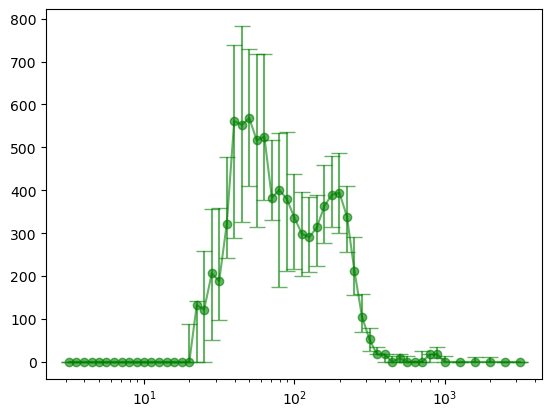

In [167]:
fig,ax = plt.subplots()
ax.errorbar(all_mid, Caribbean_median_df['Median'], yerr=[Caribbean_transport_plot_25, Caribbean_transport_plot_75], marker='o', linestyle='-', capsize=6, alpha=.6, color="green", label = '1-3.5km')
ax.set_xscale('log')

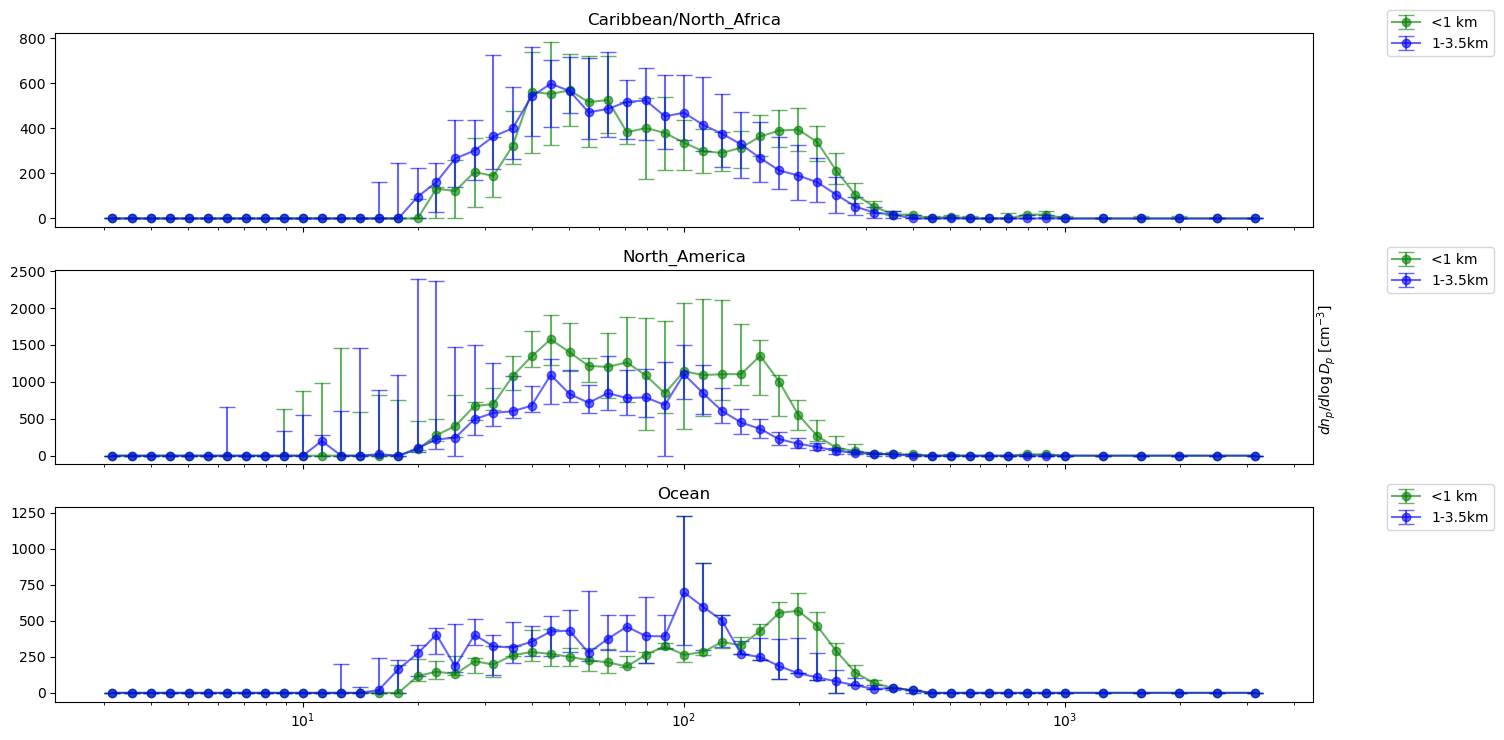

In [168]:
fig,ax = plt.subplots(3, 1, figsize=(15, 7.5), sharey='row', sharex='all')
ax[0].errorbar(all_mid, Caribbean_median_df['Median'], yerr=[Caribbean_transport_plot_25, Caribbean_transport_plot_75], marker='o', linestyle='-', capsize=6, alpha=.6, color="green", label = '<1 km')
ax[0].errorbar(all_mid, Caribbean2_median_df['Median'], yerr=[Caribbean2_transport_plot_25, Caribbean2_transport_plot_75], marker='o', linestyle='-', capsize=6, alpha=.6, color="blue", label = '1-3.5km')
ax[1].errorbar(all_mid, North_America_median_df['Median'], yerr=[North_America_transport_plot_25, North_America_transport_plot_75], marker='o', linestyle='-', capsize=6, alpha=.6, color="green", label = '<1 km')
ax[1].errorbar(all_mid, North_America2_median_df['Median'], yerr=[North_America2_transport_plot_25, North_America2_transport_plot_75], marker='o', linestyle='-', capsize=6, alpha=.6, color="blue", label = '1-3.5km')
ax[2].errorbar(all_mid,ocean_median_df['Median'], yerr=[ocean_transport_plot_25, ocean_transport_plot_75], marker='o', linestyle='-', capsize=6, alpha=.6, color="green", label = '<1 km')
ax[2].errorbar(all_mid, ocean2_median_df['Median'], yerr=[ocean2_transport_plot_25, ocean2_transport_plot_75], marker='o', linestyle='-', capsize=6, alpha=.6, color="blue", label = '1-3.5km')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[0].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='medium')
ax[1].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='medium')
ax[2].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='medium')
 # Add text to each subplot
ax[0].set_title('Caribbean/North_Africa')
ax[1].set_title('North_America')
ax[2].set_title('Ocean')
fig.text(0.88, 0.5, '$dn_p/d\log D_p$ [cm$^{-3}$]', va='center', rotation='vertical')

# Add titles using fig.text()

# Adjust layout
plt.tight_layout()

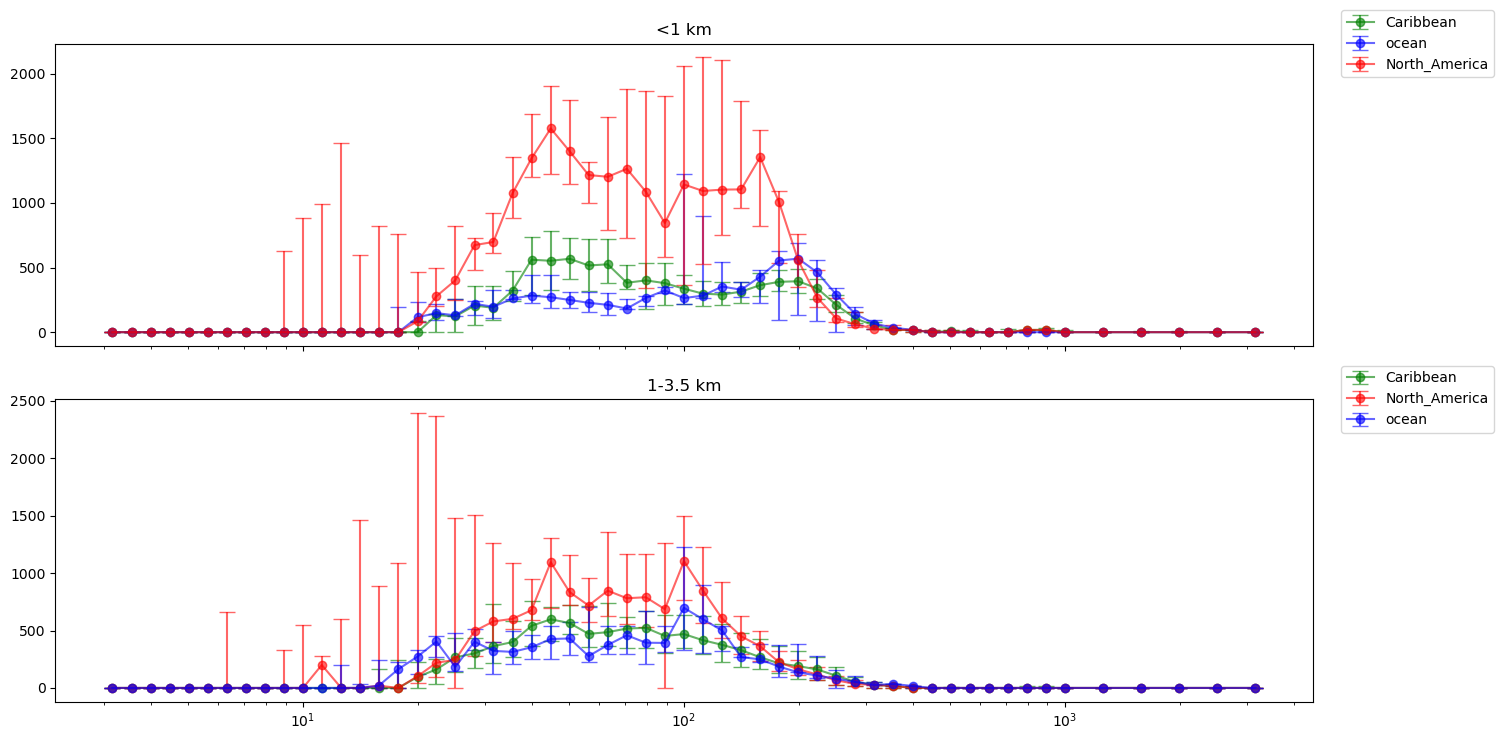

In [169]:
fig,ax = plt.subplots(2, 1, figsize=(15, 7.5), sharey='row', sharex='all')
ax[0].errorbar(all_mid, Caribbean_median_df['Median'], yerr=[Caribbean_transport_plot_25, Caribbean_transport_plot_75], marker='o', linestyle='-', capsize=6, alpha=.6, color="green", label = 'Caribbean')
ax[0].errorbar(all_mid,ocean_median_df['Median'], yerr=[ocean_transport_plot_25, ocean_transport_plot_75], marker='o', linestyle='-', capsize=6, alpha=.6, color="blue", label = 'ocean')
ax[0].errorbar(all_mid, North_America_median_df['Median'], yerr=[North_America_transport_plot_25, North_America_transport_plot_75], marker='o', linestyle='-', capsize=6, alpha=.6, color="red", label = 'North_America')
ax[1].errorbar(all_mid, Caribbean2_median_df['Median'], yerr=[Caribbean2_transport_plot_25, Caribbean2_transport_plot_75], marker='o', linestyle='-', capsize=6, alpha=.6, color="green", label = 'Caribbean')
ax[1].errorbar(all_mid, North_America2_median_df['Median'], yerr=[North_America2_transport_plot_25, North_America2_transport_plot_75], marker='o', linestyle='-', capsize=6, alpha=.6, color="red", label = 'North_America')
ax[1].errorbar(all_mid, ocean2_median_df['Median'], yerr=[ocean2_transport_plot_25, ocean2_transport_plot_75], marker='o', linestyle='-', capsize=6, alpha=.6, color="blue", label = 'ocean')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='medium')
ax[1].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='medium')
 # Add text to each subplot
ax[0].set_title('<1 km')
ax[1].set_title('1-3.5 km')

# Add titles using fig.text()

# Adjust layout
plt.tight_layout()

In [170]:
def log_norm(D, N, sigma, dg, N2, sigma2, dg2):
    output = N/((2*np.pi)**.5 * np.log(sigma))*np.exp(-(np.log(D)-np.log(dg))**2/(2*(np.log(sigma))**2))
    output += N2/((2*np.pi)**.5 * np.log(sigma2))*np.exp(-(np.log(D)-np.log(dg2))**2/(2*(np.log(sigma2))**2))
    return output

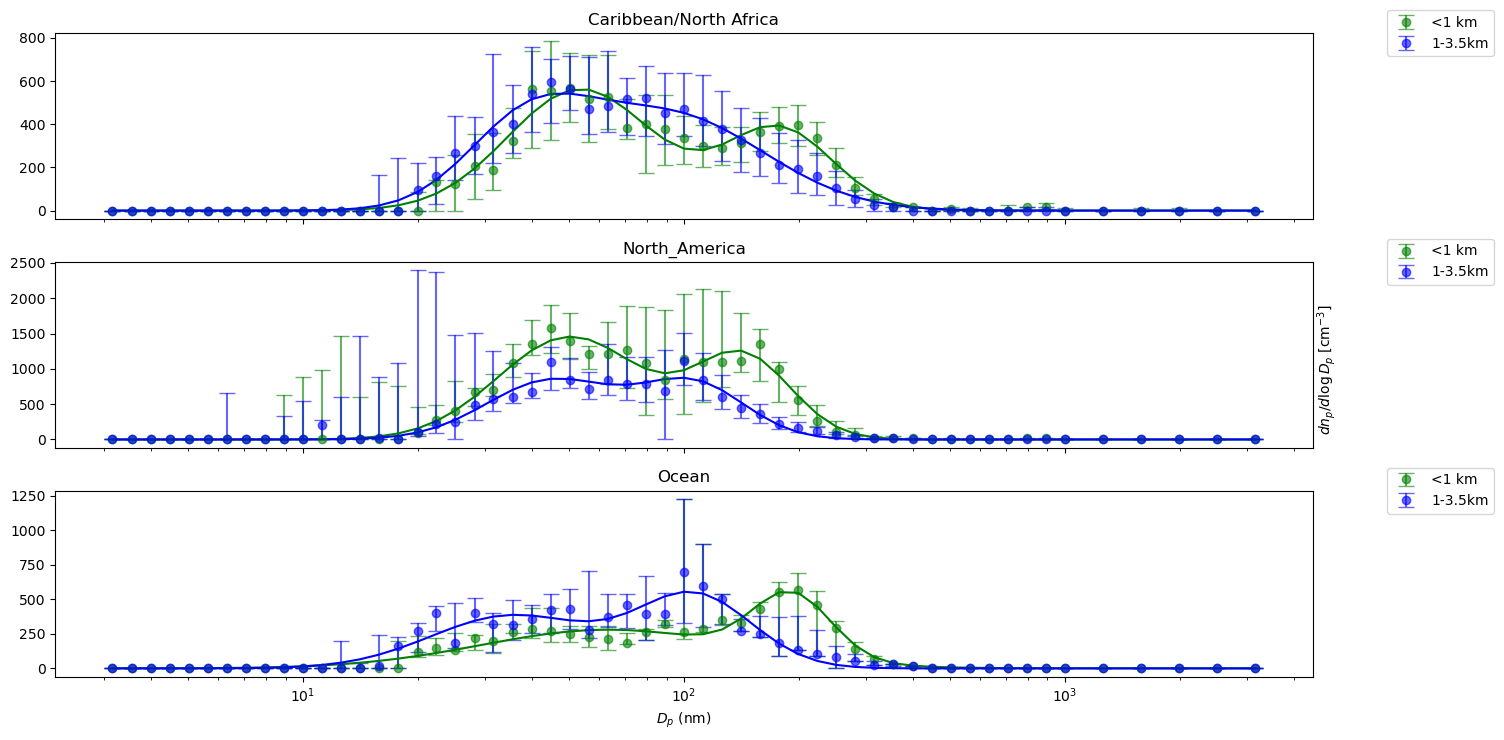

In [171]:
fig,ax = plt.subplots(3, 1, figsize=(15, 7.5), sharey='row', sharex='all')
ft = ax[0].errorbar(all_mid_val['value'], Caribbean_median_df['Median'], yerr=[Caribbean_transport_plot_25, Caribbean_transport_plot_75], marker='o', linestyle='', capsize=6, alpha=.6, color="green", label = '<1 km')
ft1 = ax[0].errorbar(all_mid_val['value'], Caribbean2_median_df['Median'], yerr=[Caribbean2_transport_plot_25, Caribbean2_transport_plot_75], marker='o', linestyle='', capsize=6, alpha=.6, color="blue", label = '1-3.5km')
ft2 = ax[1].errorbar(all_mid_val['value'], North_America_median_df['Median'], yerr=[North_America_transport_plot_25, North_America_transport_plot_75], marker='o', linestyle='', capsize=6, alpha=.6, color="green", label = '<1 km')
f3 = ax[1].errorbar(all_mid_val['value'], North_America2_median_df['Median'], yerr=[North_America2_transport_plot_25, North_America2_transport_plot_75], marker='o', linestyle='', capsize=6, alpha=.6, color="blue", label = '1-3.5km')
f4 = ax[2].errorbar(all_mid_val['value'],ocean_median_df['Median'], yerr=[ocean_transport_plot_25, ocean_transport_plot_75], marker='o', linestyle='', capsize=6, alpha=.6, color="green", label = '<1 km')
f5 = ax[2].errorbar(all_mid_val['value'], ocean2_median_df['Median'], yerr=[ocean2_transport_plot_25, ocean2_transport_plot_75], marker='o', linestyle='', capsize=6, alpha=.6, color="blue", label = '1-3.5km')
popt, pcov = curve_fit(log_norm, all_mid_val['value'], Caribbean_median_df['Median'], p0=[3.9e+03, 1.5e+00, 3.6e+01, 4.2e+03, 1.5e+00, 1.3e+02])
popt1, pcov1 = curve_fit(log_norm, all_mid_val['value'], Caribbean2_median_df['Median'], p0=[3.9e+03, 1.5e+00, 3.6e+01, 4.2e+03, 1.5e+00, 1.3e+02])
popt2, pcov2 = curve_fit(log_norm, all_mid_val['value'], North_America_median_df['Median'], p0=[3.9e+03, 1.5e+00, 3.6e+01, 4.2e+03, 1.5e+00, 1.3e+02])
popt3, pcov3 = curve_fit(log_norm, all_mid_val['value'], North_America2_median_df['Median'], p0=[3.9e+03, 1.5e+00, 3.6e+01, 4.2e+03, 1.5e+00, 1.3e+02])
popt4, pcov4 = curve_fit(log_norm, all_mid_val['value'], ocean_median_df['Median'], p0=[3.9e+03, 1.5e+00, 3.6e+01, 4.2e+03, 1.5e+00, 1.3e+02])
popt5, pcov5 = curve_fit(log_norm, all_mid_val['value'], ocean2_median_df['Median'], p0=[3.9e+03, 1.5e+00, 3.6e+01, 4.2e+03, 1.5e+00, 1.3e+02])
ax[0].plot(all_mid_val['value'], log_norm(all_mid_val['value'], *popt), color = 'green')
ax[0].plot(all_mid_val['value'], log_norm(all_mid_val['value'], *popt1), color = 'blue')
ax[1].plot(all_mid_val['value'], log_norm(all_mid_val['value'], *popt2), color = 'green')
ax[1].plot(all_mid_val['value'], log_norm(all_mid_val['value'], *popt3), color = 'blue')
ax[2].plot(all_mid_val['value'], log_norm(all_mid_val['value'], *popt4), color = 'green')
ax[2].plot(all_mid_val['value'], log_norm(all_mid_val['value'], *popt5), color = 'blue')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[0].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='medium')
ax[1].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='medium')
ax[2].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='medium')
 # Add text to each subplot
ax[0].set_title('Caribbean/North Africa')
ax[1].set_title('North_America')
ax[2].set_title('Ocean')
ax[2].set_xlabel('$D_p$ (nm)')
fig.text(0.88, 0.5, '$dn_p/d\log D_p$ [cm$^{-3}$]', va='center', rotation='vertical')
# Add titles using fig.text()

# Adjust layout
plt.tight_layout()

In [172]:
popt2

array([1.59397058e+03, 1.54795361e+00, 5.03210266e+01, 8.55120857e+02,
       1.33871873e+00, 1.42682312e+02])

In [173]:
from matplotlib.transforms import ScaledTranslation

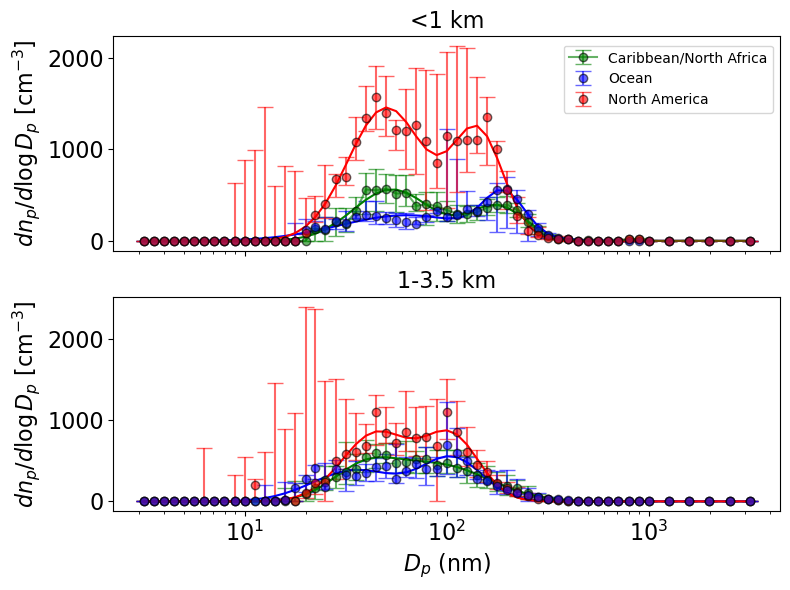

In [174]:
fig,ax = plt.subplots(2, 1, figsize=(8, 6), sharey='row', sharex='all')
ax[0].errorbar(all_mid_val['value'], Caribbean_median_df['Median'], yerr=[Caribbean_transport_plot_25, Caribbean_transport_plot_75], marker='o',  markeredgecolor = 'black', linestyle='-', capsize=6, alpha=.6, color="green", label = 'Caribbean/North Africa')
ax[0].errorbar(all_mid_val['value'],ocean_median_df['Median'], yerr=[ocean_transport_plot_25, ocean_transport_plot_75], marker='o', linestyle='', capsize=6,  markeredgecolor = 'black', alpha=.6, color="blue", label = 'Ocean')
ax[0].errorbar(all_mid_val['value'], North_America_median_df['Median'], yerr=[North_America_transport_plot_25, North_America_transport_plot_75], marker='o',  markeredgecolor = 'black', linestyle='', capsize=6, alpha=.6, color="red", label = 'North America')
ax[1].errorbar(all_mid_val['value'], Caribbean2_median_df['Median'], yerr=[Caribbean2_transport_plot_25, Caribbean2_transport_plot_75], marker='o',  markeredgecolor = 'black', linestyle='', capsize=6, alpha=.6, color="green", label = 'Caribbean')
ax[1].errorbar(all_mid_val['value'], North_America2_median_df['Median'], yerr=[North_America2_transport_plot_25, North_America2_transport_plot_75], marker='o',  markeredgecolor = 'black', linestyle='', capsize=6, alpha=.6, color="red", label = 'North America')
ax[1].errorbar(all_mid_val['value'], ocean2_median_df['Median'], yerr=[ocean2_transport_plot_25, ocean2_transport_plot_75], marker='o',  markeredgecolor = 'black', linestyle='', capsize=6, alpha=.6, color="blue", label = 'Ocean')
popt, pcov = curve_fit(log_norm, all_mid_val['value'], Caribbean_median_df['Median'], p0=[3.9e+03, 1.5e+00, 3.6e+01, 4.2e+03, 1.5e+00, 1.3e+02])
popt1, pcov1 = curve_fit(log_norm, all_mid_val['value'], ocean_median_df['Median'], p0=[3.9e+03, 1.5e+00, 3.6e+01, 4.2e+03, 1.5e+00, 1.3e+02])
popt2, pcov2 = curve_fit(log_norm, all_mid_val['value'], North_America_median_df['Median'], p0=[3.9e+03, 1.5e+00, 3.6e+01, 4.2e+03, 1.5e+00, 1.3e+02])

popt3, pcov3 = curve_fit(log_norm, all_mid_val['value'], Caribbean2_median_df['Median'], p0=[3.9e+03, 1.5e+00, 3.6e+01, 4.2e+03, 1.5e+00, 1.3e+02])
popt4, pcov4 = curve_fit(log_norm, all_mid_val['value'], ocean2_median_df['Median'], p0=[3.9e+03, 1.5e+00, 3.6e+01, 4.2e+03, 1.5e+00, 1.3e+02])
popt5, pcov5 = curve_fit(log_norm, all_mid_val['value'], North_America2_median_df['Median'], p0=[3.9e+03, 1.5e+00, 3.6e+01, 4.2e+03, 1.5e+00, 1.3e+02])

ax[0].plot(all_mid_val['value'], log_norm(all_mid_val['value'], *popt), color = 'green')
ax[0].plot(all_mid_val['value'], log_norm(all_mid_val['value'], *popt1), color = 'blue')
ax[0].plot(all_mid_val['value'], log_norm(all_mid_val['value'], *popt2), color = 'red')
ax[1].plot(all_mid_val['value'], log_norm(all_mid_val['value'], *popt3), color = 'green')
ax[1].plot(all_mid_val['value'], log_norm(all_mid_val['value'], *popt4), color = 'blue')
ax[1].plot(all_mid_val['value'], log_norm(all_mid_val['value'], *popt5), color = 'red')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].legend(bbox_to_anchor=(1, 0.8), loc = 'right', fontsize='medium')
for ax_ in ax:
    ax_.tick_params(axis='both', which='both', labelsize=16)
labels = ['a)', 'b)']
'''for i in range(2):
    trans = ScaledTranslation(10 / 72, -5 / 72, fig.dpi_scale_trans)
    ax[i].text(
        -0.01, 1, labels[i],
        transform=ax[i].transAxes + trans,
        fontsize='large', verticalalignment='top',
        bbox=dict(facecolor='1', edgecolor='none', pad=3.0)
    )'''

 # Add text to each subplot
ax[0].set_title('<1 km', fontsize = 16)
ax[1].set_title('1-3.5 km', fontsize = 16)
ax[1].set_xlabel('$D_p$ (nm)', fontsize = 16)
ax[0].set_ylabel('$dn_p/d\log D_p$ [cm$^{-3}$]', fontsize = 16)
ax[1].set_ylabel('$dn_p/d\log D_p$ [cm$^{-3}$]', fontsize = 16)
# Add titles using fig.text()

# Adjust layout
plt.tight_layout()

In [175]:
# Convert list to NumPy array
my_array = np.array(all_mid)
n =  my_array/1000
# Conversion factor: (4/3) * pi * (D/2)^3
conversion_factor = (np.pi/6) * ((n) ** 3)

In [176]:
oceanic = conversion_factor*(ocean)
oceanic2 = conversion_factor*(ocean2)
oceanic_median = oceanic.median()
oceanic_median_df = oceanic_median.to_frame().reset_index()
oceanic_median_df.columns = ['Column', 'Median']
# Calculate median values along columns
oceanic2_median = oceanic2.median()
oceanic2_median_df = oceanic2_median.to_frame().reset_index()
oceanic2_median_df.columns = ['Column', 'Median']
oceanic2_median_df = oceanic2_median_df.replace(np.NaN, 0)

In [177]:
oceanic1 = oceanic.quantile(.25).replace(np.NaN, 0)
oceanic_1 = oceanic1.to_frame().reset_index()
oceanic_1.columns = ['Column', 'Median']
oceanic_1
oceanic22 = oceanic.quantile(.75).replace(np.NaN, 0)
oceanic_2 = oceanic22.to_frame().reset_index()
oceanic_2.columns = ['Column', 'Median']
oceanic_2
oceanic_transport_plot_25 = oceanic_median_df['Median'] - oceanic_1['Median']
oceanic_transport_plot_25 = oceanic_transport_plot_25.replace(np.NaN, 0)
oceanic_transport_plot_25
oceanic_transport_plot_75 = oceanic_2['Median'] - oceanic_median_df['Median']
oceanic_transport_plot_75 = oceanic_transport_plot_75.replace(np.NaN, 0)
oceanic_transport_plot_75


oceanic3 = oceanic2.quantile(.25).replace(np.NaN, 0)
oceanic_3 = oceanic3.to_frame().reset_index()
oceanic_3.columns = ['Column', 'Median']
oceanic_3
oceanic4 = oceanic2.quantile(.75).replace(np.NaN, 0)
oceanic_4 = oceanic4.to_frame().reset_index()
oceanic_4.columns = ['Column', 'Median']
oceanic_4
oceanic2_transport_plot_25 = oceanic2_median_df['Median'] - oceanic_3['Median']
oceanic2_transport_plot_25 = oceanic2_transport_plot_25.replace(np.NaN, 0)
oceanic2_transport_plot_75 = oceanic_4['Median'] - oceanic2_median_df['Median']
oceanic2_transport_plot_75 = oceanic2_transport_plot_75.replace(np.NaN, 0)
oceanic2_transport_plot_75

0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000211
13    0.000056
14    0.000455
15    0.000192
16    0.000232
17    0.000273
18    0.002420
19    0.001258
20    0.001301
21    0.004192
22    0.003582
23    0.005148
24    0.009661
25    0.039844
26    0.022077
27    0.014909
28    0.071263
29    0.055925
30    0.276036
31    0.221951
32    0.043186
33    0.132176
34    0.279252
35    0.559977
36    1.012683
37    0.993827
38    0.661292
39    0.617112
40    0.432910
41    0.002105
42    0.000000
43    0.000000
44    0.000000
45    0.000000
46    0.000000
47    0.000000
48    0.000000
49    0.000000
50    0.000000
51    0.000000
52    0.000000
53    0.000000
54    0.000000
55    0.000000
Name: Median, dtype: float64

In [178]:
North_Americal = conversion_factor*(North_America)
North_Americal2 = conversion_factor*(North_America2)
North_Americal_median = North_Americal.median()
North_Americal_median_df = North_Americal_median.to_frame().reset_index()
North_Americal_median_df.columns = ['Column', 'Median']
# Calculate median values along columns
North_Americal2_median = North_Americal2.median()
North_Americal2_median_df = North_Americal2_median.to_frame().reset_index()
North_Americal2_median_df.columns = ['Column', 'Median']
North_Americal2_median_df = North_Americal2_median_df.replace(np.nan, 0)

In [179]:
North_Americal1 = North_Americal.quantile(.25).replace(np.NaN, 0)
North_Americal_1 = North_Americal1.to_frame().reset_index()
North_Americal_1.columns = ['Column', 'Median']
North_Americal_1
North_Americal22 = North_Americal.quantile(.75).replace(np.NaN, 0)
North_Americal_2 = North_Americal22.to_frame().reset_index()
North_Americal_2.columns = ['Column', 'Median']
North_Americal_2
North_Americal_transport_plot_25 = North_Americal_median_df['Median'] - North_Americal_1['Median']
North_Americal_transport_plot_25
North_Americal_transport_plot_75 = North_Americal_2['Median'] - North_Americal_median_df['Median']
North_Americal_transport_plot_75


North_Americal3 = North_Americal2.quantile(.25).replace(np.NaN, 0)
North_Americal_3 = North_Americal3.to_frame().reset_index()
North_Americal_3.columns = ['Column', 'Median']
North_Americal_3
North_Americal4 = North_Americal2.quantile(.75).replace(np.NaN, 0)
North_Americal_4 = North_Americal4.to_frame().reset_index()
North_Americal_4.columns = ['Column', 'Median']
North_Americal_4
North_Americal2_transport_plot_25 = North_Americal2_median_df['Median'] - North_Americal_3['Median']
North_Americal2_transport_plot_25 = North_Americal2_transport_plot_25.replace(np.NaN, 0)
North_Americal2_transport_plot_25
North_Americal2_transport_plot_75 = North_Americal_4['Median'] - North_Americal2_median_df['Median']
North_Americal2_transport_plot_75 = North_Americal2_transport_plot_75.replace(np.NaN, 0)
North_Americal2_transport_plot_75

0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000087
7     0.000000
8     0.000000
9     0.000122
10    0.000287
11    0.000057
12    0.000631
13    0.002143
14    0.001793
15    0.003212
16    0.009599
17    0.012641
18    0.010212
19    0.011860
20    0.011223
21    0.011320
22    0.008837
23    0.009866
24    0.021375
25    0.022372
26    0.066672
27    0.071304
28    0.099492
29    0.214109
30    0.208282
31    0.282770
32    0.327796
33    0.265902
34    0.281150
35    0.298482
36    0.337294
37    0.365848
38    0.329121
39    0.408811
40    0.001407
41    0.001637
42    0.570846
43    0.000000
44    0.000000
45    0.000000
46    0.000000
47    0.000000
48    0.000000
49    0.000000
50    0.000000
51    0.000000
52    0.000000
53    0.000000
54    0.000000
55    0.000000
Name: Median, dtype: float64

In [180]:
Caribbea = conversion_factor*(Caribbean)
Caribbea2 = conversion_factor*(Caribbean2)
Caribbea_median = Caribbea.median()
Caribbea_median_df = Caribbea_median.to_frame().reset_index()
Caribbea_median_df.columns = ['Column', 'Median']
# Calculate median values along columns
Caribbea2_median = Caribbea2.median()
Caribbea2_median_df = Caribbea2_median.to_frame().reset_index()
Caribbea2_median_df.columns = ['Column', 'Median']
Caribbea_median_df
Caribbea2_median_df = Caribbea2_median_df.replace(np.NaN, 0)

In [181]:

Caribbea1 = Caribbea.quantile(.25).replace(np.NaN, 0)
Caribbea_1 = Caribbea1.to_frame().reset_index()
Caribbea_1.columns = ['Column', 'Median']
Caribbea_1
Caribbea22 = Caribbea.quantile(.75).replace(np.NaN, 0)
Caribbea_2 = Caribbea22.to_frame().reset_index()
Caribbea_2.columns = ['Column', 'Median']
Caribbea_2
Caribbea_transport_plot_25 = Caribbea_median_df['Median'] - Caribbea_1['Median']
Caribbea_transport_plot_25
Caribbea_transport_plot_75 = Caribbea_2['Median'] - Caribbea_median_df['Median']
Caribbea_transport_plot_75


Caribbea3 = Caribbea2.quantile(.25).replace(np.NaN, 0)
Caribbea_3 = Caribbea3.to_frame().reset_index()
Caribbea_3.columns = ['Column', 'Median']
Caribbea_3
Caribbea4 = Caribbea2.quantile(.75).replace(np.NaN, 0)
Caribbea_4 = Caribbea4.to_frame().reset_index()
Caribbea_4.columns = ['Column', 'Median']
Caribbea_4
Caribbea2_transport_plot_25 = Caribbea2_median_df['Median'] - Caribbea_3['Median']
Caribbea2_transport_plot_25 = Caribbea2_transport_plot_25.replace(np.NaN, 0)
Caribbea2_transport_plot_25
Caribbea2_transport_plot_75 = Caribbea_4['Median'] - Caribbea2_median_df['Median']
Caribbea2_transport_plot_75 = Caribbea2_transport_plot_75.replace(np.NaN, 0)
Caribbea2_transport_plot_75

0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000338
15    0.000721
16    0.000525
17    0.000511
18    0.001429
19    0.001570
20    0.006000
21    0.004269
22    0.007193
23    0.004989
24    0.010067
25    0.022435
26    0.033426
27    0.018246
28    0.037760
29    0.067340
30    0.087902
31    0.156332
32    0.185563
33    0.214782
34    0.338529
35    0.435696
36    0.562420
37    0.627561
38    0.653438
39    0.511849
40    0.431668
41    0.404981
42    0.571837
43    0.000000
44    0.569238
45    0.000000
46    0.000000
47    0.000000
48    4.534152
49    6.417523
50    0.000000
51    0.000000
52    0.000000
53    0.000000
54    0.000000
55    0.000000
Name: Median, dtype: float64

In [182]:
def log_norm(D, A, sigma, dg):
    output = A/((2*np.pi)**.5 * np.log(sigma))*np.exp(-(np.log(D)-np.log(dg))**2/(2*(np.log(sigma))**2))
    return output

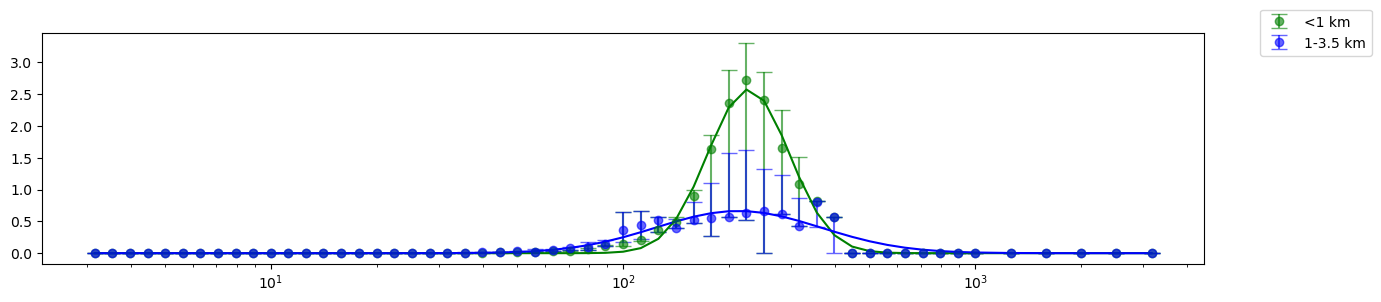

In [183]:
fig,ax = plt.subplots(figsize=(15, 3))
ft = ax.errorbar(all_mid_val['value'], oceanic_median_df['Median'], yerr=[oceanic_transport_plot_25, oceanic_transport_plot_75], marker='o', linestyle='', capsize=6, alpha=.6, color="green", label = '<1 km')
ft2 = ax.errorbar(all_mid_val['value'], oceanic2_median_df['Median'], yerr=[oceanic2_transport_plot_25, oceanic2_transport_plot_75], marker='o', linestyle='', capsize=6, alpha=.6, color="blue", label = '1-3.5 km')

popt, pcov = curve_fit(log_norm, all_mid_val['value'], oceanic_median_df['Median'], p0=[3.9e+03, 1.5e+00, 3.6e+01])
popt1, pcov1 = curve_fit(log_norm, all_mid_val['value'], oceanic2_median_df['Median'], p0=[3.9e+03, 1.5e+00, 3.6e+01])
ax.plot(all_mid_val['value'], log_norm(all_mid_val['value'], *popt), color = 'green')
ax.plot(all_mid_val['value'], log_norm(all_mid_val['value'], *popt1), color = 'blue')
ax.set_xscale('log')
ax.legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='medium')

In [184]:
North_Americal_median_df['Median'].mean()

0.5204461055360092

In [185]:
all_mid_val['value'].mean()

351.47732142857143

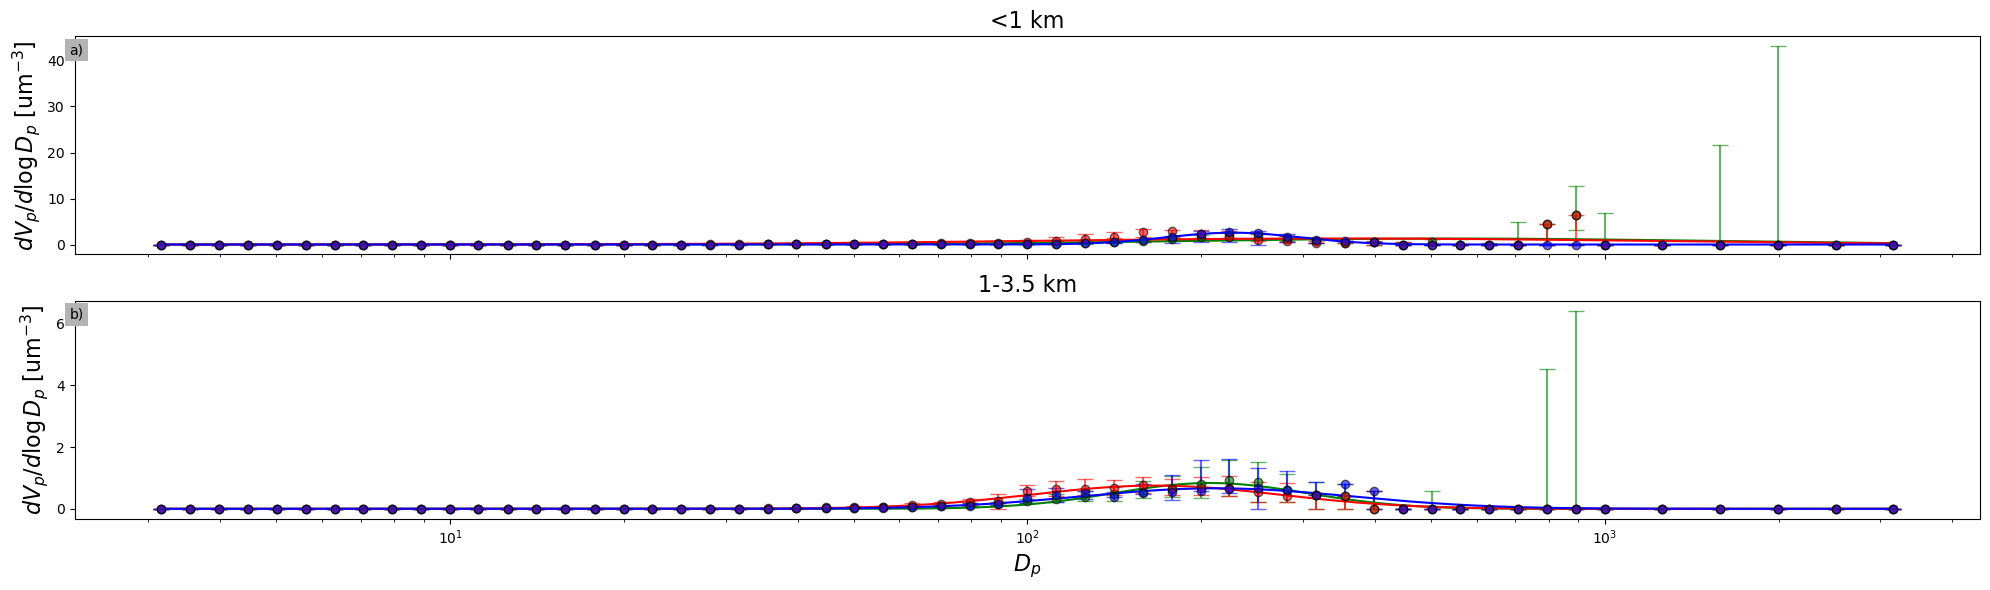

In [186]:
from matplotlib.transforms import ScaledTranslation
def log_norm(D, V, sigma, dg):
    output = V/((2*np.pi)**.5 * np.log(sigma))*np.exp(-(np.log(D)-np.log(dg))**2/(2*(np.log(sigma))**2))
    return output
# Create a plot
fig,ax = plt.subplots(2, 1, figsize=(20, 6), sharey='row', sharex='all')

# Plot data points with error bars
ft = ax[0].errorbar(all_mid_val['value'], Caribbea_median_df['Median'], yerr=[Caribbea_transport_plot_25, Caribbea_transport_plot_75], marker='o',  markeredgecolor = 'black', linestyle='', capsize=6, alpha=.6, color="green", label = 'caribbean')
#ft1 = ax[0].errorbar(all_mid_val['value'], Caribbea_median_df['Median'], yerr=[Caribbea_transport_plot_25, Caribbea_transport_plot_75], marker='o', linestyle='-', capsize=6, alpha=.6, color="blue", label = 'Caribbean')
ft1 = ax[0].errorbar(all_mid_val['value'], North_Americal_median_df['Median'], yerr=[North_Americal_transport_plot_25, North_Americal_transport_plot_75], marker='o',  markeredgecolor = 'black', linestyle='', capsize=6, alpha=.6, color="red", label = 'North America')
ft2 = ax[0].errorbar(all_mid_val['value'], oceanic_median_df['Median'], yerr=[oceanic_transport_plot_25, oceanic_transport_plot_75], marker='o',  markeredgecolor = 'black', linestyle='', capsize=6, alpha=.6, color="blue", label = 'Ocean')
ft3 = ax[1].errorbar(all_mid_val['value'], Caribbea2_median_df['Median'], yerr=[Caribbea2_transport_plot_25, Caribbea2_transport_plot_75], marker='o',  markeredgecolor = 'black', linestyle='', capsize=6, alpha=.6, color="green", label = 'Caribbean')
ft4 = ax[1].errorbar(all_mid_val['value'], North_Americal2_median_df['Median'], yerr=[North_Americal2_transport_plot_25, North_Americal2_transport_plot_75], marker='o',  markeredgecolor = 'black', linestyle='', capsize=6, alpha=.6, color="red", label = 'North America')
ft5 = ax[1].errorbar(all_mid_val['value'], oceanic2_median_df['Median'], yerr=[oceanic2_transport_plot_25, oceanic2_transport_plot_75], marker='o',  markeredgecolor = 'black', linestyle='', capsize=6, alpha=.6, color="blue", label = 'Ocean')

popt, pcov = curve_fit(log_norm, all_mid_val['value'], Caribbea_median_df['Median'], p0=[3.9e+03, 1.8, 4])
popt1, pcov1 = curve_fit(log_norm, all_mid_val['value'], North_Americal_median_df['Median'], p0=[3.9e+03, 1.8, 3.6])
popt2, pcov2 = curve_fit(log_norm, all_mid_val['value'], oceanic_median_df['Median'], p0=[3.5e+02, 1.5, 3.6])
popt3, pcov3 = curve_fit(log_norm, all_mid_val['value'], Caribbea2_median_df['Median'], p0=[3.9e+03, 1.8, 3.6])

popt4, pcov4 = curve_fit(log_norm, all_mid_val['value'], North_Americal2_median_df['Median'], p0=[3.9e+03, 1.5, 3.6])
popt5, pcov5 = curve_fit(log_norm, all_mid_val['value'], oceanic2_median_df['Median'], p0=[3.9e+03, 1.8, 3.6])

# Generate smooth x values
smooth_x = np.logspace(np.log10(min(all_mid_val['value'])), np.log10(max(all_mid_val['value'])), 1000)

# Plot fitted curves with smooth lines
ax[0].plot(smooth_x, log_norm(smooth_x, *popt), color='green')
ax[0].plot(smooth_x, log_norm(smooth_x, *popt1), color='red')
ax[0].plot(smooth_x, log_norm(smooth_x, *popt2), color='blue')
ax[1].plot(smooth_x, log_norm(smooth_x, *popt3), color='green')
ax[1].plot(smooth_x, log_norm(smooth_x, *popt4), color='red')
ax[1].plot(smooth_x, log_norm(smooth_x, *popt5), color='blue')


ax[0].set_xscale('log')
ax[1].set_xscale('log')

#ax[0].set_ylim(0, 20000)
#ax[1].set_ylim(0, 4000)


 # Add text to each subplot
ax[0].set_title('<1 km', fontsize = 16)
ax[1].set_title('1-3.5 km', fontsize = 16)
ax[0].set_ylabel('$dV_p/d\log D_p$ [um$^{-3}$]', fontsize=16)
ax[1].set_ylabel('$dV_p/d\log D_p$ [um$^{-3}$]', fontsize=16)
ax[1].set_xlabel('$D_p$', fontsize = 16)
#fig.text(0.88, 0.5, '$\\mu m^3$ / $d\\log D_p$', va='center', rotation='vertical')
# Adjust left margin to accommodate the label

labels = ['a)', 'b)']
for i in range(2):
    trans = ScaledTranslation(10 / 72, -5 / 72, fig.dpi_scale_trans)
    ax[i].text(
        -0.01, 1, labels[i],
        transform=ax[i].transAxes + trans,
        fontsize='medium', verticalalignment='top',
        bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0)
    )

plt.subplots_adjust(left=0.1, right=0.9)


plt.tight_layout()
plt.show()


In [187]:
popt1

array([  3.99136325,   3.36624162, 346.51357925])

In [188]:
popt2

array([  1.7233433 ,   1.30624056, 226.96891698])

In [189]:
popt3

array([  0.80873376,   1.47164288, 207.31217262])

In [190]:
popt

array([  3.33590728,   2.78921054, 544.38175979])

In [191]:
popt5

array([  0.89666638,   1.71450084, 212.36126324])

In [192]:
popt4

array([  0.93868032,   1.6457752 , 166.55052258])

In [193]:
value_in_meters = 1.31476751e+09  # Value in meters
value_in_micrometers = value_in_meters / 1E6
print(f"{value_in_meters} meters is equal to {value_in_micrometers} µm")


1314767510.0 meters is equal to 1314.76751 µm


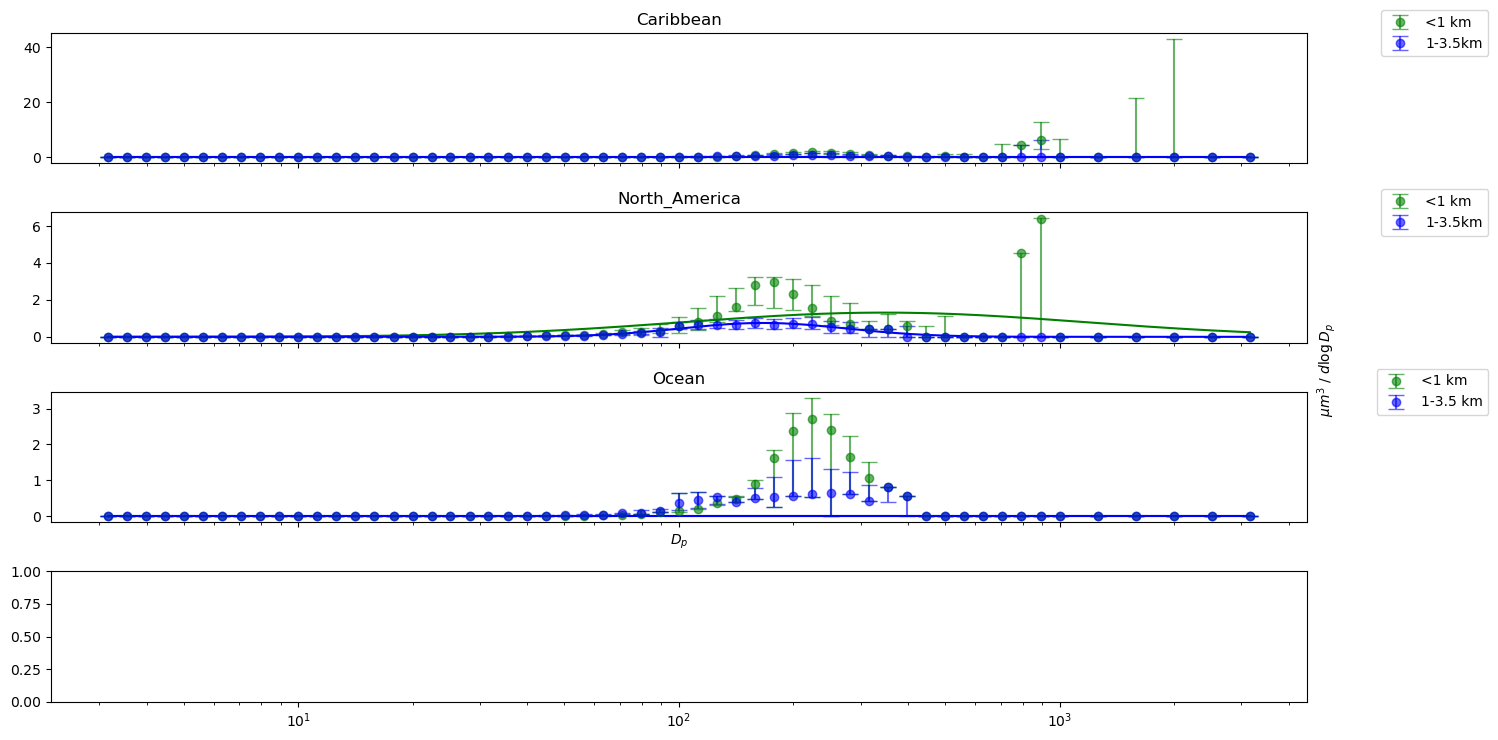

In [194]:
def log_norm(D, V, sigma, dg):
    output = V/((2*np.pi)**.5 * np.log(sigma))*np.exp(-(np.log(D)-np.log(dg))**2/(2*(np.log(sigma))**2))
    return output

# Create a plot
fig,ax = plt.subplots(4, 1, figsize=(15, 7.5), sharey='row', sharex='all')

# Plot data points with error bars
ft = ax[0].errorbar(all_mid_val['value'], Caribbea_median_df['Median'], yerr=[Caribbea_transport_plot_25, Caribbea_transport_plot_75], marker='o', linestyle='', capsize=6, alpha=.6, color="green", label = '<1 km')
ft1 = ax[0].errorbar(all_mid_val['value'], Caribbea2_median_df['Median'], yerr=[Caribbea2_transport_plot_25, Caribbea2_transport_plot_75], marker='o', linestyle='', capsize=6, alpha=.6, color="blue", label = '1-3.5km')
ft2 = ax[1].errorbar(all_mid_val['value'], North_Americal_median_df['Median'], yerr=[North_Americal_transport_plot_25, North_Americal_transport_plot_75], marker='o', linestyle='', capsize=6, alpha=.6, color="green", label = '<1 km')
ft3 = ax[1].errorbar(all_mid_val['value'], North_Americal2_median_df['Median'], yerr=[North_Americal2_transport_plot_25, North_Americal2_transport_plot_75], marker='o', linestyle='', capsize=6, alpha=.6, color="blue", label = '1-3.5km')
ft4 = ax[2].errorbar(all_mid_val['value'], oceanic_median_df['Median'], yerr=[oceanic_transport_plot_25, oceanic_transport_plot_75], marker='o', linestyle='', capsize=6, alpha=.6, color="green", label = '<1 km')
ft5 = ax[2].errorbar(all_mid_val['value'], oceanic2_median_df['Median'], yerr=[oceanic2_transport_plot_25, oceanic2_transport_plot_75], marker='o', linestyle='', capsize=6, alpha=.6, color="blue", label = '1-3.5 km')

# Fit curves
popt, pcov = curve_fit(log_norm, all_mid_val['value'], Caribbea_median_df['Median'], p0=[3.9e+03, 1.5, 3.6])
popt1, pcov1 = curve_fit(log_norm, all_mid_val['value'], Caribbea2_median_df['Median'], p0=[3.9e+03, 1.5, 3.6])
popt2, pcov2 = curve_fit(log_norm, all_mid_val['value'], North_Americal_median_df['Median'], p0=[3.9e+03, 1.8, 4])
popt3, pcov3 = curve_fit(log_norm, all_mid_val['value'], North_Americal2_median_df['Median'], p0=[3.9e+03, 1.5, 3.6])
popt4, pcov4 = curve_fit(log_norm, all_mid_val['value'], oceanic_median_df['Median'], p0=[3.9e+03, 1.5, 3.6])
popt5, pcov5 = curve_fit(log_norm, all_mid_val['value'], oceanic2_median_df['Median'], p0=[3.9e+03, 1.5, 3.6])

# Generate smooth x values
smooth_x = np.logspace(np.log10(min(all_mid_val['value'])), np.log10(max(all_mid_val['value'])), 1000)

# Plot fitted curves with smooth lines
ax[0].plot(smooth_x, log_norm(smooth_x, *popt), color='green')
ax[0].plot(smooth_x, log_norm(smooth_x, *popt1), color='blue')
ax[1].plot(smooth_x, log_norm(smooth_x, *popt2), color='green')
ax[1].plot(smooth_x, log_norm(smooth_x, *popt3), color='blue')
ax[2].plot(smooth_x, log_norm(smooth_x, *popt4), color='green')
ax[2].plot(smooth_x, log_norm(smooth_x, *popt5), color='blue')

ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[0].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='medium')
ax[1].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='medium')
ax[2].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='medium')
 # Add text to each subplot
ax[0].set_title('Caribbean')
ax[1].set_title('North_America')
ax[2].set_title('Ocean')
ax[2].set_xlabel('$D_p$')
fig.text(0.88, 0.5, '$\\mu m^3$ / $d\\log D_p$', va='center', rotation='vertical')
# Adjust left margin to accommodate the label
plt.subplots_adjust(left=0.1, right=0.9)


plt.tight_layout()
plt.show()


In [195]:
popt2

array([  3.99091573,   3.3654306 , 346.51762296])

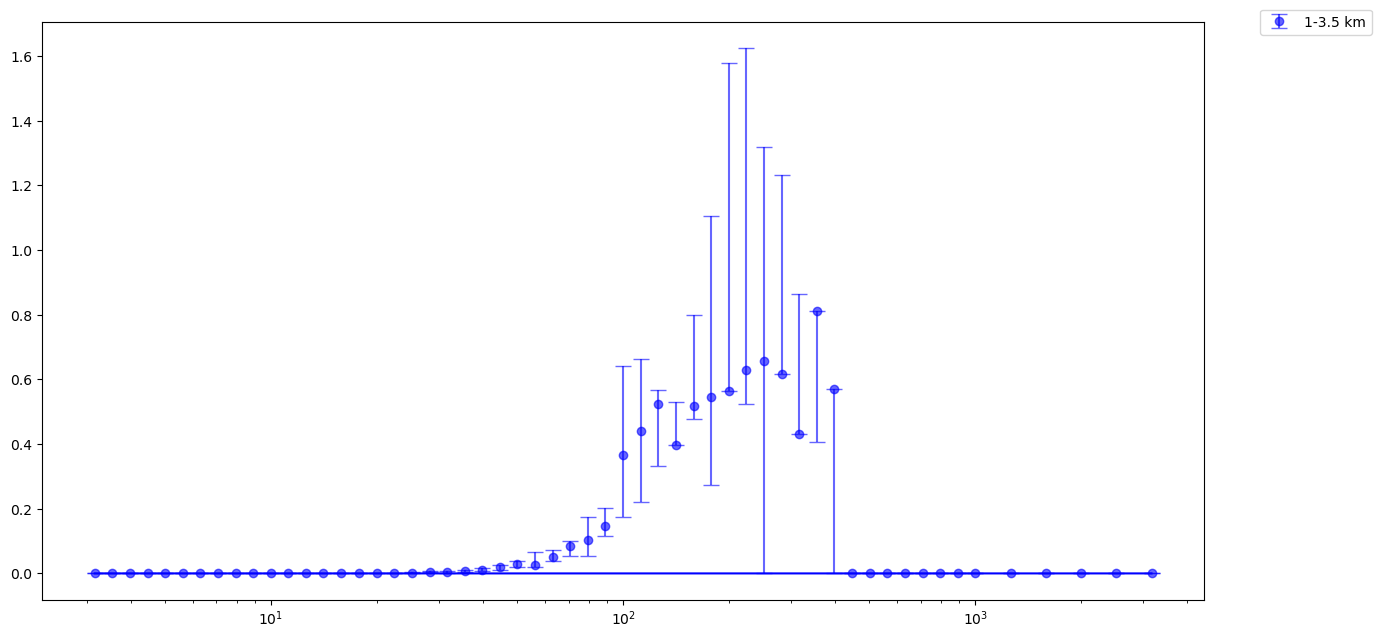

In [196]:
def log_norm(D, N, sigma, dg, N2, sigma2, dg2):
    output = N/((2*np.pi)**.5 * np.log(sigma))*np.exp(-(np.log(D)-np.log(dg))**2/(2*(np.log(sigma))**2))
    output += N2/((2*np.pi)**.5 * np.log(sigma2))*np.exp(-(np.log(D)-np.log(dg2))**2/(2*(np.log(sigma2))**2))
    return output
# Create a plot
fig,ax = plt.subplots(figsize=(15, 7.5))

#ft1 = ax.errorbar(all_mid_val['value'], oceanic_median_df['Median'], yerr=[oceanic_transport_plot_25, oceanic_transport_plot_75], marker='o', linestyle='', capsize=6, alpha=.6, color="green", label = '<1 km')
ft2 = ax.errorbar(all_mid_val['value'], oceanic2_median_df['Median'], yerr=[oceanic2_transport_plot_25, oceanic2_transport_plot_75], marker='o', linestyle='', capsize=6, alpha=.6, color="blue", label = '1-3.5 km')
# Generate smooth x values
smooth_x = np.logspace(np.log10(min(all_mid_val['value'])), np.log10(max(all_mid_val['value'])), 1000)
#popt1, pcov1 = curve_fit(log_norm, all_mid_val['value'], oceanic_median_df['Median'], p0=[3.9e+03, 1.5, 3.6, 4.2e+01, 1.8, 3.8])
popt2, pcov2 = curve_fit(log_norm, all_mid_val['value'], oceanic2_median_df['Median'], p0=[3.9e+03, 1.5, 3.6, 3.9e+03, 1.5, 3.6])
#ax.plot(smooth_x, log_norm(smooth_x, *popt1), color='green')
ax.plot(smooth_x, log_norm(smooth_x, *popt2), color='blue')
ax.set_xscale('log')
ax.legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='medium')

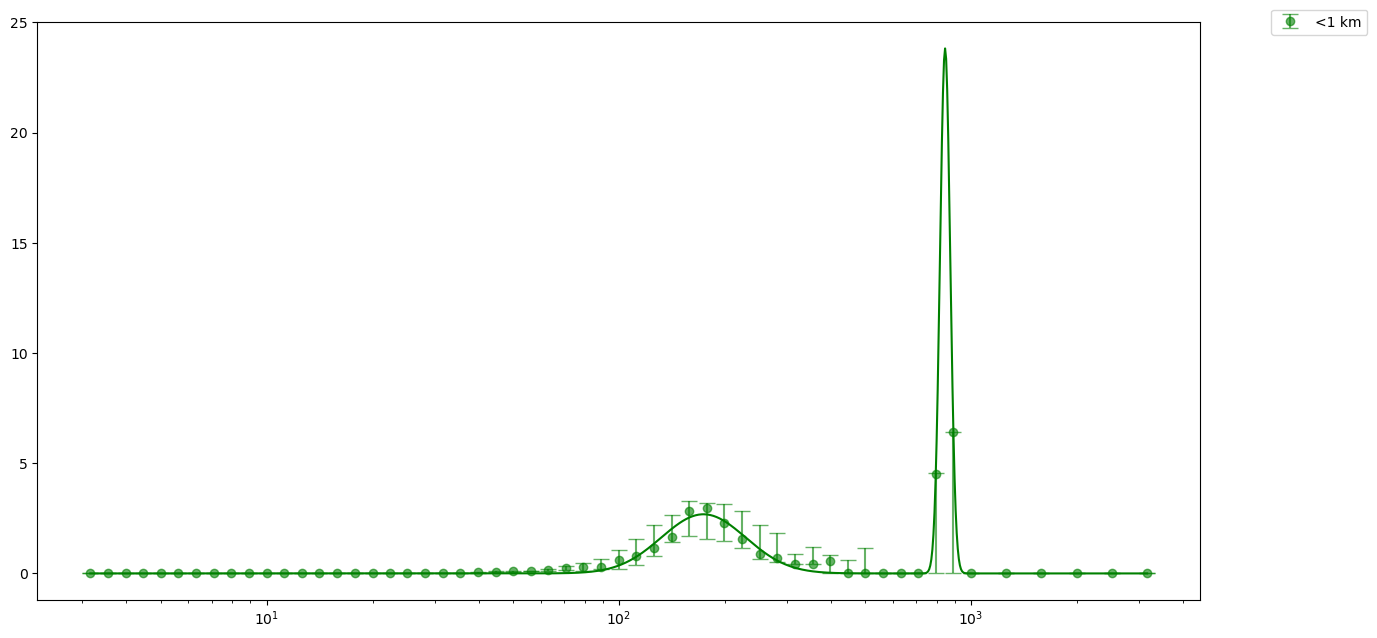

In [197]:
def log_norm(D, V, sigma, dg, V2, sigma2, dg2):
    output = V/((2*np.pi)**.5 * np.log(sigma))*np.exp(-(np.log(D)-np.log(dg))**2/(2*(np.log(sigma))**2))
    output += V2/((2*np.pi)**.5 * np.log(sigma2))*np.exp(-(np.log(D)-np.log(dg2))**2/(2*(np.log(sigma2))**2))
    return output
# Create a plot
fig,ax = plt.subplots(figsize=(15, 7.5))

ft4 = ax.errorbar(all_mid_val['value'], North_Americal_median_df['Median'], yerr=[North_Americal_transport_plot_25, North_Americal_transport_plot_75], marker='o', linestyle='', capsize=6, alpha=.6, color="green", label = '<1 km')
smooth_x = np.logspace(np.log10(min(all_mid_val['value'])), np.log10(max(all_mid_val['value'])), 1000)

popt, pcov = curve_fit(log_norm, all_mid_val['value'], North_Americal_median_df['Median'], p0=[3.9e+03, 1.5e+00, 3.6e+01, 4.2e+04, 1.6, 1.3e+02])
#ax.plot(smooth_x, log_norm(smooth_x, *popt1), color='green')
ax.plot(smooth_x, log_norm(smooth_x, *popt), color='green')
ax.set_xscale('log')
ax.legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='medium')

In [198]:
3.9e+03, 1.5e+00, 3.6e+01, 4.2e+03, 1.5e+00, 1.3e+02

(3900.0, 1.5, 36.0, 4200.0, 1.5, 130.0)

In [199]:
data = {
    'N1': [711.59],
    'N2': [319.42],
    'DG1': [55.15],
    'DG2': [183.86],
    'Total': [2532.40]
}

boundary_car = pd.DataFrame(data)

data2 = {
    'N1': [378.4],
    'N2': [271.09],
    'DG1': [55.15],
    'DG2': [48.31],
    'Total': [146.79]
}

boundary_africa = pd.DataFrame(data2)

data3 = {
    'N1': [537.80],
    'N2': [273.82],
    'DG1': [63.35],
    'DG2': [191.93],
    'Total': [1723.34]
}

boundary_ocean= pd.DataFrame(data3)

data4 = {
    'N1': [1594],
    'N2': [855.12],
    'DG1': [50.32],
    'DG2': [142.68],
    'Total': [1856.73]
}

boundary_ame= pd.DataFrame(data4)



In [200]:
# Concatenate the DataFrames vertically with keys
combined_df = pd.concat([boundary_car, boundary_africa, boundary_ocean, boundary_ame], keys=['boundary_car', 'boundary_africa', 'boundary_ocean', 'boundary_ame'])


combined_df

,,N1,N2,DG1,DG2,Total
boundary_car,0,711.59,319.42,55.15,183.86,2532.40
boundary_africa,0,378.40,271.09,55.15,48.31,146.79
boundary_ocean,0,537.80,273.82,63.35,191.93,1723.34
boundary_ame,0,1594.00,855.12,50.32,142.68,1856.73


In [201]:
'''import seaborn as sns

# Create a box and whisker plot using Seaborn
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.boxplot(data=combined_df, x=combined_df.index.get_level_values(0), y='N1')

# Set labels and title
plt.xlabel('Region')
plt.ylabel('N1 Values')
plt.title('Box and Whisker Plot of N1 Values by Region')

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=45)

# Show the plot
plt.show()'''

"import seaborn as sns\n\n# Create a box and whisker plot using Seaborn\nplt.figure(figsize=(10, 6))  # Adjust the figure size as needed\nsns.boxplot(data=combined_df, x=combined_df.index.get_level_values(0), y='N1')\n\n# Set labels and title\nplt.xlabel('Region')\nplt.ylabel('N1 Values')\nplt.title('Box and Whisker Plot of N1 Values by Region')\n\n# Rotate x-axis labels for better readability if needed\nplt.xticks(rotation=45)\n\n# Show the plot\nplt.show()"